# Sciplex Dose

In [1]:
ood_seed = 4

In [2]:
num_ood = 1

In [3]:
import cpa

[rank: 0] Global seed set to 0


In [4]:
import warnings
import os
import sys
import gc
import warnings

In [5]:
import warnings
import os
import sys
import gc
import warnings
import anndata as ad
import scanpy as sc
import copy
import torch
from pathlib import Path
import networkx as nx
from sklearn.neighbors import kneighbors_graph
import numpy as np
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.stats
import sklearn
from sklearn.dummy import DummyClassifier

print(f"CUDA used: {torch.cuda.is_available()}")

CUDA used: False

In [6]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
_rcparams_path = "/home/icb/kemal.inecik/work/codes/tardis/training/local/figures/rcparams.pickle"
with open(_rcparams_path, 'rb') as file:
    _rcparams = pickle.load(file)
plt.rcParams.update(_rcparams)

In [7]:
adata_file_path = os.path.join("/home/icb/kemal.inecik/lustre_workspace/tardis_data/processed", "cpa_GSM_new.h5ad")
assert os.path.isfile(adata_file_path), f"File not already exist: `{adata_file_path}`"
adata = ad.read_h5ad(adata_file_path)

adata.X = adata.layers["counts"].copy()
del adata.layers
adata.obs.loc[adata.obs["dose"] == "0.0", "dose_val"] = 0.0
d = {i: ind for ind, i in enumerate(sorted(adata.obs["dose"].astype(float).unique()))}
adata.obs["dose_training"] = [d[float(i)] for i in adata.obs["dose"]]
gc.collect()

52

In [8]:
df = adata.obs.groupby(["condition", "dose"]).size()
df2 = adata.obs.groupby(["condition"]).size()
availables = [(i, df[i]) for i in df.index if df[i] > 30 and df2[i[0]] > 200 and float(i[1])>4]
df

condition  dose 
BMS        0.0         0
           0.1       654
           0.5       542
           1.0       344
           5.0       193
           10.0      153
           50.0       34
           100.0      19
Dex        0.0         0
           0.1       327
           0.5       372
           1.0       717
           5.0       694
           10.0      704
           50.0      864
           100.0     790
Nutlin     0.0         0
           0.1       419
           0.5       359
           1.0       567
           5.0       486
           10.0      657
           50.0      265
           100.0       7
SAHA       0.0         0
           0.1       561
           0.5       519
           1.0       543
           5.0       417
           10.0      426
           50.0      604
           100.0     419
Vehicle    0.0      2155
           0.1         0
           0.5         0
           1.0         0
           5.0         0
           10.0        0
           50.0        0
        

In [9]:
availables, len(availables)

([(('BMS', '5.0'), 193),
  (('BMS', '10.0'), 153),
  (('BMS', '50.0'), 34),
  (('Dex', '5.0'), 694),
  (('Dex', '10.0'), 704),
  (('Dex', '50.0'), 864),
  (('Dex', '100.0'), 790),
  (('Nutlin', '5.0'), 486),
  (('Nutlin', '10.0'), 657),
  (('Nutlin', '50.0'), 265),
  (('SAHA', '5.0'), 417),
  (('SAHA', '10.0'), 426),
  (('SAHA', '50.0'), 604),
  (('SAHA', '100.0'), 419)],
 14)

In [10]:
def create_random_mask(shape, ratio_true, seed=None):
    rng = np.random.default_rng(seed)
    random_floats = rng.random(shape)
    mask = random_floats < ratio_true
    return mask

def adata_ood_creator(adata, seed, size):
    df = adata.obs.groupby(["condition", "dose"]).size()
    df2 = adata.obs.groupby(["condition"]).size()
    # availables = [(i, df[i]) for i in df.index if df[i] > 200 and df2[i[0]] > 100 and float(i[1])>4]
    # rng = np.random.default_rng(seed=seed)
    # random_choices = rng.choice(np.arange(len(availables)), size=size, replace=False)
    # choices = [availables[i] for i in random_choices]
    choices = [availables[ood_seed]]
    for choice in choices:
        print(choice)
    choices_bool = np.vstack([(adata.obs["condition"] == choice[0][0]) & (adata.obs["dose"] == choice[0][1]) for choice in choices]).any(axis=0)
    print(f"\nRemoved datapoint: {choices_bool.sum()}")
    return adata[~choices_bool, :].copy(), choices_bool

_, choices_bool = adata_ood_creator(adata, seed=ood_seed, size=num_ood)
train_split = create_random_mask(len(adata), ratio_true=0.8)
adata.obs["split"] = "validation"
adata.obs["split"][train_split] = "train"
adata.obs["split"][choices_bool] = "ood" 
adata.obs["split"].value_counts()

(('Dex', '10.0'), 704)


Removed datapoint: 704

train         11282
validation     2825
ood             704
Name: split, dtype: int64

In [11]:
cpa.CPA.setup_anndata(
    adata,
    # does not allow empty or all same placeholder column for below.
    perturbation_key="condition",
    control_group="Vehicle",
    dosage_key="dose_val",
    batch_key=None,
    is_count_data=True,
    categorical_covariate_keys=['cell_type']
)

  0%|          | 0/14811 [00:00<?, ?it/s]

 65%|██████▌   | 9630/14811 [00:00<00:00, 96293.43it/s]

100%|██████████| 14811/14811 [00:00<00:00, 95634.59it/s]

  0%|          | 0/14811 [00:00<?, ?it/s]

100%|██████████| 14811/14811 [00:00<00:00, 952759.68it/s]

INFO    

 Generating sequential column names                                                                        


INFO    

 Generating sequential column names                                                                        


In [12]:
dir_path = os.path.join(
    "/home/icb/kemal.inecik/lustre_workspace/tardis_data/models",
    f"sciplex_cpa_ood-seed-{ood_seed}_size-{num_ood}"
)

In [13]:
model = cpa.CPA(
    adata=adata, 
    n_latent=24,
    split_key='split',
    train_split='train',
    valid_split='validation',
    test_split='ood'
)

[rank: 0] Global seed set to 0


In [14]:
model.train(max_epochs=400)

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:00<00:00, 176.15it/s]

GPU available: False, used: False


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


Training:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 1/400:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 1/400:   0%|          | 1/400 [00:03<25:10,  3.79s/it]

Epoch 1/400:   0%|          | 1/400 [00:03<25:10,  3.79s/it, v_num=1, recon=3.12e+3, r2_mean=0.114, adv_loss=1.48, acc_pert=0.334]

Epoch 2/400:   0%|          | 1/400 [00:03<25:10,  3.79s/it, v_num=1, recon=3.12e+3, r2_mean=0.114, adv_loss=1.48, acc_pert=0.334]

Epoch 2/400:   0%|          | 2/400 [00:07<22:58,  3.46s/it, v_num=1, recon=3.12e+3, r2_mean=0.114, adv_loss=1.48, acc_pert=0.334]

Epoch 2/400:   0%|          | 2/400 [00:07<22:58,  3.46s/it, v_num=1, recon=2.37e+3, r2_mean=0.481, adv_loss=1.28, acc_pert=0.475]

Epoch 3/400:   0%|          | 2/400 [00:07<22:58,  3.46s/it, v_num=1, recon=2.37e+3, r2_mean=0.481, adv_loss=1.28, acc_pert=0.475]

Epoch 3/400:   1%|          | 3/400 [00:10<22:23,  3.38s/it, v_num=1, recon=2.37e+3, r2_mean=0.481, adv_loss=1.28, acc_pert=0.475]

Epoch 3/400:   1%|          | 3/400 [00:10<22:23,  3.38s/it, v_num=1, recon=2.22e+3, r2_mean=0.586, adv_loss=1.15, acc_pert=0.559]

Epoch 4/400:   1%|          | 3/400 [00:10<22:23,  3.38s/it, v_num=1, recon=2.22e+3, r2_mean=0.586, adv_loss=1.15, acc_pert=0.559]

Epoch 4/400:   1%|          | 4/400 [00:13<22:07,  3.35s/it, v_num=1, recon=2.22e+3, r2_mean=0.586, adv_loss=1.15, acc_pert=0.559]

Epoch 4/400:   1%|          | 4/400 [00:13<22:07,  3.35s/it, v_num=1, recon=2.17e+3, r2_mean=0.658, adv_loss=1.05, acc_pert=0.609]

Epoch 5/400:   1%|          | 4/400 [00:13<22:07,  3.35s/it, v_num=1, recon=2.17e+3, r2_mean=0.658, adv_loss=1.05, acc_pert=0.609]

Epoch 5/400:   1%|▏         | 5/400 [00:16<21:47,  3.31s/it, v_num=1, recon=2.17e+3, r2_mean=0.658, adv_loss=1.05, acc_pert=0.609]

Epoch 5/400:   1%|▏         | 5/400 [00:16<21:47,  3.31s/it, v_num=1, recon=2.15e+3, r2_mean=0.71, adv_loss=0.991, acc_pert=0.637]

Epoch 6/400:   1%|▏         | 5/400 [00:16<21:47,  3.31s/it, v_num=1, recon=2.15e+3, r2_mean=0.71, adv_loss=0.991, acc_pert=0.637]

Epoch 6/400:   2%|▏         | 6/400 [00:20<21:39,  3.30s/it, v_num=1, recon=2.15e+3, r2_mean=0.71, adv_loss=0.991, acc_pert=0.637]

Epoch 6/400:   2%|▏         | 6/400 [00:20<21:39,  3.30s/it, v_num=1, recon=2.14e+3, r2_mean=0.746, adv_loss=0.937, acc_pert=0.664]

Epoch 7/400:   2%|▏         | 6/400 [00:20<21:39,  3.30s/it, v_num=1, recon=2.14e+3, r2_mean=0.746, adv_loss=0.937, acc_pert=0.664]

Epoch 7/400:   2%|▏         | 7/400 [00:23<21:23,  3.27s/it, v_num=1, recon=2.14e+3, r2_mean=0.746, adv_loss=0.937, acc_pert=0.664]

Epoch 7/400:   2%|▏         | 7/400 [00:23<21:23,  3.27s/it, v_num=1, recon=2.13e+3, r2_mean=0.77, adv_loss=0.912, acc_pert=0.669] 

Epoch 8/400:   2%|▏         | 7/400 [00:23<21:23,  3.27s/it, v_num=1, recon=2.13e+3, r2_mean=0.77, adv_loss=0.912, acc_pert=0.669]

Epoch 8/400:   2%|▏         | 8/400 [00:26<21:13,  3.25s/it, v_num=1, recon=2.13e+3, r2_mean=0.77, adv_loss=0.912, acc_pert=0.669]

Epoch 8/400:   2%|▏         | 8/400 [00:26<21:13,  3.25s/it, v_num=1, recon=2.12e+3, r2_mean=0.792, adv_loss=0.893, acc_pert=0.672]

Epoch 9/400:   2%|▏         | 8/400 [00:26<21:13,  3.25s/it, v_num=1, recon=2.12e+3, r2_mean=0.792, adv_loss=0.893, acc_pert=0.672]

Epoch 9/400:   2%|▏         | 9/400 [00:29<21:08,  3.24s/it, v_num=1, recon=2.12e+3, r2_mean=0.792, adv_loss=0.893, acc_pert=0.672]

Epoch 9/400:   2%|▏         | 9/400 [00:29<21:08,  3.24s/it, v_num=1, recon=2.12e+3, r2_mean=0.807, adv_loss=0.886, acc_pert=0.681]

Epoch 10/400:   2%|▏         | 9/400 [00:29<21:08,  3.24s/it, v_num=1, recon=2.12e+3, r2_mean=0.807, adv_loss=0.886, acc_pert=0.681]


disnt_basal = 0.40234824220356935

disnt_after = 0.4049179958483408

val_r2_mean = 0.7988372245560522

val_r2_var = 0.279712338551231


Epoch 00009: cpa_metric reached. Module best state updated.


Epoch 10/400:   2%|▎         | 10/400 [00:44<43:31,  6.69s/it, v_num=1, recon=2.12e+3, r2_mean=0.807, adv_loss=0.886, acc_pert=0.681]

Epoch 10/400:   2%|▎         | 10/400 [00:44<43:31,  6.69s/it, v_num=1, recon=2.12e+3, r2_mean=0.82, adv_loss=0.874, acc_pert=0.68, val_recon=2.09e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.799, val_KL=nan]

Epoch 11/400:   2%|▎         | 10/400 [00:44<43:31,  6.69s/it, v_num=1, recon=2.12e+3, r2_mean=0.82, adv_loss=0.874, acc_pert=0.68, val_recon=2.09e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.799, val_KL=nan]

Epoch 11/400:   3%|▎         | 11/400 [00:47<36:38,  5.65s/it, v_num=1, recon=2.12e+3, r2_mean=0.82, adv_loss=0.874, acc_pert=0.68, val_recon=2.09e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.799, val_KL=nan]

Epoch 11/400:   3%|▎         | 11/400 [00:47<36:38,  5.65s/it, v_num=1, recon=2.11e+3, r2_mean=0.83, adv_loss=0.865, acc_pert=0.689, val_recon=2.09e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.799, val_KL=nan]

Epoch 12/400:   3%|▎         | 11/400 [00:47<36:38,  5.65s/it, v_num=1, recon=2.11e+3, r2_mean=0.83, adv_loss=0.865, acc_pert=0.689, val_recon=2.09e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.799, val_KL=nan]

Epoch 12/400:   3%|▎         | 12/400 [00:50<31:47,  4.92s/it, v_num=1, recon=2.11e+3, r2_mean=0.83, adv_loss=0.865, acc_pert=0.689, val_recon=2.09e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.799, val_KL=nan]

Epoch 12/400:   3%|▎         | 12/400 [00:50<31:47,  4.92s/it, v_num=1, recon=2.11e+3, r2_mean=0.837, adv_loss=0.848, acc_pert=0.694, val_recon=2.09e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.799, val_KL=nan]

Epoch 13/400:   3%|▎         | 12/400 [00:50<31:47,  4.92s/it, v_num=1, recon=2.11e+3, r2_mean=0.837, adv_loss=0.848, acc_pert=0.694, val_recon=2.09e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.799, val_KL=nan]

Epoch 13/400:   3%|▎         | 13/400 [00:53<28:30,  4.42s/it, v_num=1, recon=2.11e+3, r2_mean=0.837, adv_loss=0.848, acc_pert=0.694, val_recon=2.09e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.799, val_KL=nan]

Epoch 13/400:   3%|▎         | 13/400 [00:53<28:30,  4.42s/it, v_num=1, recon=2.11e+3, r2_mean=0.843, adv_loss=0.843, acc_pert=0.696, val_recon=2.09e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.799, val_KL=nan]

Epoch 14/400:   3%|▎         | 13/400 [00:53<28:30,  4.42s/it, v_num=1, recon=2.11e+3, r2_mean=0.843, adv_loss=0.843, acc_pert=0.696, val_recon=2.09e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.799, val_KL=nan]

Epoch 14/400:   4%|▎         | 14/400 [00:57<26:34,  4.13s/it, v_num=1, recon=2.11e+3, r2_mean=0.843, adv_loss=0.843, acc_pert=0.696, val_recon=2.09e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.799, val_KL=nan]

Epoch 14/400:   4%|▎         | 14/400 [00:57<26:34,  4.13s/it, v_num=1, recon=2.1e+3, r2_mean=0.852, adv_loss=0.832, acc_pert=0.694, val_recon=2.09e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.799, val_KL=nan] 

Epoch 15/400:   4%|▎         | 14/400 [00:57<26:34,  4.13s/it, v_num=1, recon=2.1e+3, r2_mean=0.852, adv_loss=0.832, acc_pert=0.694, val_recon=2.09e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.799, val_KL=nan]

Epoch 15/400:   4%|▍         | 15/400 [01:00<24:51,  3.87s/it, v_num=1, recon=2.1e+3, r2_mean=0.852, adv_loss=0.832, acc_pert=0.694, val_recon=2.09e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.799, val_KL=nan]

Epoch 15/400:   4%|▍         | 15/400 [01:00<24:51,  3.87s/it, v_num=1, recon=2.1e+3, r2_mean=0.856, adv_loss=0.832, acc_pert=0.705, val_recon=2.09e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.799, val_KL=nan]

Epoch 16/400:   4%|▍         | 15/400 [01:00<24:51,  3.87s/it, v_num=1, recon=2.1e+3, r2_mean=0.856, adv_loss=0.832, acc_pert=0.705, val_recon=2.09e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.799, val_KL=nan]

Epoch 16/400:   4%|▍         | 16/400 [01:03<23:34,  3.68s/it, v_num=1, recon=2.1e+3, r2_mean=0.856, adv_loss=0.832, acc_pert=0.705, val_recon=2.09e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.799, val_KL=nan]

Epoch 16/400:   4%|▍         | 16/400 [01:03<23:34,  3.68s/it, v_num=1, recon=2.1e+3, r2_mean=0.862, adv_loss=0.815, acc_pert=0.709, val_recon=2.09e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.799, val_KL=nan]

Epoch 17/400:   4%|▍         | 16/400 [01:03<23:34,  3.68s/it, v_num=1, recon=2.1e+3, r2_mean=0.862, adv_loss=0.815, acc_pert=0.709, val_recon=2.09e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.799, val_KL=nan]

Epoch 17/400:   4%|▍         | 17/400 [01:07<22:53,  3.59s/it, v_num=1, recon=2.1e+3, r2_mean=0.862, adv_loss=0.815, acc_pert=0.709, val_recon=2.09e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.799, val_KL=nan]

Epoch 17/400:   4%|▍         | 17/400 [01:07<22:53,  3.59s/it, v_num=1, recon=2.1e+3, r2_mean=0.867, adv_loss=0.814, acc_pert=0.709, val_recon=2.09e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.799, val_KL=nan]

Epoch 18/400:   4%|▍         | 17/400 [01:07<22:53,  3.59s/it, v_num=1, recon=2.1e+3, r2_mean=0.867, adv_loss=0.814, acc_pert=0.709, val_recon=2.09e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.799, val_KL=nan]

Epoch 18/400:   4%|▍         | 18/400 [01:10<22:04,  3.47s/it, v_num=1, recon=2.1e+3, r2_mean=0.867, adv_loss=0.814, acc_pert=0.709, val_recon=2.09e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.799, val_KL=nan]

Epoch 18/400:   4%|▍         | 18/400 [01:10<22:04,  3.47s/it, v_num=1, recon=2.09e+3, r2_mean=0.87, adv_loss=0.815, acc_pert=0.704, val_recon=2.09e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.799, val_KL=nan]

Epoch 19/400:   4%|▍         | 18/400 [01:10<22:04,  3.47s/it, v_num=1, recon=2.09e+3, r2_mean=0.87, adv_loss=0.815, acc_pert=0.704, val_recon=2.09e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.799, val_KL=nan]

Epoch 19/400:   5%|▍         | 19/400 [01:13<21:26,  3.38s/it, v_num=1, recon=2.09e+3, r2_mean=0.87, adv_loss=0.815, acc_pert=0.704, val_recon=2.09e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.799, val_KL=nan]

Epoch 19/400:   5%|▍         | 19/400 [01:13<21:26,  3.38s/it, v_num=1, recon=2.09e+3, r2_mean=0.874, adv_loss=0.804, acc_pert=0.706, val_recon=2.09e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.799, val_KL=nan]

Epoch 20/400:   5%|▍         | 19/400 [01:13<21:26,  3.38s/it, v_num=1, recon=2.09e+3, r2_mean=0.874, adv_loss=0.804, acc_pert=0.706, val_recon=2.09e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.799, val_KL=nan]


disnt_basal = 0.42443233434237587

disnt_after = 0.4268588566117063

val_r2_mean = 0.8553600454675978

val_r2_var = 0.33711512745290567


Epoch 00019: cpa_metric reached. Module best state updated.


Epoch 20/400:   5%|▌         | 20/400 [01:30<46:05,  7.28s/it, v_num=1, recon=2.09e+3, r2_mean=0.874, adv_loss=0.804, acc_pert=0.706, val_recon=2.09e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.799, val_KL=nan]

Epoch 20/400:   5%|▌         | 20/400 [01:30<46:05,  7.28s/it, v_num=1, recon=2.09e+3, r2_mean=0.876, adv_loss=0.794, acc_pert=0.71, val_recon=2.07e+3, disnt_basal=0.424, disnt_after=0.427, val_r2_mean=0.855, val_KL=nan] 

Epoch 21/400:   5%|▌         | 20/400 [01:30<46:05,  7.28s/it, v_num=1, recon=2.09e+3, r2_mean=0.876, adv_loss=0.794, acc_pert=0.71, val_recon=2.07e+3, disnt_basal=0.424, disnt_after=0.427, val_r2_mean=0.855, val_KL=nan]

Epoch 21/400:   5%|▌         | 21/400 [01:33<38:22,  6.08s/it, v_num=1, recon=2.09e+3, r2_mean=0.876, adv_loss=0.794, acc_pert=0.71, val_recon=2.07e+3, disnt_basal=0.424, disnt_after=0.427, val_r2_mean=0.855, val_KL=nan]

Epoch 21/400:   5%|▌         | 21/400 [01:33<38:22,  6.08s/it, v_num=1, recon=2.08e+3, r2_mean=0.879, adv_loss=0.791, acc_pert=0.711, val_recon=2.07e+3, disnt_basal=0.424, disnt_after=0.427, val_r2_mean=0.855, val_KL=nan]

Epoch 22/400:   5%|▌         | 21/400 [01:33<38:22,  6.08s/it, v_num=1, recon=2.08e+3, r2_mean=0.879, adv_loss=0.791, acc_pert=0.711, val_recon=2.07e+3, disnt_basal=0.424, disnt_after=0.427, val_r2_mean=0.855, val_KL=nan]

Epoch 22/400:   6%|▌         | 22/400 [01:36<32:53,  5.22s/it, v_num=1, recon=2.08e+3, r2_mean=0.879, adv_loss=0.791, acc_pert=0.711, val_recon=2.07e+3, disnt_basal=0.424, disnt_after=0.427, val_r2_mean=0.855, val_KL=nan]

Epoch 22/400:   6%|▌         | 22/400 [01:36<32:53,  5.22s/it, v_num=1, recon=2.08e+3, r2_mean=0.882, adv_loss=0.786, acc_pert=0.714, val_recon=2.07e+3, disnt_basal=0.424, disnt_after=0.427, val_r2_mean=0.855, val_KL=nan]

Epoch 23/400:   6%|▌         | 22/400 [01:36<32:53,  5.22s/it, v_num=1, recon=2.08e+3, r2_mean=0.882, adv_loss=0.786, acc_pert=0.714, val_recon=2.07e+3, disnt_basal=0.424, disnt_after=0.427, val_r2_mean=0.855, val_KL=nan]

Epoch 23/400:   6%|▌         | 23/400 [01:39<29:17,  4.66s/it, v_num=1, recon=2.08e+3, r2_mean=0.882, adv_loss=0.786, acc_pert=0.714, val_recon=2.07e+3, disnt_basal=0.424, disnt_after=0.427, val_r2_mean=0.855, val_KL=nan]

Epoch 23/400:   6%|▌         | 23/400 [01:39<29:17,  4.66s/it, v_num=1, recon=2.08e+3, r2_mean=0.883, adv_loss=0.779, acc_pert=0.716, val_recon=2.07e+3, disnt_basal=0.424, disnt_after=0.427, val_r2_mean=0.855, val_KL=nan]

Epoch 24/400:   6%|▌         | 23/400 [01:39<29:17,  4.66s/it, v_num=1, recon=2.08e+3, r2_mean=0.883, adv_loss=0.779, acc_pert=0.716, val_recon=2.07e+3, disnt_basal=0.424, disnt_after=0.427, val_r2_mean=0.855, val_KL=nan]

Epoch 24/400:   6%|▌         | 24/400 [01:43<26:37,  4.25s/it, v_num=1, recon=2.08e+3, r2_mean=0.883, adv_loss=0.779, acc_pert=0.716, val_recon=2.07e+3, disnt_basal=0.424, disnt_after=0.427, val_r2_mean=0.855, val_KL=nan]

Epoch 24/400:   6%|▌         | 24/400 [01:43<26:37,  4.25s/it, v_num=1, recon=2.08e+3, r2_mean=0.885, adv_loss=0.77, acc_pert=0.718, val_recon=2.07e+3, disnt_basal=0.424, disnt_after=0.427, val_r2_mean=0.855, val_KL=nan] 

Epoch 25/400:   6%|▌         | 24/400 [01:43<26:37,  4.25s/it, v_num=1, recon=2.08e+3, r2_mean=0.885, adv_loss=0.77, acc_pert=0.718, val_recon=2.07e+3, disnt_basal=0.424, disnt_after=0.427, val_r2_mean=0.855, val_KL=nan]

Epoch 25/400:   6%|▋         | 25/400 [01:46<24:43,  3.95s/it, v_num=1, recon=2.08e+3, r2_mean=0.885, adv_loss=0.77, acc_pert=0.718, val_recon=2.07e+3, disnt_basal=0.424, disnt_after=0.427, val_r2_mean=0.855, val_KL=nan]

Epoch 25/400:   6%|▋         | 25/400 [01:46<24:43,  3.95s/it, v_num=1, recon=2.08e+3, r2_mean=0.886, adv_loss=0.767, acc_pert=0.717, val_recon=2.07e+3, disnt_basal=0.424, disnt_after=0.427, val_r2_mean=0.855, val_KL=nan]

Epoch 26/400:   6%|▋         | 25/400 [01:46<24:43,  3.95s/it, v_num=1, recon=2.08e+3, r2_mean=0.886, adv_loss=0.767, acc_pert=0.717, val_recon=2.07e+3, disnt_basal=0.424, disnt_after=0.427, val_r2_mean=0.855, val_KL=nan]

Epoch 26/400:   6%|▋         | 26/400 [01:49<23:17,  3.74s/it, v_num=1, recon=2.08e+3, r2_mean=0.886, adv_loss=0.767, acc_pert=0.717, val_recon=2.07e+3, disnt_basal=0.424, disnt_after=0.427, val_r2_mean=0.855, val_KL=nan]

Epoch 26/400:   6%|▋         | 26/400 [01:49<23:17,  3.74s/it, v_num=1, recon=2.07e+3, r2_mean=0.887, adv_loss=0.77, acc_pert=0.717, val_recon=2.07e+3, disnt_basal=0.424, disnt_after=0.427, val_r2_mean=0.855, val_KL=nan] 

Epoch 27/400:   6%|▋         | 26/400 [01:49<23:17,  3.74s/it, v_num=1, recon=2.07e+3, r2_mean=0.887, adv_loss=0.77, acc_pert=0.717, val_recon=2.07e+3, disnt_basal=0.424, disnt_after=0.427, val_r2_mean=0.855, val_KL=nan]

Epoch 27/400:   7%|▋         | 27/400 [01:53<22:26,  3.61s/it, v_num=1, recon=2.07e+3, r2_mean=0.887, adv_loss=0.77, acc_pert=0.717, val_recon=2.07e+3, disnt_basal=0.424, disnt_after=0.427, val_r2_mean=0.855, val_KL=nan]

Epoch 27/400:   7%|▋         | 27/400 [01:53<22:26,  3.61s/it, v_num=1, recon=2.07e+3, r2_mean=0.887, adv_loss=0.76, acc_pert=0.728, val_recon=2.07e+3, disnt_basal=0.424, disnt_after=0.427, val_r2_mean=0.855, val_KL=nan]

Epoch 28/400:   7%|▋         | 27/400 [01:53<22:26,  3.61s/it, v_num=1, recon=2.07e+3, r2_mean=0.887, adv_loss=0.76, acc_pert=0.728, val_recon=2.07e+3, disnt_basal=0.424, disnt_after=0.427, val_r2_mean=0.855, val_KL=nan]

Epoch 28/400:   7%|▋         | 28/400 [01:56<21:39,  3.49s/it, v_num=1, recon=2.07e+3, r2_mean=0.887, adv_loss=0.76, acc_pert=0.728, val_recon=2.07e+3, disnt_basal=0.424, disnt_after=0.427, val_r2_mean=0.855, val_KL=nan]

Epoch 28/400:   7%|▋         | 28/400 [01:56<21:39,  3.49s/it, v_num=1, recon=2.07e+3, r2_mean=0.888, adv_loss=0.76, acc_pert=0.726, val_recon=2.07e+3, disnt_basal=0.424, disnt_after=0.427, val_r2_mean=0.855, val_KL=nan]

Epoch 29/400:   7%|▋         | 28/400 [01:56<21:39,  3.49s/it, v_num=1, recon=2.07e+3, r2_mean=0.888, adv_loss=0.76, acc_pert=0.726, val_recon=2.07e+3, disnt_basal=0.424, disnt_after=0.427, val_r2_mean=0.855, val_KL=nan]

Epoch 29/400:   7%|▋         | 29/400 [01:59<21:09,  3.42s/it, v_num=1, recon=2.07e+3, r2_mean=0.888, adv_loss=0.76, acc_pert=0.726, val_recon=2.07e+3, disnt_basal=0.424, disnt_after=0.427, val_r2_mean=0.855, val_KL=nan]

Epoch 29/400:   7%|▋         | 29/400 [01:59<21:09,  3.42s/it, v_num=1, recon=2.07e+3, r2_mean=0.889, adv_loss=0.758, acc_pert=0.725, val_recon=2.07e+3, disnt_basal=0.424, disnt_after=0.427, val_r2_mean=0.855, val_KL=nan]

Epoch 30/400:   7%|▋         | 29/400 [01:59<21:09,  3.42s/it, v_num=1, recon=2.07e+3, r2_mean=0.889, adv_loss=0.758, acc_pert=0.725, val_recon=2.07e+3, disnt_basal=0.424, disnt_after=0.427, val_r2_mean=0.855, val_KL=nan]


disnt_basal = 0.42575260093553835

disnt_after = 0.4278608180022619

val_r2_mean = 0.87415749663892

val_r2_var = 0.35578429543453716


Epoch 00029: cpa_metric reached. Module best state updated.


Epoch 30/400:   8%|▊         | 30/400 [02:18<50:40,  8.22s/it, v_num=1, recon=2.07e+3, r2_mean=0.889, adv_loss=0.758, acc_pert=0.725, val_recon=2.07e+3, disnt_basal=0.424, disnt_after=0.427, val_r2_mean=0.855, val_KL=nan]

Epoch 30/400:   8%|▊         | 30/400 [02:18<50:40,  8.22s/it, v_num=1, recon=2.07e+3, r2_mean=0.891, adv_loss=0.746, acc_pert=0.729, val_recon=2.06e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.874, val_KL=nan]

Epoch 31/400:   8%|▊         | 30/400 [02:18<50:40,  8.22s/it, v_num=1, recon=2.07e+3, r2_mean=0.891, adv_loss=0.746, acc_pert=0.729, val_recon=2.06e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.874, val_KL=nan]

Epoch 31/400:   8%|▊         | 31/400 [02:22<41:20,  6.72s/it, v_num=1, recon=2.07e+3, r2_mean=0.891, adv_loss=0.746, acc_pert=0.729, val_recon=2.06e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.874, val_KL=nan]

Epoch 31/400:   8%|▊         | 31/400 [02:22<41:20,  6.72s/it, v_num=1, recon=2.06e+3, r2_mean=0.89, adv_loss=0.747, acc_pert=0.729, val_recon=2.06e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.874, val_KL=nan] 

Epoch 32/400:   8%|▊         | 31/400 [02:22<41:20,  6.72s/it, v_num=1, recon=2.06e+3, r2_mean=0.89, adv_loss=0.747, acc_pert=0.729, val_recon=2.06e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.874, val_KL=nan]

Epoch 32/400:   8%|▊         | 32/400 [02:25<34:48,  5.67s/it, v_num=1, recon=2.06e+3, r2_mean=0.89, adv_loss=0.747, acc_pert=0.729, val_recon=2.06e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.874, val_KL=nan]

Epoch 32/400:   8%|▊         | 32/400 [02:25<34:48,  5.67s/it, v_num=1, recon=2.06e+3, r2_mean=0.889, adv_loss=0.749, acc_pert=0.728, val_recon=2.06e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.874, val_KL=nan]

Epoch 33/400:   8%|▊         | 32/400 [02:25<34:48,  5.67s/it, v_num=1, recon=2.06e+3, r2_mean=0.889, adv_loss=0.749, acc_pert=0.728, val_recon=2.06e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.874, val_KL=nan]

Epoch 33/400:   8%|▊         | 33/400 [02:28<30:48,  5.04s/it, v_num=1, recon=2.06e+3, r2_mean=0.889, adv_loss=0.749, acc_pert=0.728, val_recon=2.06e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.874, val_KL=nan]

Epoch 33/400:   8%|▊         | 33/400 [02:28<30:48,  5.04s/it, v_num=1, recon=2.06e+3, r2_mean=0.891, adv_loss=0.747, acc_pert=0.724, val_recon=2.06e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.874, val_KL=nan]

Epoch 34/400:   8%|▊         | 33/400 [02:28<30:48,  5.04s/it, v_num=1, recon=2.06e+3, r2_mean=0.891, adv_loss=0.747, acc_pert=0.724, val_recon=2.06e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.874, val_KL=nan]

Epoch 34/400:   8%|▊         | 34/400 [02:32<27:20,  4.48s/it, v_num=1, recon=2.06e+3, r2_mean=0.891, adv_loss=0.747, acc_pert=0.724, val_recon=2.06e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.874, val_KL=nan]

Epoch 34/400:   8%|▊         | 34/400 [02:32<27:20,  4.48s/it, v_num=1, recon=2.06e+3, r2_mean=0.891, adv_loss=0.747, acc_pert=0.727, val_recon=2.06e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.874, val_KL=nan]

Epoch 35/400:   8%|▊         | 34/400 [02:32<27:20,  4.48s/it, v_num=1, recon=2.06e+3, r2_mean=0.891, adv_loss=0.747, acc_pert=0.727, val_recon=2.06e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.874, val_KL=nan]

Epoch 35/400:   9%|▉         | 35/400 [02:35<24:54,  4.10s/it, v_num=1, recon=2.06e+3, r2_mean=0.891, adv_loss=0.747, acc_pert=0.727, val_recon=2.06e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.874, val_KL=nan]

Epoch 35/400:   9%|▉         | 35/400 [02:35<24:54,  4.10s/it, v_num=1, recon=2.06e+3, r2_mean=0.892, adv_loss=0.747, acc_pert=0.727, val_recon=2.06e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.874, val_KL=nan]

Epoch 36/400:   9%|▉         | 35/400 [02:35<24:54,  4.10s/it, v_num=1, recon=2.06e+3, r2_mean=0.892, adv_loss=0.747, acc_pert=0.727, val_recon=2.06e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.874, val_KL=nan]

Epoch 36/400:   9%|▉         | 36/400 [02:38<23:12,  3.83s/it, v_num=1, recon=2.06e+3, r2_mean=0.892, adv_loss=0.747, acc_pert=0.727, val_recon=2.06e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.874, val_KL=nan]

Epoch 36/400:   9%|▉         | 36/400 [02:38<23:12,  3.83s/it, v_num=1, recon=2.06e+3, r2_mean=0.89, adv_loss=0.748, acc_pert=0.73, val_recon=2.06e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.874, val_KL=nan]  

Epoch 37/400:   9%|▉         | 36/400 [02:38<23:12,  3.83s/it, v_num=1, recon=2.06e+3, r2_mean=0.89, adv_loss=0.748, acc_pert=0.73, val_recon=2.06e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.874, val_KL=nan]

Epoch 37/400:   9%|▉         | 37/400 [02:41<22:09,  3.66s/it, v_num=1, recon=2.06e+3, r2_mean=0.89, adv_loss=0.748, acc_pert=0.73, val_recon=2.06e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.874, val_KL=nan]

Epoch 37/400:   9%|▉         | 37/400 [02:41<22:09,  3.66s/it, v_num=1, recon=2.05e+3, r2_mean=0.892, adv_loss=0.737, acc_pert=0.734, val_recon=2.06e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.874, val_KL=nan]

Epoch 38/400:   9%|▉         | 37/400 [02:41<22:09,  3.66s/it, v_num=1, recon=2.05e+3, r2_mean=0.892, adv_loss=0.737, acc_pert=0.734, val_recon=2.06e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.874, val_KL=nan]

Epoch 38/400:  10%|▉         | 38/400 [02:44<21:11,  3.51s/it, v_num=1, recon=2.05e+3, r2_mean=0.892, adv_loss=0.737, acc_pert=0.734, val_recon=2.06e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.874, val_KL=nan]

Epoch 38/400:  10%|▉         | 38/400 [02:44<21:11,  3.51s/it, v_num=1, recon=2.05e+3, r2_mean=0.891, adv_loss=0.746, acc_pert=0.725, val_recon=2.06e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.874, val_KL=nan]

Epoch 39/400:  10%|▉         | 38/400 [02:44<21:11,  3.51s/it, v_num=1, recon=2.05e+3, r2_mean=0.891, adv_loss=0.746, acc_pert=0.725, val_recon=2.06e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.874, val_KL=nan]

Epoch 39/400:  10%|▉         | 39/400 [02:48<20:31,  3.41s/it, v_num=1, recon=2.05e+3, r2_mean=0.891, adv_loss=0.746, acc_pert=0.725, val_recon=2.06e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.874, val_KL=nan]

Epoch 39/400:  10%|▉         | 39/400 [02:48<20:31,  3.41s/it, v_num=1, recon=2.06e+3, r2_mean=0.892, adv_loss=0.737, acc_pert=0.726, val_recon=2.06e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.874, val_KL=nan]

Epoch 40/400:  10%|▉         | 39/400 [02:48<20:31,  3.41s/it, v_num=1, recon=2.06e+3, r2_mean=0.892, adv_loss=0.737, acc_pert=0.726, val_recon=2.06e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.874, val_KL=nan]


disnt_basal = 0.4233745171152865

disnt_after = 0.42626417099945746

val_r2_mean = 0.8690165944721389

val_r2_var = 0.3601765793302785

Epoch 40/400:  10%|█         | 40/400 [03:10<53:56,  8.99s/it, v_num=1, recon=2.06e+3, r2_mean=0.892, adv_loss=0.737, acc_pert=0.726, val_recon=2.06e+3, disnt_basal=0.426, disnt_after=0.428, val_r2_mean=0.874, val_KL=nan]

Epoch 40/400:  10%|█         | 40/400 [03:10<53:56,  8.99s/it, v_num=1, recon=2.05e+3, r2_mean=0.893, adv_loss=0.737, acc_pert=0.728, val_recon=2.04e+3, disnt_basal=0.423, disnt_after=0.426, val_r2_mean=0.869, val_KL=nan]

Epoch 41/400:  10%|█         | 40/400 [03:10<53:56,  8.99s/it, v_num=1, recon=2.05e+3, r2_mean=0.893, adv_loss=0.737, acc_pert=0.728, val_recon=2.04e+3, disnt_basal=0.423, disnt_after=0.426, val_r2_mean=0.869, val_KL=nan]

Epoch 41/400:  10%|█         | 41/400 [03:13<43:25,  7.26s/it, v_num=1, recon=2.05e+3, r2_mean=0.893, adv_loss=0.737, acc_pert=0.728, val_recon=2.04e+3, disnt_basal=0.423, disnt_after=0.426, val_r2_mean=0.869, val_KL=nan]

Epoch 41/400:  10%|█         | 41/400 [03:13<43:25,  7.26s/it, v_num=1, recon=2.05e+3, r2_mean=0.893, adv_loss=0.735, acc_pert=0.731, val_recon=2.04e+3, disnt_basal=0.423, disnt_after=0.426, val_r2_mean=0.869, val_KL=nan]

Epoch 42/400:  10%|█         | 41/400 [03:13<43:25,  7.26s/it, v_num=1, recon=2.05e+3, r2_mean=0.893, adv_loss=0.735, acc_pert=0.731, val_recon=2.04e+3, disnt_basal=0.423, disnt_after=0.426, val_r2_mean=0.869, val_KL=nan]

Epoch 42/400:  10%|█         | 42/400 [03:16<36:04,  6.05s/it, v_num=1, recon=2.05e+3, r2_mean=0.893, adv_loss=0.735, acc_pert=0.731, val_recon=2.04e+3, disnt_basal=0.423, disnt_after=0.426, val_r2_mean=0.869, val_KL=nan]

Epoch 42/400:  10%|█         | 42/400 [03:16<36:04,  6.05s/it, v_num=1, recon=2.04e+3, r2_mean=0.892, adv_loss=0.736, acc_pert=0.73, val_recon=2.04e+3, disnt_basal=0.423, disnt_after=0.426, val_r2_mean=0.869, val_KL=nan] 

Epoch 43/400:  10%|█         | 42/400 [03:16<36:04,  6.05s/it, v_num=1, recon=2.04e+3, r2_mean=0.892, adv_loss=0.736, acc_pert=0.73, val_recon=2.04e+3, disnt_basal=0.423, disnt_after=0.426, val_r2_mean=0.869, val_KL=nan]

Epoch 43/400:  11%|█         | 43/400 [03:20<31:47,  5.34s/it, v_num=1, recon=2.04e+3, r2_mean=0.892, adv_loss=0.736, acc_pert=0.73, val_recon=2.04e+3, disnt_basal=0.423, disnt_after=0.426, val_r2_mean=0.869, val_KL=nan]

Epoch 43/400:  11%|█         | 43/400 [03:20<31:47,  5.34s/it, v_num=1, recon=2.05e+3, r2_mean=0.894, adv_loss=0.738, acc_pert=0.734, val_recon=2.04e+3, disnt_basal=0.423, disnt_after=0.426, val_r2_mean=0.869, val_KL=nan]

Epoch 44/400:  11%|█         | 43/400 [03:20<31:47,  5.34s/it, v_num=1, recon=2.05e+3, r2_mean=0.894, adv_loss=0.738, acc_pert=0.734, val_recon=2.04e+3, disnt_basal=0.423, disnt_after=0.426, val_r2_mean=0.869, val_KL=nan]

Epoch 44/400:  11%|█         | 44/400 [03:24<28:53,  4.87s/it, v_num=1, recon=2.05e+3, r2_mean=0.894, adv_loss=0.738, acc_pert=0.734, val_recon=2.04e+3, disnt_basal=0.423, disnt_after=0.426, val_r2_mean=0.869, val_KL=nan]

Epoch 44/400:  11%|█         | 44/400 [03:24<28:53,  4.87s/it, v_num=1, recon=2.04e+3, r2_mean=0.893, adv_loss=0.74, acc_pert=0.727, val_recon=2.04e+3, disnt_basal=0.423, disnt_after=0.426, val_r2_mean=0.869, val_KL=nan] 

Epoch 45/400:  11%|█         | 44/400 [03:24<28:53,  4.87s/it, v_num=1, recon=2.04e+3, r2_mean=0.893, adv_loss=0.74, acc_pert=0.727, val_recon=2.04e+3, disnt_basal=0.423, disnt_after=0.426, val_r2_mean=0.869, val_KL=nan]

Epoch 45/400:  11%|█▏        | 45/400 [03:27<25:58,  4.39s/it, v_num=1, recon=2.04e+3, r2_mean=0.893, adv_loss=0.74, acc_pert=0.727, val_recon=2.04e+3, disnt_basal=0.423, disnt_after=0.426, val_r2_mean=0.869, val_KL=nan]

Epoch 45/400:  11%|█▏        | 45/400 [03:27<25:58,  4.39s/it, v_num=1, recon=2.04e+3, r2_mean=0.892, adv_loss=0.745, acc_pert=0.732, val_recon=2.04e+3, disnt_basal=0.423, disnt_after=0.426, val_r2_mean=0.869, val_KL=nan]

Epoch 46/400:  11%|█▏        | 45/400 [03:27<25:58,  4.39s/it, v_num=1, recon=2.04e+3, r2_mean=0.892, adv_loss=0.745, acc_pert=0.732, val_recon=2.04e+3, disnt_basal=0.423, disnt_after=0.426, val_r2_mean=0.869, val_KL=nan]

Epoch 46/400:  12%|█▏        | 46/400 [03:30<23:55,  4.06s/it, v_num=1, recon=2.04e+3, r2_mean=0.892, adv_loss=0.745, acc_pert=0.732, val_recon=2.04e+3, disnt_basal=0.423, disnt_after=0.426, val_r2_mean=0.869, val_KL=nan]

Epoch 46/400:  12%|█▏        | 46/400 [03:30<23:55,  4.06s/it, v_num=1, recon=2.04e+3, r2_mean=0.893, adv_loss=0.736, acc_pert=0.734, val_recon=2.04e+3, disnt_basal=0.423, disnt_after=0.426, val_r2_mean=0.869, val_KL=nan]

Epoch 47/400:  12%|█▏        | 46/400 [03:30<23:55,  4.06s/it, v_num=1, recon=2.04e+3, r2_mean=0.893, adv_loss=0.736, acc_pert=0.734, val_recon=2.04e+3, disnt_basal=0.423, disnt_after=0.426, val_r2_mean=0.869, val_KL=nan]

Epoch 47/400:  12%|█▏        | 47/400 [03:33<22:24,  3.81s/it, v_num=1, recon=2.04e+3, r2_mean=0.893, adv_loss=0.736, acc_pert=0.734, val_recon=2.04e+3, disnt_basal=0.423, disnt_after=0.426, val_r2_mean=0.869, val_KL=nan]

Epoch 47/400:  12%|█▏        | 47/400 [03:33<22:24,  3.81s/it, v_num=1, recon=2.04e+3, r2_mean=0.895, adv_loss=0.728, acc_pert=0.734, val_recon=2.04e+3, disnt_basal=0.423, disnt_after=0.426, val_r2_mean=0.869, val_KL=nan]

Epoch 48/400:  12%|█▏        | 47/400 [03:33<22:24,  3.81s/it, v_num=1, recon=2.04e+3, r2_mean=0.895, adv_loss=0.728, acc_pert=0.734, val_recon=2.04e+3, disnt_basal=0.423, disnt_after=0.426, val_r2_mean=0.869, val_KL=nan]

Epoch 48/400:  12%|█▏        | 48/400 [03:37<21:24,  3.65s/it, v_num=1, recon=2.04e+3, r2_mean=0.895, adv_loss=0.728, acc_pert=0.734, val_recon=2.04e+3, disnt_basal=0.423, disnt_after=0.426, val_r2_mean=0.869, val_KL=nan]

Epoch 48/400:  12%|█▏        | 48/400 [03:37<21:24,  3.65s/it, v_num=1, recon=2.04e+3, r2_mean=0.894, adv_loss=0.729, acc_pert=0.732, val_recon=2.04e+3, disnt_basal=0.423, disnt_after=0.426, val_r2_mean=0.869, val_KL=nan]

Epoch 49/400:  12%|█▏        | 48/400 [03:37<21:24,  3.65s/it, v_num=1, recon=2.04e+3, r2_mean=0.894, adv_loss=0.729, acc_pert=0.732, val_recon=2.04e+3, disnt_basal=0.423, disnt_after=0.426, val_r2_mean=0.869, val_KL=nan]

Epoch 49/400:  12%|█▏        | 49/400 [03:40<20:34,  3.52s/it, v_num=1, recon=2.04e+3, r2_mean=0.894, adv_loss=0.729, acc_pert=0.732, val_recon=2.04e+3, disnt_basal=0.423, disnt_after=0.426, val_r2_mean=0.869, val_KL=nan]

Epoch 49/400:  12%|█▏        | 49/400 [03:40<20:34,  3.52s/it, v_num=1, recon=2.04e+3, r2_mean=0.895, adv_loss=0.722, acc_pert=0.74, val_recon=2.04e+3, disnt_basal=0.423, disnt_after=0.426, val_r2_mean=0.869, val_KL=nan] 

Epoch 50/400:  12%|█▏        | 49/400 [03:40<20:34,  3.52s/it, v_num=1, recon=2.04e+3, r2_mean=0.895, adv_loss=0.722, acc_pert=0.74, val_recon=2.04e+3, disnt_basal=0.423, disnt_after=0.426, val_r2_mean=0.869, val_KL=nan]


disnt_basal = 0.4356399304039275

disnt_after = 0.43781802052101865

val_r2_mean = 0.876190258756928

val_r2_var = 0.3744661358387575


Epoch 00049: cpa_metric reached. Module best state updated.


Epoch 50/400:  12%|█▎        | 50/400 [04:07<1:02:06, 10.65s/it, v_num=1, recon=2.04e+3, r2_mean=0.895, adv_loss=0.722, acc_pert=0.74, val_recon=2.04e+3, disnt_basal=0.423, disnt_after=0.426, val_r2_mean=0.869, val_KL=nan]

Epoch 50/400:  12%|█▎        | 50/400 [04:07<1:02:06, 10.65s/it, v_num=1, recon=2.04e+3, r2_mean=0.895, adv_loss=0.729, acc_pert=0.735, val_recon=2.02e+3, disnt_basal=0.436, disnt_after=0.438, val_r2_mean=0.876, val_KL=nan]

Epoch 51/400:  12%|█▎        | 50/400 [04:07<1:02:06, 10.65s/it, v_num=1, recon=2.04e+3, r2_mean=0.895, adv_loss=0.729, acc_pert=0.735, val_recon=2.02e+3, disnt_basal=0.436, disnt_after=0.438, val_r2_mean=0.876, val_KL=nan]

Epoch 51/400:  13%|█▎        | 51/400 [04:13<52:51,  9.09s/it, v_num=1, recon=2.04e+3, r2_mean=0.895, adv_loss=0.729, acc_pert=0.735, val_recon=2.02e+3, disnt_basal=0.436, disnt_after=0.438, val_r2_mean=0.876, val_KL=nan]  

Epoch 51/400:  13%|█▎        | 51/400 [04:13<52:51,  9.09s/it, v_num=1, recon=2.04e+3, r2_mean=0.895, adv_loss=0.73, acc_pert=0.73, val_recon=2.02e+3, disnt_basal=0.436, disnt_after=0.438, val_r2_mean=0.876, val_KL=nan]  

Epoch 52/400:  13%|█▎        | 51/400 [04:13<52:51,  9.09s/it, v_num=1, recon=2.04e+3, r2_mean=0.895, adv_loss=0.73, acc_pert=0.73, val_recon=2.02e+3, disnt_basal=0.436, disnt_after=0.438, val_r2_mean=0.876, val_KL=nan]

Epoch 52/400:  13%|█▎        | 52/400 [04:16<42:24,  7.31s/it, v_num=1, recon=2.04e+3, r2_mean=0.895, adv_loss=0.73, acc_pert=0.73, val_recon=2.02e+3, disnt_basal=0.436, disnt_after=0.438, val_r2_mean=0.876, val_KL=nan]

Epoch 52/400:  13%|█▎        | 52/400 [04:16<42:24,  7.31s/it, v_num=1, recon=2.03e+3, r2_mean=0.895, adv_loss=0.726, acc_pert=0.733, val_recon=2.02e+3, disnt_basal=0.436, disnt_after=0.438, val_r2_mean=0.876, val_KL=nan]

Epoch 53/400:  13%|█▎        | 52/400 [04:16<42:24,  7.31s/it, v_num=1, recon=2.03e+3, r2_mean=0.895, adv_loss=0.726, acc_pert=0.733, val_recon=2.02e+3, disnt_basal=0.436, disnt_after=0.438, val_r2_mean=0.876, val_KL=nan]

Epoch 53/400:  13%|█▎        | 53/400 [04:19<35:09,  6.08s/it, v_num=1, recon=2.03e+3, r2_mean=0.895, adv_loss=0.726, acc_pert=0.733, val_recon=2.02e+3, disnt_basal=0.436, disnt_after=0.438, val_r2_mean=0.876, val_KL=nan]

Epoch 53/400:  13%|█▎        | 53/400 [04:19<35:09,  6.08s/it, v_num=1, recon=2.03e+3, r2_mean=0.896, adv_loss=0.716, acc_pert=0.74, val_recon=2.02e+3, disnt_basal=0.436, disnt_after=0.438, val_r2_mean=0.876, val_KL=nan] 

Epoch 54/400:  13%|█▎        | 53/400 [04:19<35:09,  6.08s/it, v_num=1, recon=2.03e+3, r2_mean=0.896, adv_loss=0.716, acc_pert=0.74, val_recon=2.02e+3, disnt_basal=0.436, disnt_after=0.438, val_r2_mean=0.876, val_KL=nan]

Epoch 54/400:  14%|█▎        | 54/400 [04:22<30:04,  5.22s/it, v_num=1, recon=2.03e+3, r2_mean=0.896, adv_loss=0.716, acc_pert=0.74, val_recon=2.02e+3, disnt_basal=0.436, disnt_after=0.438, val_r2_mean=0.876, val_KL=nan]

Epoch 54/400:  14%|█▎        | 54/400 [04:22<30:04,  5.22s/it, v_num=1, recon=2.03e+3, r2_mean=0.895, adv_loss=0.728, acc_pert=0.733, val_recon=2.02e+3, disnt_basal=0.436, disnt_after=0.438, val_r2_mean=0.876, val_KL=nan]

Epoch 55/400:  14%|█▎        | 54/400 [04:22<30:04,  5.22s/it, v_num=1, recon=2.03e+3, r2_mean=0.895, adv_loss=0.728, acc_pert=0.733, val_recon=2.02e+3, disnt_basal=0.436, disnt_after=0.438, val_r2_mean=0.876, val_KL=nan]

Epoch 55/400:  14%|█▍        | 55/400 [04:27<29:46,  5.18s/it, v_num=1, recon=2.03e+3, r2_mean=0.895, adv_loss=0.728, acc_pert=0.733, val_recon=2.02e+3, disnt_basal=0.436, disnt_after=0.438, val_r2_mean=0.876, val_KL=nan]

Epoch 55/400:  14%|█▍        | 55/400 [04:27<29:46,  5.18s/it, v_num=1, recon=2.03e+3, r2_mean=0.896, adv_loss=0.726, acc_pert=0.739, val_recon=2.02e+3, disnt_basal=0.436, disnt_after=0.438, val_r2_mean=0.876, val_KL=nan]

Epoch 56/400:  14%|█▍        | 55/400 [04:27<29:46,  5.18s/it, v_num=1, recon=2.03e+3, r2_mean=0.896, adv_loss=0.726, acc_pert=0.739, val_recon=2.02e+3, disnt_basal=0.436, disnt_after=0.438, val_r2_mean=0.876, val_KL=nan]

Epoch 56/400:  14%|█▍        | 56/400 [04:31<27:04,  4.72s/it, v_num=1, recon=2.03e+3, r2_mean=0.896, adv_loss=0.726, acc_pert=0.739, val_recon=2.02e+3, disnt_basal=0.436, disnt_after=0.438, val_r2_mean=0.876, val_KL=nan]

Epoch 56/400:  14%|█▍        | 56/400 [04:31<27:04,  4.72s/it, v_num=1, recon=2.03e+3, r2_mean=0.896, adv_loss=0.731, acc_pert=0.737, val_recon=2.02e+3, disnt_basal=0.436, disnt_after=0.438, val_r2_mean=0.876, val_KL=nan]

Epoch 57/400:  14%|█▍        | 56/400 [04:31<27:04,  4.72s/it, v_num=1, recon=2.03e+3, r2_mean=0.896, adv_loss=0.731, acc_pert=0.737, val_recon=2.02e+3, disnt_basal=0.436, disnt_after=0.438, val_r2_mean=0.876, val_KL=nan]

Epoch 57/400:  14%|█▍        | 57/400 [04:34<24:40,  4.32s/it, v_num=1, recon=2.03e+3, r2_mean=0.896, adv_loss=0.731, acc_pert=0.737, val_recon=2.02e+3, disnt_basal=0.436, disnt_after=0.438, val_r2_mean=0.876, val_KL=nan]

Epoch 57/400:  14%|█▍        | 57/400 [04:34<24:40,  4.32s/it, v_num=1, recon=2.03e+3, r2_mean=0.897, adv_loss=0.716, acc_pert=0.738, val_recon=2.02e+3, disnt_basal=0.436, disnt_after=0.438, val_r2_mean=0.876, val_KL=nan]

Epoch 58/400:  14%|█▍        | 57/400 [04:34<24:40,  4.32s/it, v_num=1, recon=2.03e+3, r2_mean=0.897, adv_loss=0.716, acc_pert=0.738, val_recon=2.02e+3, disnt_basal=0.436, disnt_after=0.438, val_r2_mean=0.876, val_KL=nan]

Epoch 58/400:  14%|█▍        | 58/400 [04:37<22:42,  3.98s/it, v_num=1, recon=2.03e+3, r2_mean=0.897, adv_loss=0.716, acc_pert=0.738, val_recon=2.02e+3, disnt_basal=0.436, disnt_after=0.438, val_r2_mean=0.876, val_KL=nan]

Epoch 58/400:  14%|█▍        | 58/400 [04:37<22:42,  3.98s/it, v_num=1, recon=2.03e+3, r2_mean=0.896, adv_loss=0.717, acc_pert=0.737, val_recon=2.02e+3, disnt_basal=0.436, disnt_after=0.438, val_r2_mean=0.876, val_KL=nan]

Epoch 59/400:  14%|█▍        | 58/400 [04:37<22:42,  3.98s/it, v_num=1, recon=2.03e+3, r2_mean=0.896, adv_loss=0.717, acc_pert=0.737, val_recon=2.02e+3, disnt_basal=0.436, disnt_after=0.438, val_r2_mean=0.876, val_KL=nan]

Epoch 59/400:  15%|█▍        | 59/400 [04:41<21:14,  3.74s/it, v_num=1, recon=2.03e+3, r2_mean=0.896, adv_loss=0.717, acc_pert=0.737, val_recon=2.02e+3, disnt_basal=0.436, disnt_after=0.438, val_r2_mean=0.876, val_KL=nan]

Epoch 59/400:  15%|█▍        | 59/400 [04:41<21:14,  3.74s/it, v_num=1, recon=2.02e+3, r2_mean=0.896, adv_loss=0.719, acc_pert=0.739, val_recon=2.02e+3, disnt_basal=0.436, disnt_after=0.438, val_r2_mean=0.876, val_KL=nan]

Epoch 60/400:  15%|█▍        | 59/400 [04:41<21:14,  3.74s/it, v_num=1, recon=2.02e+3, r2_mean=0.896, adv_loss=0.719, acc_pert=0.739, val_recon=2.02e+3, disnt_basal=0.436, disnt_after=0.438, val_r2_mean=0.876, val_KL=nan]


disnt_basal = 0.43422991725362814

disnt_after = 0.4362826874155432

val_r2_mean = 0.8812424460183018

val_r2_var = 0.40448262795158063


Epoch 00059: cpa_metric reached. Module best state updated.


Epoch 60/400:  15%|█▌        | 60/400 [04:59<46:31,  8.21s/it, v_num=1, recon=2.02e+3, r2_mean=0.896, adv_loss=0.719, acc_pert=0.739, val_recon=2.02e+3, disnt_basal=0.436, disnt_after=0.438, val_r2_mean=0.876, val_KL=nan]

Epoch 60/400:  15%|█▌        | 60/400 [04:59<46:31,  8.21s/it, v_num=1, recon=2.02e+3, r2_mean=0.895, adv_loss=0.721, acc_pert=0.74, val_recon=2.04e+3, disnt_basal=0.434, disnt_after=0.436, val_r2_mean=0.881, val_KL=nan] 

Epoch 61/400:  15%|█▌        | 60/400 [04:59<46:31,  8.21s/it, v_num=1, recon=2.02e+3, r2_mean=0.895, adv_loss=0.721, acc_pert=0.74, val_recon=2.04e+3, disnt_basal=0.434, disnt_after=0.436, val_r2_mean=0.881, val_KL=nan]

Epoch 61/400:  15%|█▌        | 61/400 [05:03<38:22,  6.79s/it, v_num=1, recon=2.02e+3, r2_mean=0.895, adv_loss=0.721, acc_pert=0.74, val_recon=2.04e+3, disnt_basal=0.434, disnt_after=0.436, val_r2_mean=0.881, val_KL=nan]

Epoch 61/400:  15%|█▌        | 61/400 [05:03<38:22,  6.79s/it, v_num=1, recon=2.02e+3, r2_mean=0.895, adv_loss=0.722, acc_pert=0.737, val_recon=2.04e+3, disnt_basal=0.434, disnt_after=0.436, val_r2_mean=0.881, val_KL=nan]

Epoch 62/400:  15%|█▌        | 61/400 [05:03<38:22,  6.79s/it, v_num=1, recon=2.02e+3, r2_mean=0.895, adv_loss=0.722, acc_pert=0.737, val_recon=2.04e+3, disnt_basal=0.434, disnt_after=0.436, val_r2_mean=0.881, val_KL=nan]

Epoch 62/400:  16%|█▌        | 62/400 [05:06<32:17,  5.73s/it, v_num=1, recon=2.02e+3, r2_mean=0.895, adv_loss=0.722, acc_pert=0.737, val_recon=2.04e+3, disnt_basal=0.434, disnt_after=0.436, val_r2_mean=0.881, val_KL=nan]

Epoch 62/400:  16%|█▌        | 62/400 [05:06<32:17,  5.73s/it, v_num=1, recon=2.02e+3, r2_mean=0.896, adv_loss=0.723, acc_pert=0.737, val_recon=2.04e+3, disnt_basal=0.434, disnt_after=0.436, val_r2_mean=0.881, val_KL=nan]

Epoch 63/400:  16%|█▌        | 62/400 [05:06<32:17,  5.73s/it, v_num=1, recon=2.02e+3, r2_mean=0.896, adv_loss=0.723, acc_pert=0.737, val_recon=2.04e+3, disnt_basal=0.434, disnt_after=0.436, val_r2_mean=0.881, val_KL=nan]

Epoch 63/400:  16%|█▌        | 63/400 [05:10<28:39,  5.10s/it, v_num=1, recon=2.02e+3, r2_mean=0.896, adv_loss=0.723, acc_pert=0.737, val_recon=2.04e+3, disnt_basal=0.434, disnt_after=0.436, val_r2_mean=0.881, val_KL=nan]

Epoch 63/400:  16%|█▌        | 63/400 [05:10<28:39,  5.10s/it, v_num=1, recon=2.02e+3, r2_mean=0.896, adv_loss=0.716, acc_pert=0.74, val_recon=2.04e+3, disnt_basal=0.434, disnt_after=0.436, val_r2_mean=0.881, val_KL=nan] 

Epoch 64/400:  16%|█▌        | 63/400 [05:10<28:39,  5.10s/it, v_num=1, recon=2.02e+3, r2_mean=0.896, adv_loss=0.716, acc_pert=0.74, val_recon=2.04e+3, disnt_basal=0.434, disnt_after=0.436, val_r2_mean=0.881, val_KL=nan]

Epoch 64/400:  16%|█▌        | 64/400 [05:13<25:28,  4.55s/it, v_num=1, recon=2.02e+3, r2_mean=0.896, adv_loss=0.716, acc_pert=0.74, val_recon=2.04e+3, disnt_basal=0.434, disnt_after=0.436, val_r2_mean=0.881, val_KL=nan]

Epoch 64/400:  16%|█▌        | 64/400 [05:13<25:28,  4.55s/it, v_num=1, recon=2.02e+3, r2_mean=0.897, adv_loss=0.713, acc_pert=0.743, val_recon=2.04e+3, disnt_basal=0.434, disnt_after=0.436, val_r2_mean=0.881, val_KL=nan]

Epoch 65/400:  16%|█▌        | 64/400 [05:13<25:28,  4.55s/it, v_num=1, recon=2.02e+3, r2_mean=0.897, adv_loss=0.713, acc_pert=0.743, val_recon=2.04e+3, disnt_basal=0.434, disnt_after=0.436, val_r2_mean=0.881, val_KL=nan]

Epoch 65/400:  16%|█▋        | 65/400 [05:16<23:16,  4.17s/it, v_num=1, recon=2.02e+3, r2_mean=0.897, adv_loss=0.713, acc_pert=0.743, val_recon=2.04e+3, disnt_basal=0.434, disnt_after=0.436, val_r2_mean=0.881, val_KL=nan]

Epoch 65/400:  16%|█▋        | 65/400 [05:16<23:16,  4.17s/it, v_num=1, recon=2.02e+3, r2_mean=0.898, adv_loss=0.711, acc_pert=0.742, val_recon=2.04e+3, disnt_basal=0.434, disnt_after=0.436, val_r2_mean=0.881, val_KL=nan]

Epoch 66/400:  16%|█▋        | 65/400 [05:16<23:16,  4.17s/it, v_num=1, recon=2.02e+3, r2_mean=0.898, adv_loss=0.711, acc_pert=0.742, val_recon=2.04e+3, disnt_basal=0.434, disnt_after=0.436, val_r2_mean=0.881, val_KL=nan]

Epoch 66/400:  16%|█▋        | 66/400 [05:19<21:45,  3.91s/it, v_num=1, recon=2.02e+3, r2_mean=0.898, adv_loss=0.711, acc_pert=0.742, val_recon=2.04e+3, disnt_basal=0.434, disnt_after=0.436, val_r2_mean=0.881, val_KL=nan]

Epoch 66/400:  16%|█▋        | 66/400 [05:19<21:45,  3.91s/it, v_num=1, recon=2.02e+3, r2_mean=0.897, adv_loss=0.709, acc_pert=0.742, val_recon=2.04e+3, disnt_basal=0.434, disnt_after=0.436, val_r2_mean=0.881, val_KL=nan]

Epoch 67/400:  16%|█▋        | 66/400 [05:19<21:45,  3.91s/it, v_num=1, recon=2.02e+3, r2_mean=0.897, adv_loss=0.709, acc_pert=0.742, val_recon=2.04e+3, disnt_basal=0.434, disnt_after=0.436, val_r2_mean=0.881, val_KL=nan]

Epoch 67/400:  17%|█▋        | 67/400 [05:23<20:41,  3.73s/it, v_num=1, recon=2.02e+3, r2_mean=0.897, adv_loss=0.709, acc_pert=0.742, val_recon=2.04e+3, disnt_basal=0.434, disnt_after=0.436, val_r2_mean=0.881, val_KL=nan]

Epoch 67/400:  17%|█▋        | 67/400 [05:23<20:41,  3.73s/it, v_num=1, recon=2.02e+3, r2_mean=0.896, adv_loss=0.715, acc_pert=0.744, val_recon=2.04e+3, disnt_basal=0.434, disnt_after=0.436, val_r2_mean=0.881, val_KL=nan]

Epoch 68/400:  17%|█▋        | 67/400 [05:23<20:41,  3.73s/it, v_num=1, recon=2.02e+3, r2_mean=0.896, adv_loss=0.715, acc_pert=0.744, val_recon=2.04e+3, disnt_basal=0.434, disnt_after=0.436, val_r2_mean=0.881, val_KL=nan]

Epoch 68/400:  17%|█▋        | 68/400 [05:26<19:47,  3.58s/it, v_num=1, recon=2.02e+3, r2_mean=0.896, adv_loss=0.715, acc_pert=0.744, val_recon=2.04e+3, disnt_basal=0.434, disnt_after=0.436, val_r2_mean=0.881, val_KL=nan]

Epoch 68/400:  17%|█▋        | 68/400 [05:26<19:47,  3.58s/it, v_num=1, recon=2.01e+3, r2_mean=0.898, adv_loss=0.708, acc_pert=0.746, val_recon=2.04e+3, disnt_basal=0.434, disnt_after=0.436, val_r2_mean=0.881, val_KL=nan]

Epoch 69/400:  17%|█▋        | 68/400 [05:26<19:47,  3.58s/it, v_num=1, recon=2.01e+3, r2_mean=0.898, adv_loss=0.708, acc_pert=0.746, val_recon=2.04e+3, disnt_basal=0.434, disnt_after=0.436, val_r2_mean=0.881, val_KL=nan]

Epoch 69/400:  17%|█▋        | 69/400 [05:29<19:11,  3.48s/it, v_num=1, recon=2.01e+3, r2_mean=0.898, adv_loss=0.708, acc_pert=0.746, val_recon=2.04e+3, disnt_basal=0.434, disnt_after=0.436, val_r2_mean=0.881, val_KL=nan]

Epoch 69/400:  17%|█▋        | 69/400 [05:29<19:11,  3.48s/it, v_num=1, recon=2.01e+3, r2_mean=0.897, adv_loss=0.712, acc_pert=0.739, val_recon=2.04e+3, disnt_basal=0.434, disnt_after=0.436, val_r2_mean=0.881, val_KL=nan]

Epoch 70/400:  17%|█▋        | 69/400 [05:29<19:11,  3.48s/it, v_num=1, recon=2.01e+3, r2_mean=0.897, adv_loss=0.712, acc_pert=0.739, val_recon=2.04e+3, disnt_basal=0.434, disnt_after=0.436, val_r2_mean=0.881, val_KL=nan]


disnt_basal = 0.43542910565550624

disnt_after = 0.4373955100543076

val_r2_mean = 0.8862762985022172

val_r2_var = 0.4150777682014134


Epoch 00069: cpa_metric reached. Module best state updated.


Epoch 70/400:  18%|█▊        | 70/400 [05:54<54:03,  9.83s/it, v_num=1, recon=2.01e+3, r2_mean=0.897, adv_loss=0.712, acc_pert=0.739, val_recon=2.04e+3, disnt_basal=0.434, disnt_after=0.436, val_r2_mean=0.881, val_KL=nan]

Epoch 70/400:  18%|█▊        | 70/400 [05:54<54:03,  9.83s/it, v_num=1, recon=2.01e+3, r2_mean=0.898, adv_loss=0.703, acc_pert=0.745, val_recon=2.01e+3, disnt_basal=0.435, disnt_after=0.437, val_r2_mean=0.886, val_KL=nan]

Epoch 71/400:  18%|█▊        | 70/400 [05:54<54:03,  9.83s/it, v_num=1, recon=2.01e+3, r2_mean=0.898, adv_loss=0.703, acc_pert=0.745, val_recon=2.01e+3, disnt_basal=0.435, disnt_after=0.437, val_r2_mean=0.886, val_KL=nan]

Epoch 71/400:  18%|█▊        | 71/400 [05:57<43:28,  7.93s/it, v_num=1, recon=2.01e+3, r2_mean=0.898, adv_loss=0.703, acc_pert=0.745, val_recon=2.01e+3, disnt_basal=0.435, disnt_after=0.437, val_r2_mean=0.886, val_KL=nan]

Epoch 71/400:  18%|█▊        | 71/400 [05:57<43:28,  7.93s/it, v_num=1, recon=2.01e+3, r2_mean=0.898, adv_loss=0.706, acc_pert=0.747, val_recon=2.01e+3, disnt_basal=0.435, disnt_after=0.437, val_r2_mean=0.886, val_KL=nan]

Epoch 72/400:  18%|█▊        | 71/400 [05:57<43:28,  7.93s/it, v_num=1, recon=2.01e+3, r2_mean=0.898, adv_loss=0.706, acc_pert=0.747, val_recon=2.01e+3, disnt_basal=0.435, disnt_after=0.437, val_r2_mean=0.886, val_KL=nan]

Epoch 72/400:  18%|█▊        | 72/400 [06:01<35:45,  6.54s/it, v_num=1, recon=2.01e+3, r2_mean=0.898, adv_loss=0.706, acc_pert=0.747, val_recon=2.01e+3, disnt_basal=0.435, disnt_after=0.437, val_r2_mean=0.886, val_KL=nan]

Epoch 72/400:  18%|█▊        | 72/400 [06:01<35:45,  6.54s/it, v_num=1, recon=2.01e+3, r2_mean=0.899, adv_loss=0.706, acc_pert=0.746, val_recon=2.01e+3, disnt_basal=0.435, disnt_after=0.437, val_r2_mean=0.886, val_KL=nan]

Epoch 73/400:  18%|█▊        | 72/400 [06:01<35:45,  6.54s/it, v_num=1, recon=2.01e+3, r2_mean=0.899, adv_loss=0.706, acc_pert=0.746, val_recon=2.01e+3, disnt_basal=0.435, disnt_after=0.437, val_r2_mean=0.886, val_KL=nan]

Epoch 73/400:  18%|█▊        | 73/400 [06:04<30:25,  5.58s/it, v_num=1, recon=2.01e+3, r2_mean=0.899, adv_loss=0.706, acc_pert=0.746, val_recon=2.01e+3, disnt_basal=0.435, disnt_after=0.437, val_r2_mean=0.886, val_KL=nan]

Epoch 73/400:  18%|█▊        | 73/400 [06:04<30:25,  5.58s/it, v_num=1, recon=2.01e+3, r2_mean=0.898, adv_loss=0.713, acc_pert=0.741, val_recon=2.01e+3, disnt_basal=0.435, disnt_after=0.437, val_r2_mean=0.886, val_KL=nan]

Epoch 74/400:  18%|█▊        | 73/400 [06:04<30:25,  5.58s/it, v_num=1, recon=2.01e+3, r2_mean=0.898, adv_loss=0.713, acc_pert=0.741, val_recon=2.01e+3, disnt_basal=0.435, disnt_after=0.437, val_r2_mean=0.886, val_KL=nan]

Epoch 74/400:  18%|█▊        | 74/400 [06:07<26:41,  4.91s/it, v_num=1, recon=2.01e+3, r2_mean=0.898, adv_loss=0.713, acc_pert=0.741, val_recon=2.01e+3, disnt_basal=0.435, disnt_after=0.437, val_r2_mean=0.886, val_KL=nan]

Epoch 74/400:  18%|█▊        | 74/400 [06:07<26:41,  4.91s/it, v_num=1, recon=2.01e+3, r2_mean=0.898, adv_loss=0.708, acc_pert=0.75, val_recon=2.01e+3, disnt_basal=0.435, disnt_after=0.437, val_r2_mean=0.886, val_KL=nan] 

Epoch 75/400:  18%|█▊        | 74/400 [06:07<26:41,  4.91s/it, v_num=1, recon=2.01e+3, r2_mean=0.898, adv_loss=0.708, acc_pert=0.75, val_recon=2.01e+3, disnt_basal=0.435, disnt_after=0.437, val_r2_mean=0.886, val_KL=nan]

Epoch 75/400:  19%|█▉        | 75/400 [06:11<24:01,  4.44s/it, v_num=1, recon=2.01e+3, r2_mean=0.898, adv_loss=0.708, acc_pert=0.75, val_recon=2.01e+3, disnt_basal=0.435, disnt_after=0.437, val_r2_mean=0.886, val_KL=nan]

Epoch 75/400:  19%|█▉        | 75/400 [06:11<24:01,  4.44s/it, v_num=1, recon=2.01e+3, r2_mean=0.898, adv_loss=0.7, acc_pert=0.749, val_recon=2.01e+3, disnt_basal=0.435, disnt_after=0.437, val_r2_mean=0.886, val_KL=nan] 

Epoch 76/400:  19%|█▉        | 75/400 [06:11<24:01,  4.44s/it, v_num=1, recon=2.01e+3, r2_mean=0.898, adv_loss=0.7, acc_pert=0.749, val_recon=2.01e+3, disnt_basal=0.435, disnt_after=0.437, val_r2_mean=0.886, val_KL=nan]

Epoch 76/400:  19%|█▉        | 76/400 [06:14<22:07,  4.10s/it, v_num=1, recon=2.01e+3, r2_mean=0.898, adv_loss=0.7, acc_pert=0.749, val_recon=2.01e+3, disnt_basal=0.435, disnt_after=0.437, val_r2_mean=0.886, val_KL=nan]

Epoch 76/400:  19%|█▉        | 76/400 [06:14<22:07,  4.10s/it, v_num=1, recon=2e+3, r2_mean=0.899, adv_loss=0.705, acc_pert=0.741, val_recon=2.01e+3, disnt_basal=0.435, disnt_after=0.437, val_r2_mean=0.886, val_KL=nan] 

Epoch 77/400:  19%|█▉        | 76/400 [06:14<22:07,  4.10s/it, v_num=1, recon=2e+3, r2_mean=0.899, adv_loss=0.705, acc_pert=0.741, val_recon=2.01e+3, disnt_basal=0.435, disnt_after=0.437, val_r2_mean=0.886, val_KL=nan]

Epoch 77/400:  19%|█▉        | 77/400 [06:20<25:53,  4.81s/it, v_num=1, recon=2e+3, r2_mean=0.899, adv_loss=0.705, acc_pert=0.741, val_recon=2.01e+3, disnt_basal=0.435, disnt_after=0.437, val_r2_mean=0.886, val_KL=nan]

Epoch 77/400:  19%|█▉        | 77/400 [06:20<25:53,  4.81s/it, v_num=1, recon=2.01e+3, r2_mean=0.899, adv_loss=0.697, acc_pert=0.748, val_recon=2.01e+3, disnt_basal=0.435, disnt_after=0.437, val_r2_mean=0.886, val_KL=nan]

Epoch 78/400:  19%|█▉        | 77/400 [06:20<25:53,  4.81s/it, v_num=1, recon=2.01e+3, r2_mean=0.899, adv_loss=0.697, acc_pert=0.748, val_recon=2.01e+3, disnt_basal=0.435, disnt_after=0.437, val_r2_mean=0.886, val_KL=nan]

Epoch 78/400:  20%|█▉        | 78/400 [06:24<23:28,  4.37s/it, v_num=1, recon=2.01e+3, r2_mean=0.899, adv_loss=0.697, acc_pert=0.748, val_recon=2.01e+3, disnt_basal=0.435, disnt_after=0.437, val_r2_mean=0.886, val_KL=nan]

Epoch 78/400:  20%|█▉        | 78/400 [06:24<23:28,  4.37s/it, v_num=1, recon=2.01e+3, r2_mean=0.899, adv_loss=0.7, acc_pert=0.748, val_recon=2.01e+3, disnt_basal=0.435, disnt_after=0.437, val_r2_mean=0.886, val_KL=nan]  

Epoch 79/400:  20%|█▉        | 78/400 [06:24<23:28,  4.37s/it, v_num=1, recon=2.01e+3, r2_mean=0.899, adv_loss=0.7, acc_pert=0.748, val_recon=2.01e+3, disnt_basal=0.435, disnt_after=0.437, val_r2_mean=0.886, val_KL=nan]

Epoch 79/400:  20%|█▉        | 79/400 [06:27<21:45,  4.07s/it, v_num=1, recon=2.01e+3, r2_mean=0.899, adv_loss=0.7, acc_pert=0.748, val_recon=2.01e+3, disnt_basal=0.435, disnt_after=0.437, val_r2_mean=0.886, val_KL=nan]

Epoch 79/400:  20%|█▉        | 79/400 [06:27<21:45,  4.07s/it, v_num=1, recon=2e+3, r2_mean=0.899, adv_loss=0.7, acc_pert=0.745, val_recon=2.01e+3, disnt_basal=0.435, disnt_after=0.437, val_r2_mean=0.886, val_KL=nan]   

Epoch 80/400:  20%|█▉        | 79/400 [06:27<21:45,  4.07s/it, v_num=1, recon=2e+3, r2_mean=0.899, adv_loss=0.7, acc_pert=0.745, val_recon=2.01e+3, disnt_basal=0.435, disnt_after=0.437, val_r2_mean=0.886, val_KL=nan]


disnt_basal = 0.42411180354755373

disnt_after = 0.42629681058929714

val_r2_mean = 0.8776783409325972

val_r2_var = 0.40688327291737425

Epoch 80/400:  20%|██        | 80/400 [06:53<57:00, 10.69s/it, v_num=1, recon=2e+3, r2_mean=0.899, adv_loss=0.7, acc_pert=0.745, val_recon=2.01e+3, disnt_basal=0.435, disnt_after=0.437, val_r2_mean=0.886, val_KL=nan]

Epoch 80/400:  20%|██        | 80/400 [06:53<57:00, 10.69s/it, v_num=1, recon=2e+3, r2_mean=0.9, adv_loss=0.706, acc_pert=0.739, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.878, val_KL=nan]

Epoch 81/400:  20%|██        | 80/400 [06:53<57:00, 10.69s/it, v_num=1, recon=2e+3, r2_mean=0.9, adv_loss=0.706, acc_pert=0.739, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.878, val_KL=nan]

Epoch 81/400:  20%|██        | 81/400 [06:57<45:07,  8.49s/it, v_num=1, recon=2e+3, r2_mean=0.9, adv_loss=0.706, acc_pert=0.739, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.878, val_KL=nan]

Epoch 81/400:  20%|██        | 81/400 [06:57<45:07,  8.49s/it, v_num=1, recon=2e+3, r2_mean=0.898, adv_loss=0.71, acc_pert=0.743, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.878, val_KL=nan]

Epoch 82/400:  20%|██        | 81/400 [06:57<45:07,  8.49s/it, v_num=1, recon=2e+3, r2_mean=0.898, adv_loss=0.71, acc_pert=0.743, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.878, val_KL=nan]

Epoch 82/400:  20%|██        | 82/400 [07:00<37:34,  7.09s/it, v_num=1, recon=2e+3, r2_mean=0.898, adv_loss=0.71, acc_pert=0.743, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.878, val_KL=nan]

Epoch 82/400:  20%|██        | 82/400 [07:00<37:34,  7.09s/it, v_num=1, recon=2e+3, r2_mean=0.898, adv_loss=0.705, acc_pert=0.75, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.878, val_KL=nan]

Epoch 83/400:  20%|██        | 82/400 [07:00<37:34,  7.09s/it, v_num=1, recon=2e+3, r2_mean=0.898, adv_loss=0.705, acc_pert=0.75, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.878, val_KL=nan]

Epoch 83/400:  21%|██        | 83/400 [07:04<31:32,  5.97s/it, v_num=1, recon=2e+3, r2_mean=0.898, adv_loss=0.705, acc_pert=0.75, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.878, val_KL=nan]

Epoch 83/400:  21%|██        | 83/400 [07:04<31:32,  5.97s/it, v_num=1, recon=2e+3, r2_mean=0.899, adv_loss=0.705, acc_pert=0.744, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.878, val_KL=nan]

Epoch 84/400:  21%|██        | 83/400 [07:04<31:32,  5.97s/it, v_num=1, recon=2e+3, r2_mean=0.899, adv_loss=0.705, acc_pert=0.744, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.878, val_KL=nan]

Epoch 84/400:  21%|██        | 84/400 [07:07<27:10,  5.16s/it, v_num=1, recon=2e+3, r2_mean=0.899, adv_loss=0.705, acc_pert=0.744, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.878, val_KL=nan]

Epoch 84/400:  21%|██        | 84/400 [07:07<27:10,  5.16s/it, v_num=1, recon=2e+3, r2_mean=0.898, adv_loss=0.699, acc_pert=0.747, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.878, val_KL=nan]

Epoch 85/400:  21%|██        | 84/400 [07:07<27:10,  5.16s/it, v_num=1, recon=2e+3, r2_mean=0.898, adv_loss=0.699, acc_pert=0.747, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.878, val_KL=nan]

Epoch 85/400:  21%|██▏       | 85/400 [07:11<24:17,  4.63s/it, v_num=1, recon=2e+3, r2_mean=0.898, adv_loss=0.699, acc_pert=0.747, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.878, val_KL=nan]

Epoch 85/400:  21%|██▏       | 85/400 [07:11<24:17,  4.63s/it, v_num=1, recon=2e+3, r2_mean=0.9, adv_loss=0.702, acc_pert=0.744, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.878, val_KL=nan]  

Epoch 86/400:  21%|██▏       | 85/400 [07:11<24:17,  4.63s/it, v_num=1, recon=2e+3, r2_mean=0.9, adv_loss=0.702, acc_pert=0.744, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.878, val_KL=nan]

Epoch 86/400:  22%|██▏       | 86/400 [07:14<22:08,  4.23s/it, v_num=1, recon=2e+3, r2_mean=0.9, adv_loss=0.702, acc_pert=0.744, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.878, val_KL=nan]

Epoch 86/400:  22%|██▏       | 86/400 [07:14<22:08,  4.23s/it, v_num=1, recon=2e+3, r2_mean=0.899, adv_loss=0.699, acc_pert=0.748, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.878, val_KL=nan]

Epoch 87/400:  22%|██▏       | 86/400 [07:14<22:08,  4.23s/it, v_num=1, recon=2e+3, r2_mean=0.899, adv_loss=0.699, acc_pert=0.748, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.878, val_KL=nan]

Epoch 87/400:  22%|██▏       | 87/400 [07:17<20:40,  3.96s/it, v_num=1, recon=2e+3, r2_mean=0.899, adv_loss=0.699, acc_pert=0.748, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.878, val_KL=nan]

Epoch 87/400:  22%|██▏       | 87/400 [07:17<20:40,  3.96s/it, v_num=1, recon=2e+3, r2_mean=0.9, adv_loss=0.698, acc_pert=0.749, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.878, val_KL=nan]  

Epoch 88/400:  22%|██▏       | 87/400 [07:17<20:40,  3.96s/it, v_num=1, recon=2e+3, r2_mean=0.9, adv_loss=0.698, acc_pert=0.749, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.878, val_KL=nan]

Epoch 88/400:  22%|██▏       | 88/400 [07:20<19:36,  3.77s/it, v_num=1, recon=2e+3, r2_mean=0.9, adv_loss=0.698, acc_pert=0.749, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.878, val_KL=nan]

Epoch 88/400:  22%|██▏       | 88/400 [07:20<19:36,  3.77s/it, v_num=1, recon=1.99e+3, r2_mean=0.9, adv_loss=0.695, acc_pert=0.747, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.878, val_KL=nan]

Epoch 89/400:  22%|██▏       | 88/400 [07:20<19:36,  3.77s/it, v_num=1, recon=1.99e+3, r2_mean=0.9, adv_loss=0.695, acc_pert=0.747, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.878, val_KL=nan]

Epoch 89/400:  22%|██▏       | 89/400 [07:24<18:55,  3.65s/it, v_num=1, recon=1.99e+3, r2_mean=0.9, adv_loss=0.695, acc_pert=0.747, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.878, val_KL=nan]

Epoch 89/400:  22%|██▏       | 89/400 [07:24<18:55,  3.65s/it, v_num=1, recon=1.99e+3, r2_mean=0.899, adv_loss=0.694, acc_pert=0.748, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.878, val_KL=nan]

Epoch 90/400:  22%|██▏       | 89/400 [07:24<18:55,  3.65s/it, v_num=1, recon=1.99e+3, r2_mean=0.899, adv_loss=0.694, acc_pert=0.748, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.878, val_KL=nan]


disnt_basal = 0.4268501758531288

disnt_after = 0.42908263620967385

val_r2_mean = 0.882270008066426

val_r2_var = 0.4230771608974623


Epoch 00089: cpa_metric reached. Module best state updated.


Epoch 90/400:  22%|██▎       | 90/400 [07:49<52:44, 10.21s/it, v_num=1, recon=1.99e+3, r2_mean=0.899, adv_loss=0.694, acc_pert=0.748, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.878, val_KL=nan]

Epoch 90/400:  22%|██▎       | 90/400 [07:49<52:44, 10.21s/it, v_num=1, recon=2e+3, r2_mean=0.901, adv_loss=0.693, acc_pert=0.752, val_recon=2.03e+3, disnt_basal=0.427, disnt_after=0.429, val_r2_mean=0.882, val_KL=nan]   

Epoch 91/400:  22%|██▎       | 90/400 [07:49<52:44, 10.21s/it, v_num=1, recon=2e+3, r2_mean=0.901, adv_loss=0.693, acc_pert=0.752, val_recon=2.03e+3, disnt_basal=0.427, disnt_after=0.429, val_r2_mean=0.882, val_KL=nan]

Epoch 91/400:  23%|██▎       | 91/400 [07:53<42:03,  8.17s/it, v_num=1, recon=2e+3, r2_mean=0.901, adv_loss=0.693, acc_pert=0.752, val_recon=2.03e+3, disnt_basal=0.427, disnt_after=0.429, val_r2_mean=0.882, val_KL=nan]

Epoch 91/400:  23%|██▎       | 91/400 [07:53<42:03,  8.17s/it, v_num=1, recon=1.99e+3, r2_mean=0.9, adv_loss=0.691, acc_pert=0.752, val_recon=2.03e+3, disnt_basal=0.427, disnt_after=0.429, val_r2_mean=0.882, val_KL=nan]

Epoch 92/400:  23%|██▎       | 91/400 [07:53<42:03,  8.17s/it, v_num=1, recon=1.99e+3, r2_mean=0.9, adv_loss=0.691, acc_pert=0.752, val_recon=2.03e+3, disnt_basal=0.427, disnt_after=0.429, val_r2_mean=0.882, val_KL=nan]

Epoch 92/400:  23%|██▎       | 92/400 [07:56<34:25,  6.71s/it, v_num=1, recon=1.99e+3, r2_mean=0.9, adv_loss=0.691, acc_pert=0.752, val_recon=2.03e+3, disnt_basal=0.427, disnt_after=0.429, val_r2_mean=0.882, val_KL=nan]

Epoch 92/400:  23%|██▎       | 92/400 [07:56<34:25,  6.71s/it, v_num=1, recon=1.99e+3, r2_mean=0.9, adv_loss=0.69, acc_pert=0.748, val_recon=2.03e+3, disnt_basal=0.427, disnt_after=0.429, val_r2_mean=0.882, val_KL=nan] 

Epoch 93/400:  23%|██▎       | 92/400 [07:56<34:25,  6.71s/it, v_num=1, recon=1.99e+3, r2_mean=0.9, adv_loss=0.69, acc_pert=0.748, val_recon=2.03e+3, disnt_basal=0.427, disnt_after=0.429, val_r2_mean=0.882, val_KL=nan]

Epoch 93/400:  23%|██▎       | 93/400 [07:59<29:06,  5.69s/it, v_num=1, recon=1.99e+3, r2_mean=0.9, adv_loss=0.69, acc_pert=0.748, val_recon=2.03e+3, disnt_basal=0.427, disnt_after=0.429, val_r2_mean=0.882, val_KL=nan]

Epoch 93/400:  23%|██▎       | 93/400 [07:59<29:06,  5.69s/it, v_num=1, recon=1.99e+3, r2_mean=0.9, adv_loss=0.693, acc_pert=0.747, val_recon=2.03e+3, disnt_basal=0.427, disnt_after=0.429, val_r2_mean=0.882, val_KL=nan]

Epoch 94/400:  23%|██▎       | 93/400 [07:59<29:06,  5.69s/it, v_num=1, recon=1.99e+3, r2_mean=0.9, adv_loss=0.693, acc_pert=0.747, val_recon=2.03e+3, disnt_basal=0.427, disnt_after=0.429, val_r2_mean=0.882, val_KL=nan]

Epoch 94/400:  24%|██▎       | 94/400 [08:03<25:28,  4.99s/it, v_num=1, recon=1.99e+3, r2_mean=0.9, adv_loss=0.693, acc_pert=0.747, val_recon=2.03e+3, disnt_basal=0.427, disnt_after=0.429, val_r2_mean=0.882, val_KL=nan]

Epoch 94/400:  24%|██▎       | 94/400 [08:03<25:28,  4.99s/it, v_num=1, recon=1.99e+3, r2_mean=0.9, adv_loss=0.687, acc_pert=0.75, val_recon=2.03e+3, disnt_basal=0.427, disnt_after=0.429, val_r2_mean=0.882, val_KL=nan] 

Epoch 95/400:  24%|██▎       | 94/400 [08:03<25:28,  4.99s/it, v_num=1, recon=1.99e+3, r2_mean=0.9, adv_loss=0.687, acc_pert=0.75, val_recon=2.03e+3, disnt_basal=0.427, disnt_after=0.429, val_r2_mean=0.882, val_KL=nan]

Epoch 95/400:  24%|██▍       | 95/400 [08:11<29:40,  5.84s/it, v_num=1, recon=1.99e+3, r2_mean=0.9, adv_loss=0.687, acc_pert=0.75, val_recon=2.03e+3, disnt_basal=0.427, disnt_after=0.429, val_r2_mean=0.882, val_KL=nan]

Epoch 95/400:  24%|██▍       | 95/400 [08:11<29:40,  5.84s/it, v_num=1, recon=1.99e+3, r2_mean=0.901, adv_loss=0.689, acc_pert=0.748, val_recon=2.03e+3, disnt_basal=0.427, disnt_after=0.429, val_r2_mean=0.882, val_KL=nan]

Epoch 96/400:  24%|██▍       | 95/400 [08:11<29:40,  5.84s/it, v_num=1, recon=1.99e+3, r2_mean=0.901, adv_loss=0.689, acc_pert=0.748, val_recon=2.03e+3, disnt_basal=0.427, disnt_after=0.429, val_r2_mean=0.882, val_KL=nan]

Epoch 96/400:  24%|██▍       | 96/400 [08:14<25:31,  5.04s/it, v_num=1, recon=1.99e+3, r2_mean=0.901, adv_loss=0.689, acc_pert=0.748, val_recon=2.03e+3, disnt_basal=0.427, disnt_after=0.429, val_r2_mean=0.882, val_KL=nan]

Epoch 96/400:  24%|██▍       | 96/400 [08:14<25:31,  5.04s/it, v_num=1, recon=1.99e+3, r2_mean=0.9, adv_loss=0.689, acc_pert=0.747, val_recon=2.03e+3, disnt_basal=0.427, disnt_after=0.429, val_r2_mean=0.882, val_KL=nan]  

Epoch 97/400:  24%|██▍       | 96/400 [08:14<25:31,  5.04s/it, v_num=1, recon=1.99e+3, r2_mean=0.9, adv_loss=0.689, acc_pert=0.747, val_recon=2.03e+3, disnt_basal=0.427, disnt_after=0.429, val_r2_mean=0.882, val_KL=nan]

Epoch 97/400:  24%|██▍       | 97/400 [08:17<22:42,  4.50s/it, v_num=1, recon=1.99e+3, r2_mean=0.9, adv_loss=0.689, acc_pert=0.747, val_recon=2.03e+3, disnt_basal=0.427, disnt_after=0.429, val_r2_mean=0.882, val_KL=nan]

Epoch 97/400:  24%|██▍       | 97/400 [08:17<22:42,  4.50s/it, v_num=1, recon=1.99e+3, r2_mean=0.901, adv_loss=0.685, acc_pert=0.758, val_recon=2.03e+3, disnt_basal=0.427, disnt_after=0.429, val_r2_mean=0.882, val_KL=nan]

Epoch 98/400:  24%|██▍       | 97/400 [08:17<22:42,  4.50s/it, v_num=1, recon=1.99e+3, r2_mean=0.901, adv_loss=0.685, acc_pert=0.758, val_recon=2.03e+3, disnt_basal=0.427, disnt_after=0.429, val_r2_mean=0.882, val_KL=nan]

Epoch 98/400:  24%|██▍       | 98/400 [08:20<20:37,  4.10s/it, v_num=1, recon=1.99e+3, r2_mean=0.901, adv_loss=0.685, acc_pert=0.758, val_recon=2.03e+3, disnt_basal=0.427, disnt_after=0.429, val_r2_mean=0.882, val_KL=nan]

Epoch 98/400:  24%|██▍       | 98/400 [08:20<20:37,  4.10s/it, v_num=1, recon=1.98e+3, r2_mean=0.901, adv_loss=0.692, acc_pert=0.747, val_recon=2.03e+3, disnt_basal=0.427, disnt_after=0.429, val_r2_mean=0.882, val_KL=nan]

Epoch 99/400:  24%|██▍       | 98/400 [08:20<20:37,  4.10s/it, v_num=1, recon=1.98e+3, r2_mean=0.901, adv_loss=0.692, acc_pert=0.747, val_recon=2.03e+3, disnt_basal=0.427, disnt_after=0.429, val_r2_mean=0.882, val_KL=nan]

Epoch 99/400:  25%|██▍       | 99/400 [08:23<19:20,  3.85s/it, v_num=1, recon=1.98e+3, r2_mean=0.901, adv_loss=0.692, acc_pert=0.747, val_recon=2.03e+3, disnt_basal=0.427, disnt_after=0.429, val_r2_mean=0.882, val_KL=nan]

Epoch 99/400:  25%|██▍       | 99/400 [08:23<19:20,  3.85s/it, v_num=1, recon=1.99e+3, r2_mean=0.901, adv_loss=0.681, acc_pert=0.752, val_recon=2.03e+3, disnt_basal=0.427, disnt_after=0.429, val_r2_mean=0.882, val_KL=nan]

Epoch 100/400:  25%|██▍       | 99/400 [08:23<19:20,  3.85s/it, v_num=1, recon=1.99e+3, r2_mean=0.901, adv_loss=0.681, acc_pert=0.752, val_recon=2.03e+3, disnt_basal=0.427, disnt_after=0.429, val_r2_mean=0.882, val_KL=nan]


disnt_basal = 0.42873523767041816

disnt_after = 0.43120010017508703

val_r2_mean = 0.8860316410012866

val_r2_var = 0.4146731092878011

Epoch 100/400:  25%|██▌       | 100/400 [08:44<44:29,  8.90s/it, v_num=1, recon=1.99e+3, r2_mean=0.901, adv_loss=0.681, acc_pert=0.752, val_recon=2.03e+3, disnt_basal=0.427, disnt_after=0.429, val_r2_mean=0.882, val_KL=nan]

Epoch 100/400:  25%|██▌       | 100/400 [08:44<44:29,  8.90s/it, v_num=1, recon=1.99e+3, r2_mean=0.899, adv_loss=0.687, acc_pert=0.754, val_recon=2.02e+3, disnt_basal=0.429, disnt_after=0.431, val_r2_mean=0.886, val_KL=nan]

Epoch 101/400:  25%|██▌       | 100/400 [08:44<44:29,  8.90s/it, v_num=1, recon=1.99e+3, r2_mean=0.899, adv_loss=0.687, acc_pert=0.754, val_recon=2.02e+3, disnt_basal=0.429, disnt_after=0.431, val_r2_mean=0.886, val_KL=nan]

Epoch 101/400:  25%|██▌       | 101/400 [08:47<35:49,  7.19s/it, v_num=1, recon=1.99e+3, r2_mean=0.899, adv_loss=0.687, acc_pert=0.754, val_recon=2.02e+3, disnt_basal=0.429, disnt_after=0.431, val_r2_mean=0.886, val_KL=nan]

Epoch 101/400:  25%|██▌       | 101/400 [08:47<35:49,  7.19s/it, v_num=1, recon=1.98e+3, r2_mean=0.901, adv_loss=0.683, acc_pert=0.752, val_recon=2.02e+3, disnt_basal=0.429, disnt_after=0.431, val_r2_mean=0.886, val_KL=nan]

Epoch 102/400:  25%|██▌       | 101/400 [08:47<35:49,  7.19s/it, v_num=1, recon=1.98e+3, r2_mean=0.901, adv_loss=0.683, acc_pert=0.752, val_recon=2.02e+3, disnt_basal=0.429, disnt_after=0.431, val_r2_mean=0.886, val_KL=nan]

Epoch 102/400:  26%|██▌       | 102/400 [08:51<29:49,  6.01s/it, v_num=1, recon=1.98e+3, r2_mean=0.901, adv_loss=0.683, acc_pert=0.752, val_recon=2.02e+3, disnt_basal=0.429, disnt_after=0.431, val_r2_mean=0.886, val_KL=nan]

Epoch 102/400:  26%|██▌       | 102/400 [08:51<29:49,  6.01s/it, v_num=1, recon=1.98e+3, r2_mean=0.901, adv_loss=0.688, acc_pert=0.751, val_recon=2.02e+3, disnt_basal=0.429, disnt_after=0.431, val_r2_mean=0.886, val_KL=nan]

Epoch 103/400:  26%|██▌       | 102/400 [08:51<29:49,  6.01s/it, v_num=1, recon=1.98e+3, r2_mean=0.901, adv_loss=0.688, acc_pert=0.751, val_recon=2.02e+3, disnt_basal=0.429, disnt_after=0.431, val_r2_mean=0.886, val_KL=nan]

Epoch 103/400:  26%|██▌       | 103/400 [08:54<25:32,  5.16s/it, v_num=1, recon=1.98e+3, r2_mean=0.901, adv_loss=0.688, acc_pert=0.751, val_recon=2.02e+3, disnt_basal=0.429, disnt_after=0.431, val_r2_mean=0.886, val_KL=nan]

Epoch 103/400:  26%|██▌       | 103/400 [08:54<25:32,  5.16s/it, v_num=1, recon=1.98e+3, r2_mean=0.9, adv_loss=0.697, acc_pert=0.746, val_recon=2.02e+3, disnt_basal=0.429, disnt_after=0.431, val_r2_mean=0.886, val_KL=nan]  

Epoch 104/400:  26%|██▌       | 103/400 [08:54<25:32,  5.16s/it, v_num=1, recon=1.98e+3, r2_mean=0.9, adv_loss=0.697, acc_pert=0.746, val_recon=2.02e+3, disnt_basal=0.429, disnt_after=0.431, val_r2_mean=0.886, val_KL=nan]

Epoch 104/400:  26%|██▌       | 104/400 [08:57<22:30,  4.56s/it, v_num=1, recon=1.98e+3, r2_mean=0.9, adv_loss=0.697, acc_pert=0.746, val_recon=2.02e+3, disnt_basal=0.429, disnt_after=0.431, val_r2_mean=0.886, val_KL=nan]

Epoch 104/400:  26%|██▌       | 104/400 [08:57<22:30,  4.56s/it, v_num=1, recon=1.98e+3, r2_mean=0.901, adv_loss=0.679, acc_pert=0.754, val_recon=2.02e+3, disnt_basal=0.429, disnt_after=0.431, val_r2_mean=0.886, val_KL=nan]

Epoch 105/400:  26%|██▌       | 104/400 [08:57<22:30,  4.56s/it, v_num=1, recon=1.98e+3, r2_mean=0.901, adv_loss=0.679, acc_pert=0.754, val_recon=2.02e+3, disnt_basal=0.429, disnt_after=0.431, val_r2_mean=0.886, val_KL=nan]

Epoch 105/400:  26%|██▋       | 105/400 [09:00<20:31,  4.18s/it, v_num=1, recon=1.98e+3, r2_mean=0.901, adv_loss=0.679, acc_pert=0.754, val_recon=2.02e+3, disnt_basal=0.429, disnt_after=0.431, val_r2_mean=0.886, val_KL=nan]

Epoch 105/400:  26%|██▋       | 105/400 [09:00<20:31,  4.18s/it, v_num=1, recon=1.98e+3, r2_mean=0.902, adv_loss=0.683, acc_pert=0.757, val_recon=2.02e+3, disnt_basal=0.429, disnt_after=0.431, val_r2_mean=0.886, val_KL=nan]

Epoch 106/400:  26%|██▋       | 105/400 [09:00<20:31,  4.18s/it, v_num=1, recon=1.98e+3, r2_mean=0.902, adv_loss=0.683, acc_pert=0.757, val_recon=2.02e+3, disnt_basal=0.429, disnt_after=0.431, val_r2_mean=0.886, val_KL=nan]

Epoch 106/400:  26%|██▋       | 106/400 [09:05<21:27,  4.38s/it, v_num=1, recon=1.98e+3, r2_mean=0.902, adv_loss=0.683, acc_pert=0.757, val_recon=2.02e+3, disnt_basal=0.429, disnt_after=0.431, val_r2_mean=0.886, val_KL=nan]

Epoch 106/400:  26%|██▋       | 106/400 [09:05<21:27,  4.38s/it, v_num=1, recon=1.98e+3, r2_mean=0.902, adv_loss=0.681, acc_pert=0.755, val_recon=2.02e+3, disnt_basal=0.429, disnt_after=0.431, val_r2_mean=0.886, val_KL=nan]

Epoch 107/400:  26%|██▋       | 106/400 [09:05<21:27,  4.38s/it, v_num=1, recon=1.98e+3, r2_mean=0.902, adv_loss=0.681, acc_pert=0.755, val_recon=2.02e+3, disnt_basal=0.429, disnt_after=0.431, val_r2_mean=0.886, val_KL=nan]

Epoch 107/400:  27%|██▋       | 107/400 [09:08<19:43,  4.04s/it, v_num=1, recon=1.98e+3, r2_mean=0.902, adv_loss=0.681, acc_pert=0.755, val_recon=2.02e+3, disnt_basal=0.429, disnt_after=0.431, val_r2_mean=0.886, val_KL=nan]

Epoch 107/400:  27%|██▋       | 107/400 [09:08<19:43,  4.04s/it, v_num=1, recon=1.98e+3, r2_mean=0.9, adv_loss=0.693, acc_pert=0.746, val_recon=2.02e+3, disnt_basal=0.429, disnt_after=0.431, val_r2_mean=0.886, val_KL=nan]  

Epoch 108/400:  27%|██▋       | 107/400 [09:08<19:43,  4.04s/it, v_num=1, recon=1.98e+3, r2_mean=0.9, adv_loss=0.693, acc_pert=0.746, val_recon=2.02e+3, disnt_basal=0.429, disnt_after=0.431, val_r2_mean=0.886, val_KL=nan]

Epoch 108/400:  27%|██▋       | 108/400 [09:11<18:21,  3.77s/it, v_num=1, recon=1.98e+3, r2_mean=0.9, adv_loss=0.693, acc_pert=0.746, val_recon=2.02e+3, disnt_basal=0.429, disnt_after=0.431, val_r2_mean=0.886, val_KL=nan]

Epoch 108/400:  27%|██▋       | 108/400 [09:11<18:21,  3.77s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.685, acc_pert=0.752, val_recon=2.02e+3, disnt_basal=0.429, disnt_after=0.431, val_r2_mean=0.886, val_KL=nan]

Epoch 109/400:  27%|██▋       | 108/400 [09:11<18:21,  3.77s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.685, acc_pert=0.752, val_recon=2.02e+3, disnt_basal=0.429, disnt_after=0.431, val_r2_mean=0.886, val_KL=nan]

Epoch 109/400:  27%|██▋       | 109/400 [09:15<17:33,  3.62s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.685, acc_pert=0.752, val_recon=2.02e+3, disnt_basal=0.429, disnt_after=0.431, val_r2_mean=0.886, val_KL=nan]

Epoch 109/400:  27%|██▋       | 109/400 [09:15<17:33,  3.62s/it, v_num=1, recon=1.98e+3, r2_mean=0.902, adv_loss=0.684, acc_pert=0.75, val_recon=2.02e+3, disnt_basal=0.429, disnt_after=0.431, val_r2_mean=0.886, val_KL=nan] 

Epoch 110/400:  27%|██▋       | 109/400 [09:15<17:33,  3.62s/it, v_num=1, recon=1.98e+3, r2_mean=0.902, adv_loss=0.684, acc_pert=0.75, val_recon=2.02e+3, disnt_basal=0.429, disnt_after=0.431, val_r2_mean=0.886, val_KL=nan]


disnt_basal = 0.41705170265704755

disnt_after = 0.41958342498307644

val_r2_mean = 0.8819382926692133

val_r2_var = 0.4167762310608573

Epoch 110/400:  28%|██▊       | 110/400 [09:47<58:40, 12.14s/it, v_num=1, recon=1.98e+3, r2_mean=0.902, adv_loss=0.684, acc_pert=0.75, val_recon=2.02e+3, disnt_basal=0.429, disnt_after=0.431, val_r2_mean=0.886, val_KL=nan]

Epoch 110/400:  28%|██▊       | 110/400 [09:47<58:40, 12.14s/it, v_num=1, recon=1.97e+3, r2_mean=0.902, adv_loss=0.685, acc_pert=0.754, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.42, val_r2_mean=0.882, val_KL=nan]

Epoch 111/400:  28%|██▊       | 110/400 [09:47<58:40, 12.14s/it, v_num=1, recon=1.97e+3, r2_mean=0.902, adv_loss=0.685, acc_pert=0.754, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.42, val_r2_mean=0.882, val_KL=nan]

Epoch 111/400:  28%|██▊       | 111/400 [09:50<45:44,  9.50s/it, v_num=1, recon=1.97e+3, r2_mean=0.902, adv_loss=0.685, acc_pert=0.754, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.42, val_r2_mean=0.882, val_KL=nan]

Epoch 111/400:  28%|██▊       | 111/400 [09:50<45:44,  9.50s/it, v_num=1, recon=1.98e+3, r2_mean=0.902, adv_loss=0.676, acc_pert=0.755, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.42, val_r2_mean=0.882, val_KL=nan]

Epoch 112/400:  28%|██▊       | 111/400 [09:50<45:44,  9.50s/it, v_num=1, recon=1.98e+3, r2_mean=0.902, adv_loss=0.676, acc_pert=0.755, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.42, val_r2_mean=0.882, val_KL=nan]

Epoch 112/400:  28%|██▊       | 112/400 [09:53<36:35,  7.62s/it, v_num=1, recon=1.98e+3, r2_mean=0.902, adv_loss=0.676, acc_pert=0.755, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.42, val_r2_mean=0.882, val_KL=nan]

Epoch 112/400:  28%|██▊       | 112/400 [09:53<36:35,  7.62s/it, v_num=1, recon=1.98e+3, r2_mean=0.901, adv_loss=0.678, acc_pert=0.757, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.42, val_r2_mean=0.882, val_KL=nan]

Epoch 113/400:  28%|██▊       | 112/400 [09:53<36:35,  7.62s/it, v_num=1, recon=1.98e+3, r2_mean=0.901, adv_loss=0.678, acc_pert=0.757, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.42, val_r2_mean=0.882, val_KL=nan]

Epoch 113/400:  28%|██▊       | 113/400 [09:56<30:09,  6.31s/it, v_num=1, recon=1.98e+3, r2_mean=0.901, adv_loss=0.678, acc_pert=0.757, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.42, val_r2_mean=0.882, val_KL=nan]

Epoch 113/400:  28%|██▊       | 113/400 [09:56<30:09,  6.31s/it, v_num=1, recon=1.98e+3, r2_mean=0.902, adv_loss=0.685, acc_pert=0.755, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.42, val_r2_mean=0.882, val_KL=nan]

Epoch 114/400:  28%|██▊       | 113/400 [09:57<30:09,  6.31s/it, v_num=1, recon=1.98e+3, r2_mean=0.902, adv_loss=0.685, acc_pert=0.755, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.42, val_r2_mean=0.882, val_KL=nan]

Epoch 114/400:  28%|██▊       | 114/400 [10:00<25:39,  5.38s/it, v_num=1, recon=1.98e+3, r2_mean=0.902, adv_loss=0.685, acc_pert=0.755, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.42, val_r2_mean=0.882, val_KL=nan]

Epoch 114/400:  28%|██▊       | 114/400 [10:00<25:39,  5.38s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.678, acc_pert=0.754, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.42, val_r2_mean=0.882, val_KL=nan]

Epoch 115/400:  28%|██▊       | 114/400 [10:00<25:39,  5.38s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.678, acc_pert=0.754, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.42, val_r2_mean=0.882, val_KL=nan]

Epoch 115/400:  29%|██▉       | 115/400 [10:03<22:27,  4.73s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.678, acc_pert=0.754, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.42, val_r2_mean=0.882, val_KL=nan]

Epoch 115/400:  29%|██▉       | 115/400 [10:03<22:27,  4.73s/it, v_num=1, recon=1.98e+3, r2_mean=0.902, adv_loss=0.682, acc_pert=0.753, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.42, val_r2_mean=0.882, val_KL=nan]

Epoch 116/400:  29%|██▉       | 115/400 [10:03<22:27,  4.73s/it, v_num=1, recon=1.98e+3, r2_mean=0.902, adv_loss=0.682, acc_pert=0.753, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.42, val_r2_mean=0.882, val_KL=nan]

Epoch 116/400:  29%|██▉       | 116/400 [10:06<20:17,  4.29s/it, v_num=1, recon=1.98e+3, r2_mean=0.902, adv_loss=0.682, acc_pert=0.753, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.42, val_r2_mean=0.882, val_KL=nan]

Epoch 116/400:  29%|██▉       | 116/400 [10:06<20:17,  4.29s/it, v_num=1, recon=1.98e+3, r2_mean=0.9, adv_loss=0.685, acc_pert=0.748, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.42, val_r2_mean=0.882, val_KL=nan]  

Epoch 117/400:  29%|██▉       | 116/400 [10:06<20:17,  4.29s/it, v_num=1, recon=1.98e+3, r2_mean=0.9, adv_loss=0.685, acc_pert=0.748, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.42, val_r2_mean=0.882, val_KL=nan]

Epoch 117/400:  29%|██▉       | 117/400 [10:09<18:40,  3.96s/it, v_num=1, recon=1.98e+3, r2_mean=0.9, adv_loss=0.685, acc_pert=0.748, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.42, val_r2_mean=0.882, val_KL=nan]

Epoch 117/400:  29%|██▉       | 117/400 [10:09<18:40,  3.96s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.685, acc_pert=0.75, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.42, val_r2_mean=0.882, val_KL=nan]

Epoch 118/400:  29%|██▉       | 117/400 [10:09<18:40,  3.96s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.685, acc_pert=0.75, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.42, val_r2_mean=0.882, val_KL=nan]

Epoch 118/400:  30%|██▉       | 118/400 [10:13<18:00,  3.83s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.685, acc_pert=0.75, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.42, val_r2_mean=0.882, val_KL=nan]

Epoch 118/400:  30%|██▉       | 118/400 [10:13<18:00,  3.83s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.678, acc_pert=0.756, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.42, val_r2_mean=0.882, val_KL=nan]

Epoch 119/400:  30%|██▉       | 118/400 [10:13<18:00,  3.83s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.678, acc_pert=0.756, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.42, val_r2_mean=0.882, val_KL=nan]

Epoch 119/400:  30%|██▉       | 119/400 [10:16<17:09,  3.66s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.678, acc_pert=0.756, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.42, val_r2_mean=0.882, val_KL=nan]

Epoch 119/400:  30%|██▉       | 119/400 [10:16<17:09,  3.66s/it, v_num=1, recon=1.97e+3, r2_mean=0.903, adv_loss=0.675, acc_pert=0.752, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.42, val_r2_mean=0.882, val_KL=nan]

Epoch 120/400:  30%|██▉       | 119/400 [10:16<17:09,  3.66s/it, v_num=1, recon=1.97e+3, r2_mean=0.903, adv_loss=0.675, acc_pert=0.752, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.42, val_r2_mean=0.882, val_KL=nan]


disnt_basal = 0.4220679171322743

disnt_after = 0.4249235818127953

val_r2_mean = 0.8789910451225613

val_r2_var = 0.42209452287010524

Epoch 120/400:  30%|███       | 120/400 [10:48<56:34, 12.12s/it, v_num=1, recon=1.97e+3, r2_mean=0.903, adv_loss=0.675, acc_pert=0.752, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.42, val_r2_mean=0.882, val_KL=nan]

Epoch 120/400:  30%|███       | 120/400 [10:48<56:34, 12.12s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.677, acc_pert=0.749, val_recon=2.01e+3, disnt_basal=0.422, disnt_after=0.425, val_r2_mean=0.879, val_KL=nan]

Epoch 121/400:  30%|███       | 120/400 [10:48<56:34, 12.12s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.677, acc_pert=0.749, val_recon=2.01e+3, disnt_basal=0.422, disnt_after=0.425, val_r2_mean=0.879, val_KL=nan]

Epoch 121/400:  30%|███       | 121/400 [10:51<43:57,  9.45s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.677, acc_pert=0.749, val_recon=2.01e+3, disnt_basal=0.422, disnt_after=0.425, val_r2_mean=0.879, val_KL=nan]

Epoch 121/400:  30%|███       | 121/400 [10:51<43:57,  9.45s/it, v_num=1, recon=1.97e+3, r2_mean=0.902, adv_loss=0.679, acc_pert=0.749, val_recon=2.01e+3, disnt_basal=0.422, disnt_after=0.425, val_r2_mean=0.879, val_KL=nan]

Epoch 122/400:  30%|███       | 121/400 [10:51<43:57,  9.45s/it, v_num=1, recon=1.97e+3, r2_mean=0.902, adv_loss=0.679, acc_pert=0.749, val_recon=2.01e+3, disnt_basal=0.422, disnt_after=0.425, val_r2_mean=0.879, val_KL=nan]

Epoch 122/400:  30%|███       | 122/400 [10:55<35:10,  7.59s/it, v_num=1, recon=1.97e+3, r2_mean=0.902, adv_loss=0.679, acc_pert=0.749, val_recon=2.01e+3, disnt_basal=0.422, disnt_after=0.425, val_r2_mean=0.879, val_KL=nan]

Epoch 122/400:  30%|███       | 122/400 [10:55<35:10,  7.59s/it, v_num=1, recon=1.97e+3, r2_mean=0.902, adv_loss=0.672, acc_pert=0.751, val_recon=2.01e+3, disnt_basal=0.422, disnt_after=0.425, val_r2_mean=0.879, val_KL=nan]

Epoch 123/400:  30%|███       | 122/400 [10:55<35:10,  7.59s/it, v_num=1, recon=1.97e+3, r2_mean=0.902, adv_loss=0.672, acc_pert=0.751, val_recon=2.01e+3, disnt_basal=0.422, disnt_after=0.425, val_r2_mean=0.879, val_KL=nan]

Epoch 123/400:  31%|███       | 123/400 [10:58<29:02,  6.29s/it, v_num=1, recon=1.97e+3, r2_mean=0.902, adv_loss=0.672, acc_pert=0.751, val_recon=2.01e+3, disnt_basal=0.422, disnt_after=0.425, val_r2_mean=0.879, val_KL=nan]

Epoch 123/400:  31%|███       | 123/400 [10:58<29:02,  6.29s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.67, acc_pert=0.755, val_recon=2.01e+3, disnt_basal=0.422, disnt_after=0.425, val_r2_mean=0.879, val_KL=nan] 

Epoch 124/400:  31%|███       | 123/400 [10:58<29:02,  6.29s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.67, acc_pert=0.755, val_recon=2.01e+3, disnt_basal=0.422, disnt_after=0.425, val_r2_mean=0.879, val_KL=nan]

Epoch 124/400:  31%|███       | 124/400 [11:01<24:42,  5.37s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.67, acc_pert=0.755, val_recon=2.01e+3, disnt_basal=0.422, disnt_after=0.425, val_r2_mean=0.879, val_KL=nan]

Epoch 124/400:  31%|███       | 124/400 [11:01<24:42,  5.37s/it, v_num=1, recon=1.97e+3, r2_mean=0.902, adv_loss=0.67, acc_pert=0.754, val_recon=2.01e+3, disnt_basal=0.422, disnt_after=0.425, val_r2_mean=0.879, val_KL=nan]

Epoch 125/400:  31%|███       | 124/400 [11:01<24:42,  5.37s/it, v_num=1, recon=1.97e+3, r2_mean=0.902, adv_loss=0.67, acc_pert=0.754, val_recon=2.01e+3, disnt_basal=0.422, disnt_after=0.425, val_r2_mean=0.879, val_KL=nan]

Epoch 125/400:  31%|███▏      | 125/400 [11:04<21:39,  4.73s/it, v_num=1, recon=1.97e+3, r2_mean=0.902, adv_loss=0.67, acc_pert=0.754, val_recon=2.01e+3, disnt_basal=0.422, disnt_after=0.425, val_r2_mean=0.879, val_KL=nan]

Epoch 125/400:  31%|███▏      | 125/400 [11:04<21:39,  4.73s/it, v_num=1, recon=1.97e+3, r2_mean=0.902, adv_loss=0.673, acc_pert=0.759, val_recon=2.01e+3, disnt_basal=0.422, disnt_after=0.425, val_r2_mean=0.879, val_KL=nan]

Epoch 126/400:  31%|███▏      | 125/400 [11:04<21:39,  4.73s/it, v_num=1, recon=1.97e+3, r2_mean=0.902, adv_loss=0.673, acc_pert=0.759, val_recon=2.01e+3, disnt_basal=0.422, disnt_after=0.425, val_r2_mean=0.879, val_KL=nan]

Epoch 126/400:  32%|███▏      | 126/400 [11:08<19:36,  4.29s/it, v_num=1, recon=1.97e+3, r2_mean=0.902, adv_loss=0.673, acc_pert=0.759, val_recon=2.01e+3, disnt_basal=0.422, disnt_after=0.425, val_r2_mean=0.879, val_KL=nan]

Epoch 126/400:  32%|███▏      | 126/400 [11:08<19:36,  4.29s/it, v_num=1, recon=1.97e+3, r2_mean=0.902, adv_loss=0.68, acc_pert=0.752, val_recon=2.01e+3, disnt_basal=0.422, disnt_after=0.425, val_r2_mean=0.879, val_KL=nan] 

Epoch 127/400:  32%|███▏      | 126/400 [11:08<19:36,  4.29s/it, v_num=1, recon=1.97e+3, r2_mean=0.902, adv_loss=0.68, acc_pert=0.752, val_recon=2.01e+3, disnt_basal=0.422, disnt_after=0.425, val_r2_mean=0.879, val_KL=nan]

Epoch 127/400:  32%|███▏      | 127/400 [11:11<18:03,  3.97s/it, v_num=1, recon=1.97e+3, r2_mean=0.902, adv_loss=0.68, acc_pert=0.752, val_recon=2.01e+3, disnt_basal=0.422, disnt_after=0.425, val_r2_mean=0.879, val_KL=nan]

Epoch 127/400:  32%|███▏      | 127/400 [11:11<18:03,  3.97s/it, v_num=1, recon=1.97e+3, r2_mean=0.903, adv_loss=0.668, acc_pert=0.751, val_recon=2.01e+3, disnt_basal=0.422, disnt_after=0.425, val_r2_mean=0.879, val_KL=nan]

Epoch 128/400:  32%|███▏      | 127/400 [11:11<18:03,  3.97s/it, v_num=1, recon=1.97e+3, r2_mean=0.903, adv_loss=0.668, acc_pert=0.751, val_recon=2.01e+3, disnt_basal=0.422, disnt_after=0.425, val_r2_mean=0.879, val_KL=nan]

Epoch 128/400:  32%|███▏      | 128/400 [11:14<17:01,  3.76s/it, v_num=1, recon=1.97e+3, r2_mean=0.903, adv_loss=0.668, acc_pert=0.751, val_recon=2.01e+3, disnt_basal=0.422, disnt_after=0.425, val_r2_mean=0.879, val_KL=nan]

Epoch 128/400:  32%|███▏      | 128/400 [11:14<17:01,  3.76s/it, v_num=1, recon=1.97e+3, r2_mean=0.902, adv_loss=0.67, acc_pert=0.756, val_recon=2.01e+3, disnt_basal=0.422, disnt_after=0.425, val_r2_mean=0.879, val_KL=nan] 

Epoch 129/400:  32%|███▏      | 128/400 [11:14<17:01,  3.76s/it, v_num=1, recon=1.97e+3, r2_mean=0.902, adv_loss=0.67, acc_pert=0.756, val_recon=2.01e+3, disnt_basal=0.422, disnt_after=0.425, val_r2_mean=0.879, val_KL=nan]

Epoch 129/400:  32%|███▏      | 129/400 [11:17<16:04,  3.56s/it, v_num=1, recon=1.97e+3, r2_mean=0.902, adv_loss=0.67, acc_pert=0.756, val_recon=2.01e+3, disnt_basal=0.422, disnt_after=0.425, val_r2_mean=0.879, val_KL=nan]

Epoch 129/400:  32%|███▏      | 129/400 [11:17<16:04,  3.56s/it, v_num=1, recon=1.97e+3, r2_mean=0.903, adv_loss=0.669, acc_pert=0.758, val_recon=2.01e+3, disnt_basal=0.422, disnt_after=0.425, val_r2_mean=0.879, val_KL=nan]

Epoch 130/400:  32%|███▏      | 129/400 [11:17<16:04,  3.56s/it, v_num=1, recon=1.97e+3, r2_mean=0.903, adv_loss=0.669, acc_pert=0.758, val_recon=2.01e+3, disnt_basal=0.422, disnt_after=0.425, val_r2_mean=0.879, val_KL=nan]


disnt_basal = 0.4166785543290644

disnt_after = 0.4195413517873793

val_r2_mean = 0.8814448050830674

val_r2_var = 0.4203512222870537

Epoch 130/400:  32%|███▎      | 130/400 [11:40<42:23,  9.42s/it, v_num=1, recon=1.97e+3, r2_mean=0.903, adv_loss=0.669, acc_pert=0.758, val_recon=2.01e+3, disnt_basal=0.422, disnt_after=0.425, val_r2_mean=0.879, val_KL=nan]

Epoch 130/400:  32%|███▎      | 130/400 [11:40<42:23,  9.42s/it, v_num=1, recon=1.97e+3, r2_mean=0.903, adv_loss=0.667, acc_pert=0.759, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.42, val_r2_mean=0.881, val_KL=nan] 

Epoch 131/400:  32%|███▎      | 130/400 [11:40<42:23,  9.42s/it, v_num=1, recon=1.97e+3, r2_mean=0.903, adv_loss=0.667, acc_pert=0.759, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.42, val_r2_mean=0.881, val_KL=nan]

Epoch 131/400:  33%|███▎      | 131/400 [11:43<33:52,  7.55s/it, v_num=1, recon=1.97e+3, r2_mean=0.903, adv_loss=0.667, acc_pert=0.759, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.42, val_r2_mean=0.881, val_KL=nan]

Epoch 131/400:  33%|███▎      | 131/400 [11:43<33:52,  7.55s/it, v_num=1, recon=1.97e+3, r2_mean=0.903, adv_loss=0.665, acc_pert=0.757, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.42, val_r2_mean=0.881, val_KL=nan]

Epoch 132/400:  33%|███▎      | 131/400 [11:43<33:52,  7.55s/it, v_num=1, recon=1.97e+3, r2_mean=0.903, adv_loss=0.665, acc_pert=0.757, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.42, val_r2_mean=0.881, val_KL=nan]

Epoch 132/400:  33%|███▎      | 132/400 [11:47<27:52,  6.24s/it, v_num=1, recon=1.97e+3, r2_mean=0.903, adv_loss=0.665, acc_pert=0.757, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.42, val_r2_mean=0.881, val_KL=nan]

Epoch 132/400:  33%|███▎      | 132/400 [11:47<27:52,  6.24s/it, v_num=1, recon=1.96e+3, r2_mean=0.901, adv_loss=0.675, acc_pert=0.757, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.42, val_r2_mean=0.881, val_KL=nan]

Epoch 133/400:  33%|███▎      | 132/400 [11:47<27:52,  6.24s/it, v_num=1, recon=1.96e+3, r2_mean=0.901, adv_loss=0.675, acc_pert=0.757, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.42, val_r2_mean=0.881, val_KL=nan]

Epoch 133/400:  33%|███▎      | 133/400 [11:50<23:44,  5.33s/it, v_num=1, recon=1.96e+3, r2_mean=0.901, adv_loss=0.675, acc_pert=0.757, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.42, val_r2_mean=0.881, val_KL=nan]

Epoch 133/400:  33%|███▎      | 133/400 [11:50<23:44,  5.33s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.666, acc_pert=0.757, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.42, val_r2_mean=0.881, val_KL=nan]

Epoch 134/400:  33%|███▎      | 133/400 [11:50<23:44,  5.33s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.666, acc_pert=0.757, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.42, val_r2_mean=0.881, val_KL=nan]

Epoch 134/400:  34%|███▎      | 134/400 [11:53<20:45,  4.68s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.666, acc_pert=0.757, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.42, val_r2_mean=0.881, val_KL=nan]

Epoch 134/400:  34%|███▎      | 134/400 [11:53<20:45,  4.68s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.668, acc_pert=0.755, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.42, val_r2_mean=0.881, val_KL=nan]

Epoch 135/400:  34%|███▎      | 134/400 [11:53<20:45,  4.68s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.668, acc_pert=0.755, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.42, val_r2_mean=0.881, val_KL=nan]

Epoch 135/400:  34%|███▍      | 135/400 [11:56<18:41,  4.23s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.668, acc_pert=0.755, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.42, val_r2_mean=0.881, val_KL=nan]

Epoch 135/400:  34%|███▍      | 135/400 [11:56<18:41,  4.23s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.671, acc_pert=0.758, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.42, val_r2_mean=0.881, val_KL=nan]

Epoch 136/400:  34%|███▍      | 135/400 [11:56<18:41,  4.23s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.671, acc_pert=0.758, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.42, val_r2_mean=0.881, val_KL=nan]

Epoch 136/400:  34%|███▍      | 136/400 [11:59<17:14,  3.92s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.671, acc_pert=0.758, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.42, val_r2_mean=0.881, val_KL=nan]

Epoch 136/400:  34%|███▍      | 136/400 [11:59<17:14,  3.92s/it, v_num=1, recon=1.96e+3, r2_mean=0.903, adv_loss=0.67, acc_pert=0.758, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.42, val_r2_mean=0.881, val_KL=nan] 

Epoch 137/400:  34%|███▍      | 136/400 [11:59<17:14,  3.92s/it, v_num=1, recon=1.96e+3, r2_mean=0.903, adv_loss=0.67, acc_pert=0.758, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.42, val_r2_mean=0.881, val_KL=nan]

Epoch 137/400:  34%|███▍      | 137/400 [12:03<16:19,  3.72s/it, v_num=1, recon=1.96e+3, r2_mean=0.903, adv_loss=0.67, acc_pert=0.758, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.42, val_r2_mean=0.881, val_KL=nan]

Epoch 137/400:  34%|███▍      | 137/400 [12:03<16:19,  3.72s/it, v_num=1, recon=1.96e+3, r2_mean=0.903, adv_loss=0.675, acc_pert=0.757, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.42, val_r2_mean=0.881, val_KL=nan]

Epoch 138/400:  34%|███▍      | 137/400 [12:03<16:19,  3.72s/it, v_num=1, recon=1.96e+3, r2_mean=0.903, adv_loss=0.675, acc_pert=0.757, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.42, val_r2_mean=0.881, val_KL=nan]

Epoch 138/400:  34%|███▍      | 138/400 [12:06<15:33,  3.56s/it, v_num=1, recon=1.96e+3, r2_mean=0.903, adv_loss=0.675, acc_pert=0.757, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.42, val_r2_mean=0.881, val_KL=nan]

Epoch 138/400:  34%|███▍      | 138/400 [12:06<15:33,  3.56s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.663, acc_pert=0.759, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.42, val_r2_mean=0.881, val_KL=nan]

Epoch 139/400:  34%|███▍      | 138/400 [12:06<15:33,  3.56s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.663, acc_pert=0.759, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.42, val_r2_mean=0.881, val_KL=nan]

Epoch 139/400:  35%|███▍      | 139/400 [12:09<14:58,  3.44s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.663, acc_pert=0.759, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.42, val_r2_mean=0.881, val_KL=nan]

Epoch 139/400:  35%|███▍      | 139/400 [12:09<14:58,  3.44s/it, v_num=1, recon=1.96e+3, r2_mean=0.903, adv_loss=0.673, acc_pert=0.755, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.42, val_r2_mean=0.881, val_KL=nan]

Epoch 140/400:  35%|███▍      | 139/400 [12:09<14:58,  3.44s/it, v_num=1, recon=1.96e+3, r2_mean=0.903, adv_loss=0.673, acc_pert=0.755, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.42, val_r2_mean=0.881, val_KL=nan]


disnt_basal = 0.4185897331438083

disnt_after = 0.421258340216007

val_r2_mean = 0.8805679932884547

val_r2_var = 0.42825551356958297


Epoch 00139: cpa_metric reached. Module best state updated.


Epoch 140/400:  35%|███▌      | 140/400 [12:28<34:52,  8.05s/it, v_num=1, recon=1.96e+3, r2_mean=0.903, adv_loss=0.673, acc_pert=0.755, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.42, val_r2_mean=0.881, val_KL=nan]

Epoch 140/400:  35%|███▌      | 140/400 [12:28<34:52,  8.05s/it, v_num=1, recon=1.96e+3, r2_mean=0.904, adv_loss=0.672, acc_pert=0.755, val_recon=2.02e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.881, val_KL=nan]

Epoch 141/400:  35%|███▌      | 140/400 [12:28<34:52,  8.05s/it, v_num=1, recon=1.96e+3, r2_mean=0.904, adv_loss=0.672, acc_pert=0.755, val_recon=2.02e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.881, val_KL=nan]

Epoch 141/400:  35%|███▌      | 141/400 [12:31<28:30,  6.60s/it, v_num=1, recon=1.96e+3, r2_mean=0.904, adv_loss=0.672, acc_pert=0.755, val_recon=2.02e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.881, val_KL=nan]

Epoch 141/400:  35%|███▌      | 141/400 [12:31<28:30,  6.60s/it, v_num=1, recon=1.96e+3, r2_mean=0.903, adv_loss=0.672, acc_pert=0.757, val_recon=2.02e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.881, val_KL=nan]

Epoch 142/400:  35%|███▌      | 141/400 [12:31<28:30,  6.60s/it, v_num=1, recon=1.96e+3, r2_mean=0.903, adv_loss=0.672, acc_pert=0.757, val_recon=2.02e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.881, val_KL=nan]

Epoch 142/400:  36%|███▌      | 142/400 [12:36<25:48,  6.00s/it, v_num=1, recon=1.96e+3, r2_mean=0.903, adv_loss=0.672, acc_pert=0.757, val_recon=2.02e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.881, val_KL=nan]

Epoch 142/400:  36%|███▌      | 142/400 [12:36<25:48,  6.00s/it, v_num=1, recon=1.96e+3, r2_mean=0.903, adv_loss=0.665, acc_pert=0.755, val_recon=2.02e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.881, val_KL=nan]

Epoch 143/400:  36%|███▌      | 142/400 [12:36<25:48,  6.00s/it, v_num=1, recon=1.96e+3, r2_mean=0.903, adv_loss=0.665, acc_pert=0.755, val_recon=2.02e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.881, val_KL=nan]

Epoch 143/400:  36%|███▌      | 143/400 [12:39<22:16,  5.20s/it, v_num=1, recon=1.96e+3, r2_mean=0.903, adv_loss=0.665, acc_pert=0.755, val_recon=2.02e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.881, val_KL=nan]

Epoch 143/400:  36%|███▌      | 143/400 [12:39<22:16,  5.20s/it, v_num=1, recon=1.96e+3, r2_mean=0.903, adv_loss=0.67, acc_pert=0.754, val_recon=2.02e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.881, val_KL=nan] 

Epoch 144/400:  36%|███▌      | 143/400 [12:39<22:16,  5.20s/it, v_num=1, recon=1.96e+3, r2_mean=0.903, adv_loss=0.67, acc_pert=0.754, val_recon=2.02e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.881, val_KL=nan]

Epoch 144/400:  36%|███▌      | 144/400 [12:42<19:40,  4.61s/it, v_num=1, recon=1.96e+3, r2_mean=0.903, adv_loss=0.67, acc_pert=0.754, val_recon=2.02e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.881, val_KL=nan]

Epoch 144/400:  36%|███▌      | 144/400 [12:42<19:40,  4.61s/it, v_num=1, recon=1.96e+3, r2_mean=0.903, adv_loss=0.665, acc_pert=0.755, val_recon=2.02e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.881, val_KL=nan]

Epoch 145/400:  36%|███▌      | 144/400 [12:42<19:40,  4.61s/it, v_num=1, recon=1.96e+3, r2_mean=0.903, adv_loss=0.665, acc_pert=0.755, val_recon=2.02e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.881, val_KL=nan]

Epoch 145/400:  36%|███▋      | 145/400 [12:45<17:53,  4.21s/it, v_num=1, recon=1.96e+3, r2_mean=0.903, adv_loss=0.665, acc_pert=0.755, val_recon=2.02e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.881, val_KL=nan]

Epoch 145/400:  36%|███▋      | 145/400 [12:45<17:53,  4.21s/it, v_num=1, recon=1.96e+3, r2_mean=0.903, adv_loss=0.671, acc_pert=0.756, val_recon=2.02e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.881, val_KL=nan]

Epoch 146/400:  36%|███▋      | 145/400 [12:45<17:53,  4.21s/it, v_num=1, recon=1.96e+3, r2_mean=0.903, adv_loss=0.671, acc_pert=0.756, val_recon=2.02e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.881, val_KL=nan]

Epoch 146/400:  36%|███▋      | 146/400 [12:49<16:34,  3.92s/it, v_num=1, recon=1.96e+3, r2_mean=0.903, adv_loss=0.671, acc_pert=0.756, val_recon=2.02e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.881, val_KL=nan]

Epoch 146/400:  36%|███▋      | 146/400 [12:49<16:34,  3.92s/it, v_num=1, recon=1.96e+3, r2_mean=0.903, adv_loss=0.67, acc_pert=0.754, val_recon=2.02e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.881, val_KL=nan] 

Epoch 147/400:  36%|███▋      | 146/400 [12:49<16:34,  3.92s/it, v_num=1, recon=1.96e+3, r2_mean=0.903, adv_loss=0.67, acc_pert=0.754, val_recon=2.02e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.881, val_KL=nan]

Epoch 147/400:  37%|███▋      | 147/400 [12:52<15:46,  3.74s/it, v_num=1, recon=1.96e+3, r2_mean=0.903, adv_loss=0.67, acc_pert=0.754, val_recon=2.02e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.881, val_KL=nan]

Epoch 147/400:  37%|███▋      | 147/400 [12:52<15:46,  3.74s/it, v_num=1, recon=1.96e+3, r2_mean=0.903, adv_loss=0.674, acc_pert=0.759, val_recon=2.02e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.881, val_KL=nan]

Epoch 148/400:  37%|███▋      | 147/400 [12:52<15:46,  3.74s/it, v_num=1, recon=1.96e+3, r2_mean=0.903, adv_loss=0.674, acc_pert=0.759, val_recon=2.02e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.881, val_KL=nan]

Epoch 148/400:  37%|███▋      | 148/400 [12:55<15:02,  3.58s/it, v_num=1, recon=1.96e+3, r2_mean=0.903, adv_loss=0.674, acc_pert=0.759, val_recon=2.02e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.881, val_KL=nan]

Epoch 148/400:  37%|███▋      | 148/400 [12:55<15:02,  3.58s/it, v_num=1, recon=1.96e+3, r2_mean=0.904, adv_loss=0.662, acc_pert=0.758, val_recon=2.02e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.881, val_KL=nan]

Epoch 149/400:  37%|███▋      | 148/400 [12:55<15:02,  3.58s/it, v_num=1, recon=1.96e+3, r2_mean=0.904, adv_loss=0.662, acc_pert=0.758, val_recon=2.02e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.881, val_KL=nan]

Epoch 149/400:  37%|███▋      | 149/400 [12:58<14:33,  3.48s/it, v_num=1, recon=1.96e+3, r2_mean=0.904, adv_loss=0.662, acc_pert=0.758, val_recon=2.02e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.881, val_KL=nan]

Epoch 149/400:  37%|███▋      | 149/400 [12:58<14:33,  3.48s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.66, acc_pert=0.756, val_recon=2.02e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.881, val_KL=nan] 

Epoch 150/400:  37%|███▋      | 149/400 [12:58<14:33,  3.48s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.66, acc_pert=0.756, val_recon=2.02e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.881, val_KL=nan]


disnt_basal = 0.4129345543144173

disnt_after = 0.41527780682133775

val_r2_mean = 0.8806528049966562

val_r2_var = 0.4281995908073757

Epoch 150/400:  38%|███▊      | 150/400 [13:27<45:41, 10.97s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.66, acc_pert=0.756, val_recon=2.02e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.881, val_KL=nan]

Epoch 150/400:  38%|███▊      | 150/400 [13:27<45:41, 10.97s/it, v_num=1, recon=1.96e+3, r2_mean=0.903, adv_loss=0.665, acc_pert=0.756, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.881, val_KL=nan]

Epoch 151/400:  38%|███▊      | 150/400 [13:27<45:41, 10.97s/it, v_num=1, recon=1.96e+3, r2_mean=0.903, adv_loss=0.665, acc_pert=0.756, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.881, val_KL=nan]

Epoch 151/400:  38%|███▊      | 151/400 [13:30<36:24,  8.77s/it, v_num=1, recon=1.96e+3, r2_mean=0.903, adv_loss=0.665, acc_pert=0.756, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.881, val_KL=nan]

Epoch 151/400:  38%|███▊      | 151/400 [13:30<36:24,  8.77s/it, v_num=1, recon=1.96e+3, r2_mean=0.904, adv_loss=0.665, acc_pert=0.759, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.881, val_KL=nan]

Epoch 152/400:  38%|███▊      | 151/400 [13:30<36:24,  8.77s/it, v_num=1, recon=1.96e+3, r2_mean=0.904, adv_loss=0.665, acc_pert=0.759, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.881, val_KL=nan]

Epoch 152/400:  38%|███▊      | 152/400 [13:34<29:51,  7.22s/it, v_num=1, recon=1.96e+3, r2_mean=0.904, adv_loss=0.665, acc_pert=0.759, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.881, val_KL=nan]

Epoch 152/400:  38%|███▊      | 152/400 [13:34<29:51,  7.22s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.666, acc_pert=0.757, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.881, val_KL=nan]

Epoch 153/400:  38%|███▊      | 152/400 [13:34<29:51,  7.22s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.666, acc_pert=0.757, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.881, val_KL=nan]

Epoch 153/400:  38%|███▊      | 153/400 [13:37<24:52,  6.04s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.666, acc_pert=0.757, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.881, val_KL=nan]

Epoch 153/400:  38%|███▊      | 153/400 [13:37<24:52,  6.04s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.661, acc_pert=0.755, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.881, val_KL=nan]

Epoch 154/400:  38%|███▊      | 153/400 [13:37<24:52,  6.04s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.661, acc_pert=0.755, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.881, val_KL=nan]

Epoch 154/400:  38%|███▊      | 154/400 [13:41<21:17,  5.20s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.661, acc_pert=0.755, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.881, val_KL=nan]

Epoch 154/400:  38%|███▊      | 154/400 [13:41<21:17,  5.20s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.657, acc_pert=0.761, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.881, val_KL=nan]

Epoch 155/400:  38%|███▊      | 154/400 [13:41<21:17,  5.20s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.657, acc_pert=0.761, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.881, val_KL=nan]

Epoch 155/400:  39%|███▉      | 155/400 [13:44<18:48,  4.61s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.657, acc_pert=0.761, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.881, val_KL=nan]

Epoch 155/400:  39%|███▉      | 155/400 [13:44<18:48,  4.61s/it, v_num=1, recon=1.95e+3, r2_mean=0.905, adv_loss=0.661, acc_pert=0.759, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.881, val_KL=nan]

Epoch 156/400:  39%|███▉      | 155/400 [13:44<18:48,  4.61s/it, v_num=1, recon=1.95e+3, r2_mean=0.905, adv_loss=0.661, acc_pert=0.759, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.881, val_KL=nan]

Epoch 156/400:  39%|███▉      | 156/400 [13:47<17:04,  4.20s/it, v_num=1, recon=1.95e+3, r2_mean=0.905, adv_loss=0.661, acc_pert=0.759, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.881, val_KL=nan]

Epoch 156/400:  39%|███▉      | 156/400 [13:47<17:04,  4.20s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.658, acc_pert=0.76, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.881, val_KL=nan] 

Epoch 157/400:  39%|███▉      | 156/400 [13:47<17:04,  4.20s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.658, acc_pert=0.76, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.881, val_KL=nan]

Epoch 157/400:  39%|███▉      | 157/400 [13:50<15:52,  3.92s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.658, acc_pert=0.76, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.881, val_KL=nan]

Epoch 157/400:  39%|███▉      | 157/400 [13:50<15:52,  3.92s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.657, acc_pert=0.759, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.881, val_KL=nan]

Epoch 158/400:  39%|███▉      | 157/400 [13:50<15:52,  3.92s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.657, acc_pert=0.759, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.881, val_KL=nan]

Epoch 158/400:  40%|███▉      | 158/400 [13:54<14:54,  3.70s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.657, acc_pert=0.759, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.881, val_KL=nan]

Epoch 158/400:  40%|███▉      | 158/400 [13:54<14:54,  3.70s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.663, acc_pert=0.759, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.881, val_KL=nan]

Epoch 159/400:  40%|███▉      | 158/400 [13:54<14:54,  3.70s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.663, acc_pert=0.759, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.881, val_KL=nan]

Epoch 159/400:  40%|███▉      | 159/400 [13:57<14:13,  3.54s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.663, acc_pert=0.759, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.881, val_KL=nan]

Epoch 159/400:  40%|███▉      | 159/400 [13:57<14:13,  3.54s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.66, acc_pert=0.76, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.881, val_KL=nan]  

Epoch 160/400:  40%|███▉      | 159/400 [13:57<14:13,  3.54s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.66, acc_pert=0.76, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.881, val_KL=nan]


disnt_basal = 0.42287041550301024

disnt_after = 0.42592440073420457

val_r2_mean = 0.8832359151563783

val_r2_var = 0.4411547659099967


Epoch 00159: cpa_metric reached. Module best state updated.


Epoch 160/400:  40%|████      | 160/400 [14:09<24:38,  6.16s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.66, acc_pert=0.76, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.415, val_r2_mean=0.881, val_KL=nan]

Epoch 160/400:  40%|████      | 160/400 [14:09<24:38,  6.16s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.66, acc_pert=0.759, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.426, val_r2_mean=0.883, val_KL=nan]

Epoch 161/400:  40%|████      | 160/400 [14:09<24:38,  6.16s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.66, acc_pert=0.759, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.426, val_r2_mean=0.883, val_KL=nan]

Epoch 161/400:  40%|████      | 161/400 [14:15<24:51,  6.24s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.66, acc_pert=0.759, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.426, val_r2_mean=0.883, val_KL=nan]

Epoch 161/400:  40%|████      | 161/400 [14:15<24:51,  6.24s/it, v_num=1, recon=1.95e+3, r2_mean=0.905, adv_loss=0.66, acc_pert=0.759, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.426, val_r2_mean=0.883, val_KL=nan]

Epoch 162/400:  40%|████      | 161/400 [14:15<24:51,  6.24s/it, v_num=1, recon=1.95e+3, r2_mean=0.905, adv_loss=0.66, acc_pert=0.759, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.426, val_r2_mean=0.883, val_KL=nan]

Epoch 162/400:  40%|████      | 162/400 [14:19<21:29,  5.42s/it, v_num=1, recon=1.95e+3, r2_mean=0.905, adv_loss=0.66, acc_pert=0.759, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.426, val_r2_mean=0.883, val_KL=nan]

Epoch 162/400:  40%|████      | 162/400 [14:19<21:29,  5.42s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.665, acc_pert=0.757, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.426, val_r2_mean=0.883, val_KL=nan]

Epoch 163/400:  40%|████      | 162/400 [14:19<21:29,  5.42s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.665, acc_pert=0.757, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.426, val_r2_mean=0.883, val_KL=nan]

Epoch 163/400:  41%|████      | 163/400 [14:22<19:07,  4.84s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.665, acc_pert=0.757, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.426, val_r2_mean=0.883, val_KL=nan]

Epoch 163/400:  41%|████      | 163/400 [14:22<19:07,  4.84s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.657, acc_pert=0.762, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.426, val_r2_mean=0.883, val_KL=nan]

Epoch 164/400:  41%|████      | 163/400 [14:22<19:07,  4.84s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.657, acc_pert=0.762, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.426, val_r2_mean=0.883, val_KL=nan]

Epoch 164/400:  41%|████      | 164/400 [14:26<17:16,  4.39s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.657, acc_pert=0.762, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.426, val_r2_mean=0.883, val_KL=nan]

Epoch 164/400:  41%|████      | 164/400 [14:26<17:16,  4.39s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.657, acc_pert=0.759, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.426, val_r2_mean=0.883, val_KL=nan]

Epoch 165/400:  41%|████      | 164/400 [14:26<17:16,  4.39s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.657, acc_pert=0.759, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.426, val_r2_mean=0.883, val_KL=nan]

Epoch 165/400:  41%|████▏     | 165/400 [14:29<15:57,  4.07s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.657, acc_pert=0.759, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.426, val_r2_mean=0.883, val_KL=nan]

Epoch 165/400:  41%|████▏     | 165/400 [14:29<15:57,  4.07s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.659, acc_pert=0.759, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.426, val_r2_mean=0.883, val_KL=nan]

Epoch 166/400:  41%|████▏     | 165/400 [14:29<15:57,  4.07s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.659, acc_pert=0.759, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.426, val_r2_mean=0.883, val_KL=nan]

Epoch 166/400:  42%|████▏     | 166/400 [14:32<14:58,  3.84s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.659, acc_pert=0.759, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.426, val_r2_mean=0.883, val_KL=nan]

Epoch 166/400:  42%|████▏     | 166/400 [14:32<14:58,  3.84s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.656, acc_pert=0.765, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.426, val_r2_mean=0.883, val_KL=nan]

Epoch 167/400:  42%|████▏     | 166/400 [14:32<14:58,  3.84s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.656, acc_pert=0.765, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.426, val_r2_mean=0.883, val_KL=nan]

Epoch 167/400:  42%|████▏     | 167/400 [14:36<14:19,  3.69s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.656, acc_pert=0.765, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.426, val_r2_mean=0.883, val_KL=nan]

Epoch 167/400:  42%|████▏     | 167/400 [14:36<14:19,  3.69s/it, v_num=1, recon=1.95e+3, r2_mean=0.902, adv_loss=0.65, acc_pert=0.764, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.426, val_r2_mean=0.883, val_KL=nan] 

Epoch 168/400:  42%|████▏     | 167/400 [14:36<14:19,  3.69s/it, v_num=1, recon=1.95e+3, r2_mean=0.902, adv_loss=0.65, acc_pert=0.764, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.426, val_r2_mean=0.883, val_KL=nan]

Epoch 168/400:  42%|████▏     | 168/400 [14:39<13:46,  3.56s/it, v_num=1, recon=1.95e+3, r2_mean=0.902, adv_loss=0.65, acc_pert=0.764, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.426, val_r2_mean=0.883, val_KL=nan]

Epoch 168/400:  42%|████▏     | 168/400 [14:39<13:46,  3.56s/it, v_num=1, recon=1.95e+3, r2_mean=0.905, adv_loss=0.657, acc_pert=0.756, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.426, val_r2_mean=0.883, val_KL=nan]

Epoch 169/400:  42%|████▏     | 168/400 [14:39<13:46,  3.56s/it, v_num=1, recon=1.95e+3, r2_mean=0.905, adv_loss=0.657, acc_pert=0.756, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.426, val_r2_mean=0.883, val_KL=nan]

Epoch 169/400:  42%|████▏     | 169/400 [14:42<13:23,  3.48s/it, v_num=1, recon=1.95e+3, r2_mean=0.905, adv_loss=0.657, acc_pert=0.756, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.426, val_r2_mean=0.883, val_KL=nan]

Epoch 169/400:  42%|████▏     | 169/400 [14:42<13:23,  3.48s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.655, acc_pert=0.766, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.426, val_r2_mean=0.883, val_KL=nan]

Epoch 170/400:  42%|████▏     | 169/400 [14:42<13:23,  3.48s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.655, acc_pert=0.766, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.426, val_r2_mean=0.883, val_KL=nan]


disnt_basal = 0.419396085710232

disnt_after = 0.42203594940608474

val_r2_mean = 0.8864159298979721

val_r2_var = 0.4334636353928109

Epoch 170/400:  42%|████▎     | 170/400 [14:59<29:01,  7.57s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.655, acc_pert=0.766, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.426, val_r2_mean=0.883, val_KL=nan]

Epoch 170/400:  42%|████▎     | 170/400 [14:59<29:01,  7.57s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.66, acc_pert=0.757, val_recon=2.02e+3, disnt_basal=0.419, disnt_after=0.422, val_r2_mean=0.886, val_KL=nan] 

Epoch 171/400:  42%|████▎     | 170/400 [14:59<29:01,  7.57s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.66, acc_pert=0.757, val_recon=2.02e+3, disnt_basal=0.419, disnt_after=0.422, val_r2_mean=0.886, val_KL=nan]

Epoch 171/400:  43%|████▎     | 171/400 [15:03<24:54,  6.53s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.66, acc_pert=0.757, val_recon=2.02e+3, disnt_basal=0.419, disnt_after=0.422, val_r2_mean=0.886, val_KL=nan]

Epoch 171/400:  43%|████▎     | 171/400 [15:03<24:54,  6.53s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.659, acc_pert=0.757, val_recon=2.02e+3, disnt_basal=0.419, disnt_after=0.422, val_r2_mean=0.886, val_KL=nan]

Epoch 172/400:  43%|████▎     | 171/400 [15:03<24:54,  6.53s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.659, acc_pert=0.757, val_recon=2.02e+3, disnt_basal=0.419, disnt_after=0.422, val_r2_mean=0.886, val_KL=nan]

Epoch 172/400:  43%|████▎     | 172/400 [15:07<21:23,  5.63s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.659, acc_pert=0.757, val_recon=2.02e+3, disnt_basal=0.419, disnt_after=0.422, val_r2_mean=0.886, val_KL=nan]

Epoch 172/400:  43%|████▎     | 172/400 [15:07<21:23,  5.63s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.658, acc_pert=0.758, val_recon=2.02e+3, disnt_basal=0.419, disnt_after=0.422, val_r2_mean=0.886, val_KL=nan]

Epoch 173/400:  43%|████▎     | 172/400 [15:07<21:23,  5.63s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.658, acc_pert=0.758, val_recon=2.02e+3, disnt_basal=0.419, disnt_after=0.422, val_r2_mean=0.886, val_KL=nan]

Epoch 173/400:  43%|████▎     | 173/400 [15:10<18:38,  4.93s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.658, acc_pert=0.758, val_recon=2.02e+3, disnt_basal=0.419, disnt_after=0.422, val_r2_mean=0.886, val_KL=nan]

Epoch 173/400:  43%|████▎     | 173/400 [15:10<18:38,  4.93s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.651, acc_pert=0.758, val_recon=2.02e+3, disnt_basal=0.419, disnt_after=0.422, val_r2_mean=0.886, val_KL=nan]

Epoch 174/400:  43%|████▎     | 173/400 [15:10<18:38,  4.93s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.651, acc_pert=0.758, val_recon=2.02e+3, disnt_basal=0.419, disnt_after=0.422, val_r2_mean=0.886, val_KL=nan]

Epoch 174/400:  44%|████▎     | 174/400 [15:14<16:41,  4.43s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.651, acc_pert=0.758, val_recon=2.02e+3, disnt_basal=0.419, disnt_after=0.422, val_r2_mean=0.886, val_KL=nan]

Epoch 174/400:  44%|████▎     | 174/400 [15:14<16:41,  4.43s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.653, acc_pert=0.765, val_recon=2.02e+3, disnt_basal=0.419, disnt_after=0.422, val_r2_mean=0.886, val_KL=nan]

Epoch 175/400:  44%|████▎     | 174/400 [15:14<16:41,  4.43s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.653, acc_pert=0.765, val_recon=2.02e+3, disnt_basal=0.419, disnt_after=0.422, val_r2_mean=0.886, val_KL=nan]

Epoch 175/400:  44%|████▍     | 175/400 [15:17<15:15,  4.07s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.653, acc_pert=0.765, val_recon=2.02e+3, disnt_basal=0.419, disnt_after=0.422, val_r2_mean=0.886, val_KL=nan]

Epoch 175/400:  44%|████▍     | 175/400 [15:17<15:15,  4.07s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.651, acc_pert=0.762, val_recon=2.02e+3, disnt_basal=0.419, disnt_after=0.422, val_r2_mean=0.886, val_KL=nan]

Epoch 176/400:  44%|████▍     | 175/400 [15:17<15:15,  4.07s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.651, acc_pert=0.762, val_recon=2.02e+3, disnt_basal=0.419, disnt_after=0.422, val_r2_mean=0.886, val_KL=nan]

Epoch 176/400:  44%|████▍     | 176/400 [15:20<14:16,  3.83s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.651, acc_pert=0.762, val_recon=2.02e+3, disnt_basal=0.419, disnt_after=0.422, val_r2_mean=0.886, val_KL=nan]

Epoch 176/400:  44%|████▍     | 176/400 [15:20<14:16,  3.83s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.65, acc_pert=0.765, val_recon=2.02e+3, disnt_basal=0.419, disnt_after=0.422, val_r2_mean=0.886, val_KL=nan] 

Epoch 177/400:  44%|████▍     | 176/400 [15:20<14:16,  3.83s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.65, acc_pert=0.765, val_recon=2.02e+3, disnt_basal=0.419, disnt_after=0.422, val_r2_mean=0.886, val_KL=nan]

Epoch 177/400:  44%|████▍     | 177/400 [15:23<13:38,  3.67s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.65, acc_pert=0.765, val_recon=2.02e+3, disnt_basal=0.419, disnt_after=0.422, val_r2_mean=0.886, val_KL=nan]

Epoch 177/400:  44%|████▍     | 177/400 [15:23<13:38,  3.67s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.654, acc_pert=0.764, val_recon=2.02e+3, disnt_basal=0.419, disnt_after=0.422, val_r2_mean=0.886, val_KL=nan]

Epoch 178/400:  44%|████▍     | 177/400 [15:23<13:38,  3.67s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.654, acc_pert=0.764, val_recon=2.02e+3, disnt_basal=0.419, disnt_after=0.422, val_r2_mean=0.886, val_KL=nan]

Epoch 178/400:  44%|████▍     | 178/400 [15:27<13:06,  3.54s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.654, acc_pert=0.764, val_recon=2.02e+3, disnt_basal=0.419, disnt_after=0.422, val_r2_mean=0.886, val_KL=nan]

Epoch 178/400:  44%|████▍     | 178/400 [15:27<13:06,  3.54s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.655, acc_pert=0.762, val_recon=2.02e+3, disnt_basal=0.419, disnt_after=0.422, val_r2_mean=0.886, val_KL=nan]

Epoch 179/400:  44%|████▍     | 178/400 [15:27<13:06,  3.54s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.655, acc_pert=0.762, val_recon=2.02e+3, disnt_basal=0.419, disnt_after=0.422, val_r2_mean=0.886, val_KL=nan]

Epoch 179/400:  45%|████▍     | 179/400 [15:30<12:41,  3.45s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.655, acc_pert=0.762, val_recon=2.02e+3, disnt_basal=0.419, disnt_after=0.422, val_r2_mean=0.886, val_KL=nan]

Epoch 179/400:  45%|████▍     | 179/400 [15:30<12:41,  3.45s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.657, acc_pert=0.76, val_recon=2.02e+3, disnt_basal=0.419, disnt_after=0.422, val_r2_mean=0.886, val_KL=nan] 

Epoch 180/400:  45%|████▍     | 179/400 [15:30<12:41,  3.45s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.657, acc_pert=0.76, val_recon=2.02e+3, disnt_basal=0.419, disnt_after=0.422, val_r2_mean=0.886, val_KL=nan]


disnt_basal = 0.4158429856756728

disnt_after = 0.4187753316821473

val_r2_mean = 0.8842955041190852

val_r2_var = 0.4368981305671775

Epoch 180/400:  45%|████▌     | 180/400 [15:44<24:12,  6.60s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.657, acc_pert=0.76, val_recon=2.02e+3, disnt_basal=0.419, disnt_after=0.422, val_r2_mean=0.886, val_KL=nan]

Epoch 180/400:  45%|████▌     | 180/400 [15:44<24:12,  6.60s/it, v_num=1, recon=1.95e+3, r2_mean=0.905, adv_loss=0.654, acc_pert=0.756, val_recon=2.03e+3, disnt_basal=0.416, disnt_after=0.419, val_r2_mean=0.884, val_KL=nan]

Epoch 181/400:  45%|████▌     | 180/400 [15:44<24:12,  6.60s/it, v_num=1, recon=1.95e+3, r2_mean=0.905, adv_loss=0.654, acc_pert=0.756, val_recon=2.03e+3, disnt_basal=0.416, disnt_after=0.419, val_r2_mean=0.884, val_KL=nan]

Epoch 181/400:  45%|████▌     | 181/400 [15:47<20:27,  5.60s/it, v_num=1, recon=1.95e+3, r2_mean=0.905, adv_loss=0.654, acc_pert=0.756, val_recon=2.03e+3, disnt_basal=0.416, disnt_after=0.419, val_r2_mean=0.884, val_KL=nan]

Epoch 181/400:  45%|████▌     | 181/400 [15:47<20:27,  5.60s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.651, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.416, disnt_after=0.419, val_r2_mean=0.884, val_KL=nan]

Epoch 182/400:  45%|████▌     | 181/400 [15:47<20:27,  5.60s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.651, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.416, disnt_after=0.419, val_r2_mean=0.884, val_KL=nan]

Epoch 182/400:  46%|████▌     | 182/400 [15:50<17:47,  4.90s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.651, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.416, disnt_after=0.419, val_r2_mean=0.884, val_KL=nan]

Epoch 182/400:  46%|████▌     | 182/400 [15:50<17:47,  4.90s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.654, acc_pert=0.757, val_recon=2.03e+3, disnt_basal=0.416, disnt_after=0.419, val_r2_mean=0.884, val_KL=nan]

Epoch 183/400:  46%|████▌     | 182/400 [15:50<17:47,  4.90s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.654, acc_pert=0.757, val_recon=2.03e+3, disnt_basal=0.416, disnt_after=0.419, val_r2_mean=0.884, val_KL=nan]

Epoch 183/400:  46%|████▌     | 183/400 [15:54<15:59,  4.42s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.654, acc_pert=0.757, val_recon=2.03e+3, disnt_basal=0.416, disnt_after=0.419, val_r2_mean=0.884, val_KL=nan]

Epoch 183/400:  46%|████▌     | 183/400 [15:54<15:59,  4.42s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.66, acc_pert=0.761, val_recon=2.03e+3, disnt_basal=0.416, disnt_after=0.419, val_r2_mean=0.884, val_KL=nan] 

Epoch 184/400:  46%|████▌     | 183/400 [15:54<15:59,  4.42s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.66, acc_pert=0.761, val_recon=2.03e+3, disnt_basal=0.416, disnt_after=0.419, val_r2_mean=0.884, val_KL=nan]

Epoch 184/400:  46%|████▌     | 184/400 [15:57<14:35,  4.05s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.66, acc_pert=0.761, val_recon=2.03e+3, disnt_basal=0.416, disnt_after=0.419, val_r2_mean=0.884, val_KL=nan]

Epoch 184/400:  46%|████▌     | 184/400 [15:57<14:35,  4.05s/it, v_num=1, recon=1.94e+3, r2_mean=0.906, adv_loss=0.65, acc_pert=0.764, val_recon=2.03e+3, disnt_basal=0.416, disnt_after=0.419, val_r2_mean=0.884, val_KL=nan]

Epoch 185/400:  46%|████▌     | 184/400 [15:57<14:35,  4.05s/it, v_num=1, recon=1.94e+3, r2_mean=0.906, adv_loss=0.65, acc_pert=0.764, val_recon=2.03e+3, disnt_basal=0.416, disnt_after=0.419, val_r2_mean=0.884, val_KL=nan]

Epoch 185/400:  46%|████▋     | 185/400 [16:00<13:45,  3.84s/it, v_num=1, recon=1.94e+3, r2_mean=0.906, adv_loss=0.65, acc_pert=0.764, val_recon=2.03e+3, disnt_basal=0.416, disnt_after=0.419, val_r2_mean=0.884, val_KL=nan]

Epoch 185/400:  46%|████▋     | 185/400 [16:00<13:45,  3.84s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.651, acc_pert=0.763, val_recon=2.03e+3, disnt_basal=0.416, disnt_after=0.419, val_r2_mean=0.884, val_KL=nan]

Epoch 186/400:  46%|████▋     | 185/400 [16:00<13:45,  3.84s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.651, acc_pert=0.763, val_recon=2.03e+3, disnt_basal=0.416, disnt_after=0.419, val_r2_mean=0.884, val_KL=nan]

Epoch 186/400:  46%|████▋     | 186/400 [16:03<12:55,  3.62s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.651, acc_pert=0.763, val_recon=2.03e+3, disnt_basal=0.416, disnt_after=0.419, val_r2_mean=0.884, val_KL=nan]

Epoch 186/400:  46%|████▋     | 186/400 [16:03<12:55,  3.62s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.653, acc_pert=0.763, val_recon=2.03e+3, disnt_basal=0.416, disnt_after=0.419, val_r2_mean=0.884, val_KL=nan]

Epoch 187/400:  46%|████▋     | 186/400 [16:03<12:55,  3.62s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.653, acc_pert=0.763, val_recon=2.03e+3, disnt_basal=0.416, disnt_after=0.419, val_r2_mean=0.884, val_KL=nan]

Epoch 187/400:  47%|████▋     | 187/400 [16:08<13:37,  3.84s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.653, acc_pert=0.763, val_recon=2.03e+3, disnt_basal=0.416, disnt_after=0.419, val_r2_mean=0.884, val_KL=nan]

Epoch 187/400:  47%|████▋     | 187/400 [16:08<13:37,  3.84s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.654, acc_pert=0.764, val_recon=2.03e+3, disnt_basal=0.416, disnt_after=0.419, val_r2_mean=0.884, val_KL=nan]

Epoch 188/400:  47%|████▋     | 187/400 [16:08<13:37,  3.84s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.654, acc_pert=0.764, val_recon=2.03e+3, disnt_basal=0.416, disnt_after=0.419, val_r2_mean=0.884, val_KL=nan]

Epoch 188/400:  47%|████▋     | 188/400 [16:11<12:52,  3.64s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.654, acc_pert=0.764, val_recon=2.03e+3, disnt_basal=0.416, disnt_after=0.419, val_r2_mean=0.884, val_KL=nan]

Epoch 188/400:  47%|████▋     | 188/400 [16:11<12:52,  3.64s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.656, acc_pert=0.761, val_recon=2.03e+3, disnt_basal=0.416, disnt_after=0.419, val_r2_mean=0.884, val_KL=nan]

Epoch 189/400:  47%|████▋     | 188/400 [16:11<12:52,  3.64s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.656, acc_pert=0.761, val_recon=2.03e+3, disnt_basal=0.416, disnt_after=0.419, val_r2_mean=0.884, val_KL=nan]

Epoch 189/400:  47%|████▋     | 189/400 [16:14<12:15,  3.49s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.656, acc_pert=0.761, val_recon=2.03e+3, disnt_basal=0.416, disnt_after=0.419, val_r2_mean=0.884, val_KL=nan]

Epoch 189/400:  47%|████▋     | 189/400 [16:14<12:15,  3.49s/it, v_num=1, recon=1.94e+3, r2_mean=0.906, adv_loss=0.649, acc_pert=0.763, val_recon=2.03e+3, disnt_basal=0.416, disnt_after=0.419, val_r2_mean=0.884, val_KL=nan]

Epoch 190/400:  47%|████▋     | 189/400 [16:14<12:15,  3.49s/it, v_num=1, recon=1.94e+3, r2_mean=0.906, adv_loss=0.649, acc_pert=0.763, val_recon=2.03e+3, disnt_basal=0.416, disnt_after=0.419, val_r2_mean=0.884, val_KL=nan]


disnt_basal = 0.41671177590924424

disnt_after = 0.41913069520190566

val_r2_mean = 0.8814705662105393

val_r2_var = 0.43424332815667854

Epoch 190/400:  48%|████▊     | 190/400 [16:36<31:18,  8.95s/it, v_num=1, recon=1.94e+3, r2_mean=0.906, adv_loss=0.649, acc_pert=0.763, val_recon=2.03e+3, disnt_basal=0.416, disnt_after=0.419, val_r2_mean=0.884, val_KL=nan]

Epoch 190/400:  48%|████▊     | 190/400 [16:36<31:18,  8.95s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.659, acc_pert=0.757, val_recon=2.04e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.881, val_KL=nan]

Epoch 191/400:  48%|████▊     | 190/400 [16:36<31:18,  8.95s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.659, acc_pert=0.757, val_recon=2.04e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.881, val_KL=nan]

Epoch 191/400:  48%|████▊     | 191/400 [16:39<25:07,  7.21s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.659, acc_pert=0.757, val_recon=2.04e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.881, val_KL=nan]

Epoch 191/400:  48%|████▊     | 191/400 [16:39<25:07,  7.21s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.65, acc_pert=0.762, val_recon=2.04e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.881, val_KL=nan] 

Epoch 192/400:  48%|████▊     | 191/400 [16:39<25:07,  7.21s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.65, acc_pert=0.762, val_recon=2.04e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.881, val_KL=nan]

Epoch 192/400:  48%|████▊     | 192/400 [16:42<20:52,  6.02s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.65, acc_pert=0.762, val_recon=2.04e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.881, val_KL=nan]

Epoch 192/400:  48%|████▊     | 192/400 [16:42<20:52,  6.02s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.649, acc_pert=0.763, val_recon=2.04e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.881, val_KL=nan]

Epoch 193/400:  48%|████▊     | 192/400 [16:42<20:52,  6.02s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.649, acc_pert=0.763, val_recon=2.04e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.881, val_KL=nan]

Epoch 193/400:  48%|████▊     | 193/400 [16:45<17:51,  5.17s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.649, acc_pert=0.763, val_recon=2.04e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.881, val_KL=nan]

Epoch 193/400:  48%|████▊     | 193/400 [16:45<17:51,  5.17s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.649, acc_pert=0.762, val_recon=2.04e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.881, val_KL=nan]

Epoch 194/400:  48%|████▊     | 193/400 [16:45<17:51,  5.17s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.649, acc_pert=0.762, val_recon=2.04e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.881, val_KL=nan]

Epoch 194/400:  48%|████▊     | 194/400 [16:50<17:08,  4.99s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.649, acc_pert=0.762, val_recon=2.04e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.881, val_KL=nan]

Epoch 194/400:  48%|████▊     | 194/400 [16:50<17:08,  4.99s/it, v_num=1, recon=1.94e+3, r2_mean=0.906, adv_loss=0.647, acc_pert=0.765, val_recon=2.04e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.881, val_KL=nan]

Epoch 195/400:  48%|████▊     | 194/400 [16:50<17:08,  4.99s/it, v_num=1, recon=1.94e+3, r2_mean=0.906, adv_loss=0.647, acc_pert=0.765, val_recon=2.04e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.881, val_KL=nan]

Epoch 195/400:  49%|████▉     | 195/400 [16:53<15:13,  4.46s/it, v_num=1, recon=1.94e+3, r2_mean=0.906, adv_loss=0.647, acc_pert=0.765, val_recon=2.04e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.881, val_KL=nan]

Epoch 195/400:  49%|████▉     | 195/400 [16:53<15:13,  4.46s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.647, acc_pert=0.764, val_recon=2.04e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.881, val_KL=nan]

Epoch 196/400:  49%|████▉     | 195/400 [16:53<15:13,  4.46s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.647, acc_pert=0.764, val_recon=2.04e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.881, val_KL=nan]

Epoch 196/400:  49%|████▉     | 196/400 [16:56<13:50,  4.07s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.647, acc_pert=0.764, val_recon=2.04e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.881, val_KL=nan]

Epoch 196/400:  49%|████▉     | 196/400 [16:56<13:50,  4.07s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.648, acc_pert=0.765, val_recon=2.04e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.881, val_KL=nan]

Epoch 197/400:  49%|████▉     | 196/400 [16:56<13:50,  4.07s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.648, acc_pert=0.765, val_recon=2.04e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.881, val_KL=nan]

Epoch 197/400:  49%|████▉     | 197/400 [16:59<12:58,  3.83s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.648, acc_pert=0.765, val_recon=2.04e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.881, val_KL=nan]

Epoch 197/400:  49%|████▉     | 197/400 [16:59<12:58,  3.83s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.646, acc_pert=0.761, val_recon=2.04e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.881, val_KL=nan]

Epoch 198/400:  49%|████▉     | 197/400 [16:59<12:58,  3.83s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.646, acc_pert=0.761, val_recon=2.04e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.881, val_KL=nan]

Epoch 198/400:  50%|████▉     | 198/400 [17:03<12:10,  3.62s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.646, acc_pert=0.761, val_recon=2.04e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.881, val_KL=nan]

Epoch 198/400:  50%|████▉     | 198/400 [17:03<12:10,  3.62s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.649, acc_pert=0.76, val_recon=2.04e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.881, val_KL=nan] 

Epoch 199/400:  50%|████▉     | 198/400 [17:03<12:10,  3.62s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.649, acc_pert=0.76, val_recon=2.04e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.881, val_KL=nan]

Epoch 199/400:  50%|████▉     | 199/400 [17:06<11:40,  3.48s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.649, acc_pert=0.76, val_recon=2.04e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.881, val_KL=nan]

Epoch 199/400:  50%|████▉     | 199/400 [17:06<11:40,  3.48s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.644, acc_pert=0.767, val_recon=2.04e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.881, val_KL=nan]

Epoch 200/400:  50%|████▉     | 199/400 [17:06<11:40,  3.48s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.644, acc_pert=0.767, val_recon=2.04e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.881, val_KL=nan]


disnt_basal = 0.41246581257992904

disnt_after = 0.41504977340113114

val_r2_mean = 0.8830338669859843

val_r2_var = 0.4416087793267291

Epoch 200/400:  50%|█████     | 200/400 [17:34<36:13, 10.87s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.644, acc_pert=0.767, val_recon=2.04e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.881, val_KL=nan]

Epoch 200/400:  50%|█████     | 200/400 [17:34<36:13, 10.87s/it, v_num=1, recon=1.94e+3, r2_mean=0.906, adv_loss=0.637, acc_pert=0.765, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.415, val_r2_mean=0.883, val_KL=nan]

Epoch 201/400:  50%|█████     | 200/400 [17:34<36:13, 10.87s/it, v_num=1, recon=1.94e+3, r2_mean=0.906, adv_loss=0.637, acc_pert=0.765, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.415, val_r2_mean=0.883, val_KL=nan]

Epoch 201/400:  50%|█████     | 201/400 [17:41<32:01,  9.65s/it, v_num=1, recon=1.94e+3, r2_mean=0.906, adv_loss=0.637, acc_pert=0.765, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.415, val_r2_mean=0.883, val_KL=nan]

Epoch 201/400:  50%|█████     | 201/400 [17:41<32:01,  9.65s/it, v_num=1, recon=1.93e+3, r2_mean=0.904, adv_loss=0.648, acc_pert=0.763, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.415, val_r2_mean=0.883, val_KL=nan]

Epoch 202/400:  50%|█████     | 201/400 [17:41<32:01,  9.65s/it, v_num=1, recon=1.93e+3, r2_mean=0.904, adv_loss=0.648, acc_pert=0.763, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.415, val_r2_mean=0.883, val_KL=nan]

Epoch 202/400:  50%|█████     | 202/400 [17:44<25:40,  7.78s/it, v_num=1, recon=1.93e+3, r2_mean=0.904, adv_loss=0.648, acc_pert=0.763, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.415, val_r2_mean=0.883, val_KL=nan]

Epoch 202/400:  50%|█████     | 202/400 [17:44<25:40,  7.78s/it, v_num=1, recon=1.94e+3, r2_mean=0.906, adv_loss=0.647, acc_pert=0.761, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.415, val_r2_mean=0.883, val_KL=nan]

Epoch 203/400:  50%|█████     | 202/400 [17:44<25:40,  7.78s/it, v_num=1, recon=1.94e+3, r2_mean=0.906, adv_loss=0.647, acc_pert=0.761, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.415, val_r2_mean=0.883, val_KL=nan]

Epoch 203/400:  51%|█████     | 203/400 [17:47<21:10,  6.45s/it, v_num=1, recon=1.94e+3, r2_mean=0.906, adv_loss=0.647, acc_pert=0.761, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.415, val_r2_mean=0.883, val_KL=nan]

Epoch 203/400:  51%|█████     | 203/400 [17:47<21:10,  6.45s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.649, acc_pert=0.765, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.415, val_r2_mean=0.883, val_KL=nan]

Epoch 204/400:  51%|█████     | 203/400 [17:47<21:10,  6.45s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.649, acc_pert=0.765, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.415, val_r2_mean=0.883, val_KL=nan]

Epoch 204/400:  51%|█████     | 204/400 [17:51<18:05,  5.54s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.649, acc_pert=0.765, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.415, val_r2_mean=0.883, val_KL=nan]

Epoch 204/400:  51%|█████     | 204/400 [17:51<18:05,  5.54s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.644, acc_pert=0.767, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.415, val_r2_mean=0.883, val_KL=nan]

Epoch 205/400:  51%|█████     | 204/400 [17:51<18:05,  5.54s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.644, acc_pert=0.767, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.415, val_r2_mean=0.883, val_KL=nan]

Epoch 205/400:  51%|█████▏    | 205/400 [17:54<15:55,  4.90s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.644, acc_pert=0.767, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.415, val_r2_mean=0.883, val_KL=nan]

Epoch 205/400:  51%|█████▏    | 205/400 [17:54<15:55,  4.90s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.649, acc_pert=0.76, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.415, val_r2_mean=0.883, val_KL=nan] 

Epoch 206/400:  51%|█████▏    | 205/400 [17:54<15:55,  4.90s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.649, acc_pert=0.76, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.415, val_r2_mean=0.883, val_KL=nan]

Epoch 206/400:  52%|█████▏    | 206/400 [17:58<14:19,  4.43s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.649, acc_pert=0.76, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.415, val_r2_mean=0.883, val_KL=nan]

Epoch 206/400:  52%|█████▏    | 206/400 [17:58<14:19,  4.43s/it, v_num=1, recon=1.94e+3, r2_mean=0.906, adv_loss=0.644, acc_pert=0.763, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.415, val_r2_mean=0.883, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 206/400 [17:58<14:19,  4.43s/it, v_num=1, recon=1.94e+3, r2_mean=0.906, adv_loss=0.644, acc_pert=0.763, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.415, val_r2_mean=0.883, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 207/400 [18:01<13:07,  4.08s/it, v_num=1, recon=1.94e+3, r2_mean=0.906, adv_loss=0.644, acc_pert=0.763, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.415, val_r2_mean=0.883, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 207/400 [18:01<13:07,  4.08s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.654, acc_pert=0.758, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.415, val_r2_mean=0.883, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 207/400 [18:01<13:07,  4.08s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.654, acc_pert=0.758, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.415, val_r2_mean=0.883, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 208/400 [18:04<12:12,  3.81s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.654, acc_pert=0.758, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.415, val_r2_mean=0.883, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 208/400 [18:04<12:12,  3.81s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.648, acc_pert=0.767, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.415, val_r2_mean=0.883, val_KL=nan]

Epoch 209/400:  52%|█████▏    | 208/400 [18:04<12:12,  3.81s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.648, acc_pert=0.767, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.415, val_r2_mean=0.883, val_KL=nan]

Epoch 209/400:  52%|█████▏    | 209/400 [18:07<11:34,  3.64s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.648, acc_pert=0.767, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.415, val_r2_mean=0.883, val_KL=nan]

Epoch 209/400:  52%|█████▏    | 209/400 [18:07<11:34,  3.64s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.639, acc_pert=0.768, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.415, val_r2_mean=0.883, val_KL=nan]

Epoch 210/400:  52%|█████▏    | 209/400 [18:07<11:34,  3.64s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.639, acc_pert=0.768, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.415, val_r2_mean=0.883, val_KL=nan]


disnt_basal = 0.41364330497061197

disnt_after = 0.4165851951887355

val_r2_mean = 0.8873835820218791

val_r2_var = 0.4316354460042455

Epoch 210/400:  52%|█████▎    | 210/400 [18:31<30:26,  9.61s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.639, acc_pert=0.768, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.415, val_r2_mean=0.883, val_KL=nan]

Epoch 210/400:  52%|█████▎    | 210/400 [18:31<30:26,  9.61s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.639, acc_pert=0.764, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.417, val_r2_mean=0.887, val_KL=nan]

Epoch 211/400:  52%|█████▎    | 210/400 [18:31<30:26,  9.61s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.639, acc_pert=0.764, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.417, val_r2_mean=0.887, val_KL=nan]

Epoch 211/400:  53%|█████▎    | 211/400 [18:34<24:37,  7.82s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.639, acc_pert=0.764, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.417, val_r2_mean=0.887, val_KL=nan]

Epoch 211/400:  53%|█████▎    | 211/400 [18:34<24:37,  7.82s/it, v_num=1, recon=1.94e+3, r2_mean=0.906, adv_loss=0.645, acc_pert=0.766, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.417, val_r2_mean=0.887, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 211/400 [18:34<24:37,  7.82s/it, v_num=1, recon=1.94e+3, r2_mean=0.906, adv_loss=0.645, acc_pert=0.766, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.417, val_r2_mean=0.887, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 212/400 [18:38<20:12,  6.45s/it, v_num=1, recon=1.94e+3, r2_mean=0.906, adv_loss=0.645, acc_pert=0.766, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.417, val_r2_mean=0.887, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 212/400 [18:38<20:12,  6.45s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.642, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.417, val_r2_mean=0.887, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 212/400 [18:38<20:12,  6.45s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.642, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.417, val_r2_mean=0.887, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 213/400 [18:41<17:18,  5.56s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.642, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.417, val_r2_mean=0.887, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 213/400 [18:41<17:18,  5.56s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.644, acc_pert=0.763, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.417, val_r2_mean=0.887, val_KL=nan]

Epoch 214/400:  53%|█████▎    | 213/400 [18:41<17:18,  5.56s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.644, acc_pert=0.763, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.417, val_r2_mean=0.887, val_KL=nan]

Epoch 214/400:  54%|█████▎    | 214/400 [18:44<15:02,  4.85s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.644, acc_pert=0.763, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.417, val_r2_mean=0.887, val_KL=nan]

Epoch 214/400:  54%|█████▎    | 214/400 [18:44<15:02,  4.85s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.643, acc_pert=0.763, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.417, val_r2_mean=0.887, val_KL=nan]

Epoch 215/400:  54%|█████▎    | 214/400 [18:44<15:02,  4.85s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.643, acc_pert=0.763, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.417, val_r2_mean=0.887, val_KL=nan]

Epoch 215/400:  54%|█████▍    | 215/400 [18:48<13:29,  4.38s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.643, acc_pert=0.763, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.417, val_r2_mean=0.887, val_KL=nan]

Epoch 215/400:  54%|█████▍    | 215/400 [18:48<13:29,  4.38s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.635, acc_pert=0.765, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.417, val_r2_mean=0.887, val_KL=nan]

Epoch 216/400:  54%|█████▍    | 215/400 [18:48<13:29,  4.38s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.635, acc_pert=0.765, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.417, val_r2_mean=0.887, val_KL=nan]

Epoch 216/400:  54%|█████▍    | 216/400 [18:51<12:20,  4.03s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.635, acc_pert=0.765, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.417, val_r2_mean=0.887, val_KL=nan]

Epoch 216/400:  54%|█████▍    | 216/400 [18:51<12:20,  4.03s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.647, acc_pert=0.768, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.417, val_r2_mean=0.887, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 216/400 [18:51<12:20,  4.03s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.647, acc_pert=0.768, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.417, val_r2_mean=0.887, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 217/400 [18:54<11:31,  3.78s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.647, acc_pert=0.768, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.417, val_r2_mean=0.887, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 217/400 [18:54<11:31,  3.78s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.647, acc_pert=0.764, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.417, val_r2_mean=0.887, val_KL=nan]

Epoch 218/400:  54%|█████▍    | 217/400 [18:54<11:31,  3.78s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.647, acc_pert=0.764, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.417, val_r2_mean=0.887, val_KL=nan]

Epoch 218/400:  55%|█████▍    | 218/400 [18:58<11:17,  3.72s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.647, acc_pert=0.764, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.417, val_r2_mean=0.887, val_KL=nan]

Epoch 218/400:  55%|█████▍    | 218/400 [18:58<11:17,  3.72s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.641, acc_pert=0.769, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.417, val_r2_mean=0.887, val_KL=nan]

Epoch 219/400:  55%|█████▍    | 218/400 [18:58<11:17,  3.72s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.641, acc_pert=0.769, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.417, val_r2_mean=0.887, val_KL=nan]

Epoch 219/400:  55%|█████▍    | 219/400 [19:01<10:44,  3.56s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.641, acc_pert=0.769, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.417, val_r2_mean=0.887, val_KL=nan]

Epoch 219/400:  55%|█████▍    | 219/400 [19:01<10:44,  3.56s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.638, acc_pert=0.766, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.417, val_r2_mean=0.887, val_KL=nan]

Epoch 220/400:  55%|█████▍    | 219/400 [19:01<10:44,  3.56s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.638, acc_pert=0.766, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.417, val_r2_mean=0.887, val_KL=nan]


disnt_basal = 0.41148887892516245

disnt_after = 0.4141170914058346

val_r2_mean = 0.8846964063851731

val_r2_var = 0.43316417828850123

Epoch 220/400:  55%|█████▌    | 220/400 [19:26<30:12, 10.07s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.638, acc_pert=0.766, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.417, val_r2_mean=0.887, val_KL=nan]

Epoch 220/400:  55%|█████▌    | 220/400 [19:26<30:12, 10.07s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.641, acc_pert=0.768, val_recon=2.03e+3, disnt_basal=0.411, disnt_after=0.414, val_r2_mean=0.885, val_KL=nan]

Epoch 221/400:  55%|█████▌    | 220/400 [19:26<30:12, 10.07s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.641, acc_pert=0.768, val_recon=2.03e+3, disnt_basal=0.411, disnt_after=0.414, val_r2_mean=0.885, val_KL=nan]

Epoch 221/400:  55%|█████▌    | 221/400 [19:29<23:58,  8.04s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.641, acc_pert=0.768, val_recon=2.03e+3, disnt_basal=0.411, disnt_after=0.414, val_r2_mean=0.885, val_KL=nan]

Epoch 221/400:  55%|█████▌    | 221/400 [19:29<23:58,  8.04s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.635, acc_pert=0.766, val_recon=2.03e+3, disnt_basal=0.411, disnt_after=0.414, val_r2_mean=0.885, val_KL=nan]

Epoch 222/400:  55%|█████▌    | 221/400 [19:29<23:58,  8.04s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.635, acc_pert=0.766, val_recon=2.03e+3, disnt_basal=0.411, disnt_after=0.414, val_r2_mean=0.885, val_KL=nan]

Epoch 222/400:  56%|█████▌    | 222/400 [19:33<19:33,  6.59s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.635, acc_pert=0.766, val_recon=2.03e+3, disnt_basal=0.411, disnt_after=0.414, val_r2_mean=0.885, val_KL=nan]

Epoch 222/400:  56%|█████▌    | 222/400 [19:33<19:33,  6.59s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.648, acc_pert=0.761, val_recon=2.03e+3, disnt_basal=0.411, disnt_after=0.414, val_r2_mean=0.885, val_KL=nan]

Epoch 223/400:  56%|█████▌    | 222/400 [19:33<19:33,  6.59s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.648, acc_pert=0.761, val_recon=2.03e+3, disnt_basal=0.411, disnt_after=0.414, val_r2_mean=0.885, val_KL=nan]

Epoch 223/400:  56%|█████▌    | 223/400 [19:36<16:28,  5.59s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.648, acc_pert=0.761, val_recon=2.03e+3, disnt_basal=0.411, disnt_after=0.414, val_r2_mean=0.885, val_KL=nan]

Epoch 223/400:  56%|█████▌    | 223/400 [19:36<16:28,  5.59s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.644, acc_pert=0.762, val_recon=2.03e+3, disnt_basal=0.411, disnt_after=0.414, val_r2_mean=0.885, val_KL=nan]

Epoch 224/400:  56%|█████▌    | 223/400 [19:36<16:28,  5.59s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.644, acc_pert=0.762, val_recon=2.03e+3, disnt_basal=0.411, disnt_after=0.414, val_r2_mean=0.885, val_KL=nan]

Epoch 224/400:  56%|█████▌    | 224/400 [19:39<14:16,  4.87s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.644, acc_pert=0.762, val_recon=2.03e+3, disnt_basal=0.411, disnt_after=0.414, val_r2_mean=0.885, val_KL=nan]

Epoch 224/400:  56%|█████▌    | 224/400 [19:39<14:16,  4.87s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.64, acc_pert=0.766, val_recon=2.03e+3, disnt_basal=0.411, disnt_after=0.414, val_r2_mean=0.885, val_KL=nan] 

Epoch 225/400:  56%|█████▌    | 224/400 [19:39<14:16,  4.87s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.64, acc_pert=0.766, val_recon=2.03e+3, disnt_basal=0.411, disnt_after=0.414, val_r2_mean=0.885, val_KL=nan]

Epoch 225/400:  56%|█████▋    | 225/400 [19:42<12:44,  4.37s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.64, acc_pert=0.766, val_recon=2.03e+3, disnt_basal=0.411, disnt_after=0.414, val_r2_mean=0.885, val_KL=nan]

Epoch 225/400:  56%|█████▋    | 225/400 [19:42<12:44,  4.37s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.639, acc_pert=0.763, val_recon=2.03e+3, disnt_basal=0.411, disnt_after=0.414, val_r2_mean=0.885, val_KL=nan]

Epoch 226/400:  56%|█████▋    | 225/400 [19:42<12:44,  4.37s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.639, acc_pert=0.763, val_recon=2.03e+3, disnt_basal=0.411, disnt_after=0.414, val_r2_mean=0.885, val_KL=nan]

Epoch 226/400:  56%|█████▋    | 226/400 [19:46<11:47,  4.07s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.639, acc_pert=0.763, val_recon=2.03e+3, disnt_basal=0.411, disnt_after=0.414, val_r2_mean=0.885, val_KL=nan]

Epoch 226/400:  56%|█████▋    | 226/400 [19:46<11:47,  4.07s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.637, acc_pert=0.764, val_recon=2.03e+3, disnt_basal=0.411, disnt_after=0.414, val_r2_mean=0.885, val_KL=nan]

Epoch 227/400:  56%|█████▋    | 226/400 [19:46<11:47,  4.07s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.637, acc_pert=0.764, val_recon=2.03e+3, disnt_basal=0.411, disnt_after=0.414, val_r2_mean=0.885, val_KL=nan]

Epoch 227/400:  57%|█████▋    | 227/400 [19:49<11:21,  3.94s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.637, acc_pert=0.764, val_recon=2.03e+3, disnt_basal=0.411, disnt_after=0.414, val_r2_mean=0.885, val_KL=nan]

Epoch 227/400:  57%|█████▋    | 227/400 [19:49<11:21,  3.94s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.638, acc_pert=0.764, val_recon=2.03e+3, disnt_basal=0.411, disnt_after=0.414, val_r2_mean=0.885, val_KL=nan]

Epoch 228/400:  57%|█████▋    | 227/400 [19:49<11:21,  3.94s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.638, acc_pert=0.764, val_recon=2.03e+3, disnt_basal=0.411, disnt_after=0.414, val_r2_mean=0.885, val_KL=nan]

Epoch 228/400:  57%|█████▋    | 228/400 [19:53<10:58,  3.83s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.638, acc_pert=0.764, val_recon=2.03e+3, disnt_basal=0.411, disnt_after=0.414, val_r2_mean=0.885, val_KL=nan]

Epoch 228/400:  57%|█████▋    | 228/400 [19:53<10:58,  3.83s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.639, acc_pert=0.766, val_recon=2.03e+3, disnt_basal=0.411, disnt_after=0.414, val_r2_mean=0.885, val_KL=nan]

Epoch 229/400:  57%|█████▋    | 228/400 [19:53<10:58,  3.83s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.639, acc_pert=0.766, val_recon=2.03e+3, disnt_basal=0.411, disnt_after=0.414, val_r2_mean=0.885, val_KL=nan]

Epoch 229/400:  57%|█████▋    | 229/400 [19:56<10:40,  3.75s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.639, acc_pert=0.766, val_recon=2.03e+3, disnt_basal=0.411, disnt_after=0.414, val_r2_mean=0.885, val_KL=nan]

Epoch 229/400:  57%|█████▋    | 229/400 [19:56<10:40,  3.75s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.637, acc_pert=0.762, val_recon=2.03e+3, disnt_basal=0.411, disnt_after=0.414, val_r2_mean=0.885, val_KL=nan]

Epoch 230/400:  57%|█████▋    | 229/400 [19:56<10:40,  3.75s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.637, acc_pert=0.762, val_recon=2.03e+3, disnt_basal=0.411, disnt_after=0.414, val_r2_mean=0.885, val_KL=nan]


disnt_basal = 0.40679539575998036

disnt_after = 0.41018529531494013

val_r2_mean = 0.8909982276999431

val_r2_var = 0.42599974611531133


Epoch 00229: cpa_metric reached. Module best state updated.


Epoch 230/400:  57%|█████▊    | 230/400 [20:16<24:20,  8.59s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.637, acc_pert=0.762, val_recon=2.03e+3, disnt_basal=0.411, disnt_after=0.414, val_r2_mean=0.885, val_KL=nan]

Epoch 230/400:  57%|█████▊    | 230/400 [20:16<24:20,  8.59s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.633, acc_pert=0.763, val_recon=2.05e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.891, val_KL=nan] 

Epoch 231/400:  57%|█████▊    | 230/400 [20:16<24:20,  8.59s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.633, acc_pert=0.763, val_recon=2.05e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.891, val_KL=nan]

Epoch 231/400:  58%|█████▊    | 231/400 [20:19<19:37,  6.97s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.633, acc_pert=0.763, val_recon=2.05e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.891, val_KL=nan]

Epoch 231/400:  58%|█████▊    | 231/400 [20:19<19:37,  6.97s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.631, acc_pert=0.764, val_recon=2.05e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.891, val_KL=nan]

Epoch 232/400:  58%|█████▊    | 231/400 [20:19<19:37,  6.97s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.631, acc_pert=0.764, val_recon=2.05e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.891, val_KL=nan]

Epoch 232/400:  58%|█████▊    | 232/400 [20:23<16:20,  5.84s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.631, acc_pert=0.764, val_recon=2.05e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.891, val_KL=nan]

Epoch 232/400:  58%|█████▊    | 232/400 [20:23<16:20,  5.84s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.633, acc_pert=0.77, val_recon=2.05e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.891, val_KL=nan] 

Epoch 233/400:  58%|█████▊    | 232/400 [20:23<16:20,  5.84s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.633, acc_pert=0.77, val_recon=2.05e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.891, val_KL=nan]

Epoch 233/400:  58%|█████▊    | 233/400 [20:26<13:58,  5.02s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.633, acc_pert=0.77, val_recon=2.05e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.891, val_KL=nan]

Epoch 233/400:  58%|█████▊    | 233/400 [20:26<13:58,  5.02s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.635, acc_pert=0.765, val_recon=2.05e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.891, val_KL=nan]

Epoch 234/400:  58%|█████▊    | 233/400 [20:26<13:58,  5.02s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.635, acc_pert=0.765, val_recon=2.05e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.891, val_KL=nan]

Epoch 234/400:  58%|█████▊    | 234/400 [20:29<12:25,  4.49s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.635, acc_pert=0.765, val_recon=2.05e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.891, val_KL=nan]

Epoch 234/400:  58%|█████▊    | 234/400 [20:29<12:25,  4.49s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.635, acc_pert=0.767, val_recon=2.05e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.891, val_KL=nan]

Epoch 235/400:  58%|█████▊    | 234/400 [20:29<12:25,  4.49s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.635, acc_pert=0.767, val_recon=2.05e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.891, val_KL=nan]

Epoch 235/400:  59%|█████▉    | 235/400 [20:32<11:19,  4.12s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.635, acc_pert=0.767, val_recon=2.05e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.891, val_KL=nan]

Epoch 235/400:  59%|█████▉    | 235/400 [20:32<11:19,  4.12s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.635, acc_pert=0.769, val_recon=2.05e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.891, val_KL=nan]

Epoch 236/400:  59%|█████▉    | 235/400 [20:32<11:19,  4.12s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.635, acc_pert=0.769, val_recon=2.05e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.891, val_KL=nan]

Epoch 236/400:  59%|█████▉    | 236/400 [20:35<10:29,  3.84s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.635, acc_pert=0.769, val_recon=2.05e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.891, val_KL=nan]

Epoch 236/400:  59%|█████▉    | 236/400 [20:35<10:29,  3.84s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.637, acc_pert=0.763, val_recon=2.05e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.891, val_KL=nan]

Epoch 237/400:  59%|█████▉    | 236/400 [20:35<10:29,  3.84s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.637, acc_pert=0.763, val_recon=2.05e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.891, val_KL=nan]

Epoch 237/400:  59%|█████▉    | 237/400 [20:39<09:51,  3.63s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.637, acc_pert=0.763, val_recon=2.05e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.891, val_KL=nan]

Epoch 237/400:  59%|█████▉    | 237/400 [20:39<09:51,  3.63s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.634, acc_pert=0.766, val_recon=2.05e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.891, val_KL=nan]

Epoch 238/400:  59%|█████▉    | 237/400 [20:39<09:51,  3.63s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.634, acc_pert=0.766, val_recon=2.05e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.891, val_KL=nan]

Epoch 238/400:  60%|█████▉    | 238/400 [20:42<09:23,  3.48s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.634, acc_pert=0.766, val_recon=2.05e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.891, val_KL=nan]

Epoch 238/400:  60%|█████▉    | 238/400 [20:42<09:23,  3.48s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.63, acc_pert=0.768, val_recon=2.05e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.891, val_KL=nan] 

Epoch 239/400:  60%|█████▉    | 238/400 [20:42<09:23,  3.48s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.63, acc_pert=0.768, val_recon=2.05e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.891, val_KL=nan]

Epoch 239/400:  60%|█████▉    | 239/400 [20:45<09:05,  3.39s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.63, acc_pert=0.768, val_recon=2.05e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.891, val_KL=nan]

Epoch 239/400:  60%|█████▉    | 239/400 [20:45<09:05,  3.39s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.632, acc_pert=0.767, val_recon=2.05e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.891, val_KL=nan]

Epoch 240/400:  60%|█████▉    | 239/400 [20:45<09:05,  3.39s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.632, acc_pert=0.767, val_recon=2.05e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.891, val_KL=nan]


disnt_basal = 0.4068687370626374

disnt_after = 0.40965297970748393

val_r2_mean = 0.87749030434567

val_r2_var = 0.44077921328337305

Epoch 240/400:  60%|██████    | 240/400 [21:04<21:29,  8.06s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.632, acc_pert=0.767, val_recon=2.05e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.891, val_KL=nan]

Epoch 240/400:  60%|██████    | 240/400 [21:04<21:29,  8.06s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.636, acc_pert=0.775, val_recon=2.04e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.877, val_KL=nan]

Epoch 241/400:  60%|██████    | 240/400 [21:04<21:29,  8.06s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.636, acc_pert=0.775, val_recon=2.04e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.877, val_KL=nan]

Epoch 241/400:  60%|██████    | 241/400 [21:08<18:02,  6.81s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.636, acc_pert=0.775, val_recon=2.04e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.877, val_KL=nan]

Epoch 241/400:  60%|██████    | 241/400 [21:08<18:02,  6.81s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.64, acc_pert=0.763, val_recon=2.04e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.877, val_KL=nan] 

Epoch 242/400:  60%|██████    | 241/400 [21:08<18:02,  6.81s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.64, acc_pert=0.763, val_recon=2.04e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.877, val_KL=nan]

Epoch 242/400:  60%|██████    | 242/400 [21:11<15:13,  5.78s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.64, acc_pert=0.763, val_recon=2.04e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.877, val_KL=nan]

Epoch 242/400:  60%|██████    | 242/400 [21:11<15:13,  5.78s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.637, acc_pert=0.768, val_recon=2.04e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.877, val_KL=nan]

Epoch 243/400:  60%|██████    | 242/400 [21:11<15:13,  5.78s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.637, acc_pert=0.768, val_recon=2.04e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.877, val_KL=nan]

Epoch 243/400:  61%|██████    | 243/400 [21:14<13:11,  5.04s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.637, acc_pert=0.768, val_recon=2.04e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.877, val_KL=nan]

Epoch 243/400:  61%|██████    | 243/400 [21:14<13:11,  5.04s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.631, acc_pert=0.767, val_recon=2.04e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.877, val_KL=nan]

Epoch 244/400:  61%|██████    | 243/400 [21:14<13:11,  5.04s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.631, acc_pert=0.767, val_recon=2.04e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.877, val_KL=nan]

Epoch 244/400:  61%|██████    | 244/400 [21:18<11:43,  4.51s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.631, acc_pert=0.767, val_recon=2.04e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.877, val_KL=nan]

Epoch 244/400:  61%|██████    | 244/400 [21:18<11:43,  4.51s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.637, acc_pert=0.763, val_recon=2.04e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.877, val_KL=nan]

Epoch 245/400:  61%|██████    | 244/400 [21:18<11:43,  4.51s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.637, acc_pert=0.763, val_recon=2.04e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.877, val_KL=nan]

Epoch 245/400:  61%|██████▏   | 245/400 [21:21<10:39,  4.12s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.637, acc_pert=0.763, val_recon=2.04e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.877, val_KL=nan]

Epoch 245/400:  61%|██████▏   | 245/400 [21:21<10:39,  4.12s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.64, acc_pert=0.77, val_recon=2.04e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.877, val_KL=nan]  

Epoch 246/400:  61%|██████▏   | 245/400 [21:21<10:39,  4.12s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.64, acc_pert=0.77, val_recon=2.04e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.877, val_KL=nan]

Epoch 246/400:  62%|██████▏   | 246/400 [21:24<09:50,  3.84s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.64, acc_pert=0.77, val_recon=2.04e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.877, val_KL=nan]

Epoch 246/400:  62%|██████▏   | 246/400 [21:24<09:50,  3.84s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.633, acc_pert=0.769, val_recon=2.04e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.877, val_KL=nan]

Epoch 247/400:  62%|██████▏   | 246/400 [21:24<09:50,  3.84s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.633, acc_pert=0.769, val_recon=2.04e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.877, val_KL=nan]

Epoch 247/400:  62%|██████▏   | 247/400 [21:27<09:20,  3.66s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.633, acc_pert=0.769, val_recon=2.04e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.877, val_KL=nan]

Epoch 247/400:  62%|██████▏   | 247/400 [21:27<09:20,  3.66s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.637, acc_pert=0.768, val_recon=2.04e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.877, val_KL=nan]

Epoch 248/400:  62%|██████▏   | 247/400 [21:27<09:20,  3.66s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.637, acc_pert=0.768, val_recon=2.04e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.877, val_KL=nan]

Epoch 248/400:  62%|██████▏   | 248/400 [21:31<08:56,  3.53s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.637, acc_pert=0.768, val_recon=2.04e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.877, val_KL=nan]

Epoch 248/400:  62%|██████▏   | 248/400 [21:31<08:56,  3.53s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.632, acc_pert=0.772, val_recon=2.04e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.877, val_KL=nan]

Epoch 249/400:  62%|██████▏   | 248/400 [21:31<08:56,  3.53s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.632, acc_pert=0.772, val_recon=2.04e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.877, val_KL=nan]

Epoch 249/400:  62%|██████▏   | 249/400 [21:34<08:38,  3.43s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.632, acc_pert=0.772, val_recon=2.04e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.877, val_KL=nan]

Epoch 249/400:  62%|██████▏   | 249/400 [21:34<08:38,  3.43s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.636, acc_pert=0.769, val_recon=2.04e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.877, val_KL=nan]

Epoch 250/400:  62%|██████▏   | 249/400 [21:34<08:38,  3.43s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.636, acc_pert=0.769, val_recon=2.04e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.877, val_KL=nan]


disnt_basal = 0.4062705823071189

disnt_after = 0.40949608968689033

val_r2_mean = 0.8853039575659709

val_r2_var = 0.4360169058260711

Epoch 250/400:  62%|██████▎   | 250/400 [21:57<23:16,  9.31s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.636, acc_pert=0.769, val_recon=2.04e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.877, val_KL=nan]

Epoch 250/400:  62%|██████▎   | 250/400 [21:57<23:16,  9.31s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.626, acc_pert=0.765, val_recon=2.05e+3, disnt_basal=0.406, disnt_after=0.409, val_r2_mean=0.885, val_KL=nan]

Epoch 251/400:  62%|██████▎   | 250/400 [21:57<23:16,  9.31s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.626, acc_pert=0.765, val_recon=2.05e+3, disnt_basal=0.406, disnt_after=0.409, val_r2_mean=0.885, val_KL=nan]

Epoch 251/400:  63%|██████▎   | 251/400 [22:00<18:37,  7.50s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.626, acc_pert=0.765, val_recon=2.05e+3, disnt_basal=0.406, disnt_after=0.409, val_r2_mean=0.885, val_KL=nan]

Epoch 251/400:  63%|██████▎   | 251/400 [22:00<18:37,  7.50s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.639, acc_pert=0.762, val_recon=2.05e+3, disnt_basal=0.406, disnt_after=0.409, val_r2_mean=0.885, val_KL=nan]

Epoch 252/400:  63%|██████▎   | 251/400 [22:00<18:37,  7.50s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.639, acc_pert=0.762, val_recon=2.05e+3, disnt_basal=0.406, disnt_after=0.409, val_r2_mean=0.885, val_KL=nan]

Epoch 252/400:  63%|██████▎   | 252/400 [22:03<15:20,  6.22s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.639, acc_pert=0.762, val_recon=2.05e+3, disnt_basal=0.406, disnt_after=0.409, val_r2_mean=0.885, val_KL=nan]

Epoch 252/400:  63%|██████▎   | 252/400 [22:03<15:20,  6.22s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.639, acc_pert=0.77, val_recon=2.05e+3, disnt_basal=0.406, disnt_after=0.409, val_r2_mean=0.885, val_KL=nan] 

Epoch 253/400:  63%|██████▎   | 252/400 [22:03<15:20,  6.22s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.639, acc_pert=0.77, val_recon=2.05e+3, disnt_basal=0.406, disnt_after=0.409, val_r2_mean=0.885, val_KL=nan]

Epoch 253/400:  63%|██████▎   | 253/400 [22:06<13:02,  5.32s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.639, acc_pert=0.77, val_recon=2.05e+3, disnt_basal=0.406, disnt_after=0.409, val_r2_mean=0.885, val_KL=nan]

Epoch 253/400:  63%|██████▎   | 253/400 [22:06<13:02,  5.32s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.629, acc_pert=0.772, val_recon=2.05e+3, disnt_basal=0.406, disnt_after=0.409, val_r2_mean=0.885, val_KL=nan]

Epoch 254/400:  63%|██████▎   | 253/400 [22:06<13:02,  5.32s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.629, acc_pert=0.772, val_recon=2.05e+3, disnt_basal=0.406, disnt_after=0.409, val_r2_mean=0.885, val_KL=nan]

Epoch 254/400:  64%|██████▎   | 254/400 [22:10<11:26,  4.70s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.629, acc_pert=0.772, val_recon=2.05e+3, disnt_basal=0.406, disnt_after=0.409, val_r2_mean=0.885, val_KL=nan]

Epoch 254/400:  64%|██████▎   | 254/400 [22:10<11:26,  4.70s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.629, acc_pert=0.773, val_recon=2.05e+3, disnt_basal=0.406, disnt_after=0.409, val_r2_mean=0.885, val_KL=nan]

Epoch 255/400:  64%|██████▎   | 254/400 [22:10<11:26,  4.70s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.629, acc_pert=0.773, val_recon=2.05e+3, disnt_basal=0.406, disnt_after=0.409, val_r2_mean=0.885, val_KL=nan]

Epoch 255/400:  64%|██████▍   | 255/400 [22:13<10:15,  4.24s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.629, acc_pert=0.773, val_recon=2.05e+3, disnt_basal=0.406, disnt_after=0.409, val_r2_mean=0.885, val_KL=nan]

Epoch 255/400:  64%|██████▍   | 255/400 [22:13<10:15,  4.24s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.638, acc_pert=0.768, val_recon=2.05e+3, disnt_basal=0.406, disnt_after=0.409, val_r2_mean=0.885, val_KL=nan]

Epoch 256/400:  64%|██████▍   | 255/400 [22:13<10:15,  4.24s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.638, acc_pert=0.768, val_recon=2.05e+3, disnt_basal=0.406, disnt_after=0.409, val_r2_mean=0.885, val_KL=nan]

Epoch 256/400:  64%|██████▍   | 256/400 [22:16<09:27,  3.94s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.638, acc_pert=0.768, val_recon=2.05e+3, disnt_basal=0.406, disnt_after=0.409, val_r2_mean=0.885, val_KL=nan]

Epoch 256/400:  64%|██████▍   | 256/400 [22:16<09:27,  3.94s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.633, acc_pert=0.771, val_recon=2.05e+3, disnt_basal=0.406, disnt_after=0.409, val_r2_mean=0.885, val_KL=nan]

Epoch 257/400:  64%|██████▍   | 256/400 [22:16<09:27,  3.94s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.633, acc_pert=0.771, val_recon=2.05e+3, disnt_basal=0.406, disnt_after=0.409, val_r2_mean=0.885, val_KL=nan]

Epoch 257/400:  64%|██████▍   | 257/400 [22:19<08:55,  3.74s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.633, acc_pert=0.771, val_recon=2.05e+3, disnt_basal=0.406, disnt_after=0.409, val_r2_mean=0.885, val_KL=nan]

Epoch 257/400:  64%|██████▍   | 257/400 [22:19<08:55,  3.74s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.634, acc_pert=0.77, val_recon=2.05e+3, disnt_basal=0.406, disnt_after=0.409, val_r2_mean=0.885, val_KL=nan] 

Epoch 258/400:  64%|██████▍   | 257/400 [22:19<08:55,  3.74s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.634, acc_pert=0.77, val_recon=2.05e+3, disnt_basal=0.406, disnt_after=0.409, val_r2_mean=0.885, val_KL=nan]

Epoch 258/400:  64%|██████▍   | 258/400 [22:23<08:30,  3.60s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.634, acc_pert=0.77, val_recon=2.05e+3, disnt_basal=0.406, disnt_after=0.409, val_r2_mean=0.885, val_KL=nan]

Epoch 258/400:  64%|██████▍   | 258/400 [22:23<08:30,  3.60s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.623, acc_pert=0.774, val_recon=2.05e+3, disnt_basal=0.406, disnt_after=0.409, val_r2_mean=0.885, val_KL=nan]

Epoch 259/400:  64%|██████▍   | 258/400 [22:23<08:30,  3.60s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.623, acc_pert=0.774, val_recon=2.05e+3, disnt_basal=0.406, disnt_after=0.409, val_r2_mean=0.885, val_KL=nan]

Epoch 259/400:  65%|██████▍   | 259/400 [22:26<08:09,  3.47s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.623, acc_pert=0.774, val_recon=2.05e+3, disnt_basal=0.406, disnt_after=0.409, val_r2_mean=0.885, val_KL=nan]

Epoch 259/400:  65%|██████▍   | 259/400 [22:26<08:09,  3.47s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.627, acc_pert=0.767, val_recon=2.05e+3, disnt_basal=0.406, disnt_after=0.409, val_r2_mean=0.885, val_KL=nan]

Epoch 260/400:  65%|██████▍   | 259/400 [22:26<08:09,  3.47s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.627, acc_pert=0.767, val_recon=2.05e+3, disnt_basal=0.406, disnt_after=0.409, val_r2_mean=0.885, val_KL=nan]


disnt_basal = 0.40658852795719996

disnt_after = 0.4101329205455997

val_r2_mean = 0.8842425465583802

val_r2_var = 0.4391852586165718

Epoch 260/400:  65%|██████▌   | 260/400 [22:45<18:48,  8.06s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.627, acc_pert=0.767, val_recon=2.05e+3, disnt_basal=0.406, disnt_after=0.409, val_r2_mean=0.885, val_KL=nan]

Epoch 260/400:  65%|██████▌   | 260/400 [22:45<18:48,  8.06s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.633, acc_pert=0.765, val_recon=2.02e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.884, val_KL=nan] 

Epoch 261/400:  65%|██████▌   | 260/400 [22:45<18:48,  8.06s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.633, acc_pert=0.765, val_recon=2.02e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.884, val_KL=nan]

Epoch 261/400:  65%|██████▌   | 261/400 [22:48<15:17,  6.60s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.633, acc_pert=0.765, val_recon=2.02e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.884, val_KL=nan]

Epoch 261/400:  65%|██████▌   | 261/400 [22:48<15:17,  6.60s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.628, acc_pert=0.769, val_recon=2.02e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.884, val_KL=nan]

Epoch 262/400:  65%|██████▌   | 261/400 [22:48<15:17,  6.60s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.628, acc_pert=0.769, val_recon=2.02e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.884, val_KL=nan]

Epoch 262/400:  66%|██████▌   | 262/400 [22:51<12:49,  5.57s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.628, acc_pert=0.769, val_recon=2.02e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.884, val_KL=nan]

Epoch 262/400:  66%|██████▌   | 262/400 [22:51<12:49,  5.57s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.634, acc_pert=0.768, val_recon=2.02e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.884, val_KL=nan]

Epoch 263/400:  66%|██████▌   | 262/400 [22:51<12:49,  5.57s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.634, acc_pert=0.768, val_recon=2.02e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.884, val_KL=nan]

Epoch 263/400:  66%|██████▌   | 263/400 [22:54<11:05,  4.86s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.634, acc_pert=0.768, val_recon=2.02e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.884, val_KL=nan]

Epoch 263/400:  66%|██████▌   | 263/400 [22:54<11:05,  4.86s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.63, acc_pert=0.765, val_recon=2.02e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.884, val_KL=nan] 

Epoch 264/400:  66%|██████▌   | 263/400 [22:54<11:05,  4.86s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.63, acc_pert=0.765, val_recon=2.02e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.884, val_KL=nan]

Epoch 264/400:  66%|██████▌   | 264/400 [22:57<09:53,  4.36s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.63, acc_pert=0.765, val_recon=2.02e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.884, val_KL=nan]

Epoch 264/400:  66%|██████▌   | 264/400 [22:57<09:53,  4.36s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.632, acc_pert=0.767, val_recon=2.02e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.884, val_KL=nan]

Epoch 265/400:  66%|██████▌   | 264/400 [22:57<09:53,  4.36s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.632, acc_pert=0.767, val_recon=2.02e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.884, val_KL=nan]

Epoch 265/400:  66%|██████▋   | 265/400 [23:01<09:02,  4.02s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.632, acc_pert=0.767, val_recon=2.02e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.884, val_KL=nan]

Epoch 265/400:  66%|██████▋   | 265/400 [23:01<09:02,  4.02s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.63, acc_pert=0.771, val_recon=2.02e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.884, val_KL=nan] 

Epoch 266/400:  66%|██████▋   | 265/400 [23:01<09:02,  4.02s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.63, acc_pert=0.771, val_recon=2.02e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.884, val_KL=nan]

Epoch 266/400:  66%|██████▋   | 266/400 [23:04<08:26,  3.78s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.63, acc_pert=0.771, val_recon=2.02e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.884, val_KL=nan]

Epoch 266/400:  66%|██████▋   | 266/400 [23:04<08:26,  3.78s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.63, acc_pert=0.764, val_recon=2.02e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.884, val_KL=nan]

Epoch 267/400:  66%|██████▋   | 266/400 [23:04<08:26,  3.78s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.63, acc_pert=0.764, val_recon=2.02e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.884, val_KL=nan]

Epoch 267/400:  67%|██████▋   | 267/400 [23:07<07:58,  3.60s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.63, acc_pert=0.764, val_recon=2.02e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.884, val_KL=nan]

Epoch 267/400:  67%|██████▋   | 267/400 [23:07<07:58,  3.60s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.621, acc_pert=0.771, val_recon=2.02e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.884, val_KL=nan]

Epoch 268/400:  67%|██████▋   | 267/400 [23:07<07:58,  3.60s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.621, acc_pert=0.771, val_recon=2.02e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.884, val_KL=nan]

Epoch 268/400:  67%|██████▋   | 268/400 [23:10<07:37,  3.47s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.621, acc_pert=0.771, val_recon=2.02e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.884, val_KL=nan]

Epoch 268/400:  67%|██████▋   | 268/400 [23:10<07:37,  3.47s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.636, acc_pert=0.767, val_recon=2.02e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.884, val_KL=nan]

Epoch 269/400:  67%|██████▋   | 268/400 [23:10<07:37,  3.47s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.636, acc_pert=0.767, val_recon=2.02e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.884, val_KL=nan]

Epoch 269/400:  67%|██████▋   | 269/400 [23:13<07:23,  3.38s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.636, acc_pert=0.767, val_recon=2.02e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.884, val_KL=nan]

Epoch 269/400:  67%|██████▋   | 269/400 [23:13<07:23,  3.38s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.628, acc_pert=0.772, val_recon=2.02e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.884, val_KL=nan]

Epoch 270/400:  67%|██████▋   | 269/400 [23:13<07:23,  3.38s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.628, acc_pert=0.772, val_recon=2.02e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.884, val_KL=nan]


disnt_basal = 0.40362671930674493

disnt_after = 0.40672120668815454

val_r2_mean = 0.881671199072962

val_r2_var = 0.43994213394496756

Epoch 270/400:  68%|██████▊   | 270/400 [23:29<15:14,  7.04s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.628, acc_pert=0.772, val_recon=2.02e+3, disnt_basal=0.407, disnt_after=0.41, val_r2_mean=0.884, val_KL=nan]

Epoch 270/400:  68%|██████▊   | 270/400 [23:29<15:14,  7.04s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.631, acc_pert=0.772, val_recon=2.05e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.882, val_KL=nan]

Epoch 271/400:  68%|██████▊   | 270/400 [23:29<15:14,  7.04s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.631, acc_pert=0.772, val_recon=2.05e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.882, val_KL=nan]

Epoch 271/400:  68%|██████▊   | 271/400 [23:32<12:38,  5.88s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.631, acc_pert=0.772, val_recon=2.05e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.882, val_KL=nan]

Epoch 271/400:  68%|██████▊   | 271/400 [23:32<12:38,  5.88s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.621, acc_pert=0.773, val_recon=2.05e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.882, val_KL=nan]

Epoch 272/400:  68%|██████▊   | 271/400 [23:32<12:38,  5.88s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.621, acc_pert=0.773, val_recon=2.05e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.882, val_KL=nan]

Epoch 272/400:  68%|██████▊   | 272/400 [23:35<10:51,  5.09s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.621, acc_pert=0.773, val_recon=2.05e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.882, val_KL=nan]

Epoch 272/400:  68%|██████▊   | 272/400 [23:35<10:51,  5.09s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.624, acc_pert=0.774, val_recon=2.05e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.882, val_KL=nan]

Epoch 273/400:  68%|██████▊   | 272/400 [23:35<10:51,  5.09s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.624, acc_pert=0.774, val_recon=2.05e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.882, val_KL=nan]

Epoch 273/400:  68%|██████▊   | 273/400 [23:39<09:35,  4.53s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.624, acc_pert=0.774, val_recon=2.05e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.882, val_KL=nan]

Epoch 273/400:  68%|██████▊   | 273/400 [23:39<09:35,  4.53s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.633, acc_pert=0.769, val_recon=2.05e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.882, val_KL=nan]

Epoch 274/400:  68%|██████▊   | 273/400 [23:39<09:35,  4.53s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.633, acc_pert=0.769, val_recon=2.05e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.882, val_KL=nan]

Epoch 274/400:  68%|██████▊   | 274/400 [23:42<08:42,  4.14s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.633, acc_pert=0.769, val_recon=2.05e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.882, val_KL=nan]

Epoch 274/400:  68%|██████▊   | 274/400 [23:42<08:42,  4.14s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.633, acc_pert=0.771, val_recon=2.05e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.882, val_KL=nan]

Epoch 275/400:  68%|██████▊   | 274/400 [23:42<08:42,  4.14s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.633, acc_pert=0.771, val_recon=2.05e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.882, val_KL=nan]

Epoch 275/400:  69%|██████▉   | 275/400 [23:45<08:01,  3.85s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.633, acc_pert=0.771, val_recon=2.05e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.882, val_KL=nan]

Epoch 275/400:  69%|██████▉   | 275/400 [23:45<08:01,  3.85s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.625, acc_pert=0.77, val_recon=2.05e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.882, val_KL=nan] 

Epoch 276/400:  69%|██████▉   | 275/400 [23:45<08:01,  3.85s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.625, acc_pert=0.77, val_recon=2.05e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.882, val_KL=nan]

Epoch 276/400:  69%|██████▉   | 276/400 [23:48<07:33,  3.65s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.625, acc_pert=0.77, val_recon=2.05e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.882, val_KL=nan]

Epoch 276/400:  69%|██████▉   | 276/400 [23:48<07:33,  3.65s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.626, acc_pert=0.777, val_recon=2.05e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.882, val_KL=nan]

Epoch 277/400:  69%|██████▉   | 276/400 [23:48<07:33,  3.65s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.626, acc_pert=0.777, val_recon=2.05e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.882, val_KL=nan]

Epoch 277/400:  69%|██████▉   | 277/400 [23:51<07:14,  3.53s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.626, acc_pert=0.777, val_recon=2.05e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.882, val_KL=nan]

Epoch 277/400:  69%|██████▉   | 277/400 [23:51<07:14,  3.53s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.627, acc_pert=0.771, val_recon=2.05e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.882, val_KL=nan]

Epoch 278/400:  69%|██████▉   | 277/400 [23:51<07:14,  3.53s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.627, acc_pert=0.771, val_recon=2.05e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.882, val_KL=nan]

Epoch 278/400:  70%|██████▉   | 278/400 [23:55<06:59,  3.44s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.627, acc_pert=0.771, val_recon=2.05e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.882, val_KL=nan]

Epoch 278/400:  70%|██████▉   | 278/400 [23:55<06:59,  3.44s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.628, acc_pert=0.768, val_recon=2.05e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.882, val_KL=nan]

Epoch 279/400:  70%|██████▉   | 278/400 [23:55<06:59,  3.44s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.628, acc_pert=0.768, val_recon=2.05e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.882, val_KL=nan]

Epoch 279/400:  70%|██████▉   | 279/400 [23:58<06:47,  3.37s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.628, acc_pert=0.768, val_recon=2.05e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.882, val_KL=nan]

Epoch 279/400:  70%|██████▉   | 279/400 [23:58<06:47,  3.37s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.631, acc_pert=0.771, val_recon=2.05e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.882, val_KL=nan]

Epoch 280/400:  70%|██████▉   | 279/400 [23:58<06:47,  3.37s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.631, acc_pert=0.771, val_recon=2.05e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.882, val_KL=nan]


disnt_basal = 0.40127214910936077

disnt_after = 0.4046343114549646

val_r2_mean = 0.8868987543427427

val_r2_var = 0.4401575378749681


Epoch 00279: cpa_metric reached. Module best state updated.


Epoch 280/400:  70%|███████   | 280/400 [24:18<17:03,  8.53s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.631, acc_pert=0.771, val_recon=2.05e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.882, val_KL=nan]

Epoch 280/400:  70%|███████   | 280/400 [24:18<17:03,  8.53s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.627, acc_pert=0.77, val_recon=2.06e+3, disnt_basal=0.401, disnt_after=0.405, val_r2_mean=0.887, val_KL=nan] 

Epoch 281/400:  70%|███████   | 280/400 [24:18<17:03,  8.53s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.627, acc_pert=0.77, val_recon=2.06e+3, disnt_basal=0.401, disnt_after=0.405, val_r2_mean=0.887, val_KL=nan]

Epoch 281/400:  70%|███████   | 281/400 [24:22<13:46,  6.95s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.627, acc_pert=0.77, val_recon=2.06e+3, disnt_basal=0.401, disnt_after=0.405, val_r2_mean=0.887, val_KL=nan]

Epoch 281/400:  70%|███████   | 281/400 [24:22<13:46,  6.95s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.627, acc_pert=0.769, val_recon=2.06e+3, disnt_basal=0.401, disnt_after=0.405, val_r2_mean=0.887, val_KL=nan]

Epoch 282/400:  70%|███████   | 281/400 [24:22<13:46,  6.95s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.627, acc_pert=0.769, val_recon=2.06e+3, disnt_basal=0.401, disnt_after=0.405, val_r2_mean=0.887, val_KL=nan]

Epoch 282/400:  70%|███████   | 282/400 [24:25<11:37,  5.91s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.627, acc_pert=0.769, val_recon=2.06e+3, disnt_basal=0.401, disnt_after=0.405, val_r2_mean=0.887, val_KL=nan]

Epoch 282/400:  70%|███████   | 282/400 [24:25<11:37,  5.91s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.621, acc_pert=0.768, val_recon=2.06e+3, disnt_basal=0.401, disnt_after=0.405, val_r2_mean=0.887, val_KL=nan]

Epoch 283/400:  70%|███████   | 282/400 [24:25<11:37,  5.91s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.621, acc_pert=0.768, val_recon=2.06e+3, disnt_basal=0.401, disnt_after=0.405, val_r2_mean=0.887, val_KL=nan]

Epoch 283/400:  71%|███████   | 283/400 [24:28<09:58,  5.12s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.621, acc_pert=0.768, val_recon=2.06e+3, disnt_basal=0.401, disnt_after=0.405, val_r2_mean=0.887, val_KL=nan]

Epoch 283/400:  71%|███████   | 283/400 [24:28<09:58,  5.12s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.63, acc_pert=0.771, val_recon=2.06e+3, disnt_basal=0.401, disnt_after=0.405, val_r2_mean=0.887, val_KL=nan] 

Epoch 284/400:  71%|███████   | 283/400 [24:28<09:58,  5.12s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.63, acc_pert=0.771, val_recon=2.06e+3, disnt_basal=0.401, disnt_after=0.405, val_r2_mean=0.887, val_KL=nan]

Epoch 284/400:  71%|███████   | 284/400 [24:32<08:52,  4.59s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.63, acc_pert=0.771, val_recon=2.06e+3, disnt_basal=0.401, disnt_after=0.405, val_r2_mean=0.887, val_KL=nan]

Epoch 284/400:  71%|███████   | 284/400 [24:32<08:52,  4.59s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.63, acc_pert=0.773, val_recon=2.06e+3, disnt_basal=0.401, disnt_after=0.405, val_r2_mean=0.887, val_KL=nan]

Epoch 285/400:  71%|███████   | 284/400 [24:32<08:52,  4.59s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.63, acc_pert=0.773, val_recon=2.06e+3, disnt_basal=0.401, disnt_after=0.405, val_r2_mean=0.887, val_KL=nan]

Epoch 285/400:  71%|███████▏  | 285/400 [24:35<08:01,  4.19s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.63, acc_pert=0.773, val_recon=2.06e+3, disnt_basal=0.401, disnt_after=0.405, val_r2_mean=0.887, val_KL=nan]

Epoch 285/400:  71%|███████▏  | 285/400 [24:35<08:01,  4.19s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.624, acc_pert=0.776, val_recon=2.06e+3, disnt_basal=0.401, disnt_after=0.405, val_r2_mean=0.887, val_KL=nan]

Epoch 286/400:  71%|███████▏  | 285/400 [24:35<08:01,  4.19s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.624, acc_pert=0.776, val_recon=2.06e+3, disnt_basal=0.401, disnt_after=0.405, val_r2_mean=0.887, val_KL=nan]

Epoch 286/400:  72%|███████▏  | 286/400 [24:38<07:23,  3.89s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.624, acc_pert=0.776, val_recon=2.06e+3, disnt_basal=0.401, disnt_after=0.405, val_r2_mean=0.887, val_KL=nan]

Epoch 286/400:  72%|███████▏  | 286/400 [24:38<07:23,  3.89s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.632, acc_pert=0.77, val_recon=2.06e+3, disnt_basal=0.401, disnt_after=0.405, val_r2_mean=0.887, val_KL=nan] 

Epoch 287/400:  72%|███████▏  | 286/400 [24:38<07:23,  3.89s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.632, acc_pert=0.77, val_recon=2.06e+3, disnt_basal=0.401, disnt_after=0.405, val_r2_mean=0.887, val_KL=nan]

Epoch 287/400:  72%|███████▏  | 287/400 [24:41<06:57,  3.69s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.632, acc_pert=0.77, val_recon=2.06e+3, disnt_basal=0.401, disnt_after=0.405, val_r2_mean=0.887, val_KL=nan]

Epoch 287/400:  72%|███████▏  | 287/400 [24:41<06:57,  3.69s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.626, acc_pert=0.769, val_recon=2.06e+3, disnt_basal=0.401, disnt_after=0.405, val_r2_mean=0.887, val_KL=nan]

Epoch 288/400:  72%|███████▏  | 287/400 [24:41<06:57,  3.69s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.626, acc_pert=0.769, val_recon=2.06e+3, disnt_basal=0.401, disnt_after=0.405, val_r2_mean=0.887, val_KL=nan]

Epoch 288/400:  72%|███████▏  | 288/400 [24:45<06:37,  3.55s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.626, acc_pert=0.769, val_recon=2.06e+3, disnt_basal=0.401, disnt_after=0.405, val_r2_mean=0.887, val_KL=nan]

Epoch 288/400:  72%|███████▏  | 288/400 [24:45<06:37,  3.55s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.624, acc_pert=0.774, val_recon=2.06e+3, disnt_basal=0.401, disnt_after=0.405, val_r2_mean=0.887, val_KL=nan]

Epoch 289/400:  72%|███████▏  | 288/400 [24:45<06:37,  3.55s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.624, acc_pert=0.774, val_recon=2.06e+3, disnt_basal=0.401, disnt_after=0.405, val_r2_mean=0.887, val_KL=nan]

Epoch 289/400:  72%|███████▏  | 289/400 [24:48<06:25,  3.47s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.624, acc_pert=0.774, val_recon=2.06e+3, disnt_basal=0.401, disnt_after=0.405, val_r2_mean=0.887, val_KL=nan]

Epoch 289/400:  72%|███████▏  | 289/400 [24:48<06:25,  3.47s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.626, acc_pert=0.774, val_recon=2.06e+3, disnt_basal=0.401, disnt_after=0.405, val_r2_mean=0.887, val_KL=nan]

Epoch 290/400:  72%|███████▏  | 289/400 [24:48<06:25,  3.47s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.626, acc_pert=0.774, val_recon=2.06e+3, disnt_basal=0.401, disnt_after=0.405, val_r2_mean=0.887, val_KL=nan]


disnt_basal = 0.4077791780485792

disnt_after = 0.4105459138460233

val_r2_mean = 0.8896465609902924

val_r2_var = 0.44332957345506424


Epoch 00289: cpa_metric reached. Module best state updated.


Epoch 290/400:  72%|███████▎  | 290/400 [25:08<15:15,  8.32s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.626, acc_pert=0.774, val_recon=2.06e+3, disnt_basal=0.401, disnt_after=0.405, val_r2_mean=0.887, val_KL=nan]

Epoch 290/400:  72%|███████▎  | 290/400 [25:08<15:15,  8.32s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.623, acc_pert=0.773, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.411, val_r2_mean=0.89, val_KL=nan] 

Epoch 291/400:  72%|███████▎  | 290/400 [25:08<15:15,  8.32s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.623, acc_pert=0.773, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.411, val_r2_mean=0.89, val_KL=nan]

Epoch 291/400:  73%|███████▎  | 291/400 [25:11<12:17,  6.77s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.623, acc_pert=0.773, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.411, val_r2_mean=0.89, val_KL=nan]

Epoch 291/400:  73%|███████▎  | 291/400 [25:11<12:17,  6.77s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.623, acc_pert=0.774, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.411, val_r2_mean=0.89, val_KL=nan]

Epoch 292/400:  73%|███████▎  | 291/400 [25:11<12:17,  6.77s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.623, acc_pert=0.774, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.411, val_r2_mean=0.89, val_KL=nan]

Epoch 292/400:  73%|███████▎  | 292/400 [25:14<10:15,  5.70s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.623, acc_pert=0.774, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.411, val_r2_mean=0.89, val_KL=nan]

Epoch 292/400:  73%|███████▎  | 292/400 [25:14<10:15,  5.70s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.622, acc_pert=0.774, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.411, val_r2_mean=0.89, val_KL=nan]

Epoch 293/400:  73%|███████▎  | 292/400 [25:14<10:15,  5.70s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.622, acc_pert=0.774, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.411, val_r2_mean=0.89, val_KL=nan]

Epoch 293/400:  73%|███████▎  | 293/400 [25:17<08:46,  4.92s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.622, acc_pert=0.774, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.411, val_r2_mean=0.89, val_KL=nan]

Epoch 293/400:  73%|███████▎  | 293/400 [25:17<08:46,  4.92s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.617, acc_pert=0.771, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.411, val_r2_mean=0.89, val_KL=nan]

Epoch 294/400:  73%|███████▎  | 293/400 [25:17<08:46,  4.92s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.617, acc_pert=0.771, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.411, val_r2_mean=0.89, val_KL=nan]

Epoch 294/400:  74%|███████▎  | 294/400 [25:20<07:49,  4.43s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.617, acc_pert=0.771, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.411, val_r2_mean=0.89, val_KL=nan]

Epoch 294/400:  74%|███████▎  | 294/400 [25:20<07:49,  4.43s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.627, acc_pert=0.774, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.411, val_r2_mean=0.89, val_KL=nan]

Epoch 295/400:  74%|███████▎  | 294/400 [25:20<07:49,  4.43s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.627, acc_pert=0.774, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.411, val_r2_mean=0.89, val_KL=nan]

Epoch 295/400:  74%|███████▍  | 295/400 [25:24<07:06,  4.06s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.627, acc_pert=0.774, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.411, val_r2_mean=0.89, val_KL=nan]

Epoch 295/400:  74%|███████▍  | 295/400 [25:24<07:06,  4.06s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.622, acc_pert=0.77, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.411, val_r2_mean=0.89, val_KL=nan] 

Epoch 296/400:  74%|███████▍  | 295/400 [25:24<07:06,  4.06s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.622, acc_pert=0.77, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.411, val_r2_mean=0.89, val_KL=nan]

Epoch 296/400:  74%|███████▍  | 296/400 [25:27<06:35,  3.80s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.622, acc_pert=0.77, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.411, val_r2_mean=0.89, val_KL=nan]

Epoch 296/400:  74%|███████▍  | 296/400 [25:27<06:35,  3.80s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.632, acc_pert=0.772, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.411, val_r2_mean=0.89, val_KL=nan]

Epoch 297/400:  74%|███████▍  | 296/400 [25:27<06:35,  3.80s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.632, acc_pert=0.772, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.411, val_r2_mean=0.89, val_KL=nan]

Epoch 297/400:  74%|███████▍  | 297/400 [25:30<06:15,  3.64s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.632, acc_pert=0.772, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.411, val_r2_mean=0.89, val_KL=nan]

Epoch 297/400:  74%|███████▍  | 297/400 [25:30<06:15,  3.64s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.63, acc_pert=0.767, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.411, val_r2_mean=0.89, val_KL=nan] 

Epoch 298/400:  74%|███████▍  | 297/400 [25:30<06:15,  3.64s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.63, acc_pert=0.767, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.411, val_r2_mean=0.89, val_KL=nan]

Epoch 298/400:  74%|███████▍  | 298/400 [25:33<05:58,  3.51s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.63, acc_pert=0.767, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.411, val_r2_mean=0.89, val_KL=nan]

Epoch 298/400:  74%|███████▍  | 298/400 [25:33<05:58,  3.51s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.622, acc_pert=0.769, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.411, val_r2_mean=0.89, val_KL=nan]

Epoch 299/400:  74%|███████▍  | 298/400 [25:33<05:58,  3.51s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.622, acc_pert=0.769, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.411, val_r2_mean=0.89, val_KL=nan]

Epoch 299/400:  75%|███████▍  | 299/400 [25:36<05:46,  3.43s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.622, acc_pert=0.769, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.411, val_r2_mean=0.89, val_KL=nan]

Epoch 299/400:  75%|███████▍  | 299/400 [25:37<05:46,  3.43s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.62, acc_pert=0.772, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.411, val_r2_mean=0.89, val_KL=nan] 

Epoch 300/400:  75%|███████▍  | 299/400 [25:37<05:46,  3.43s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.62, acc_pert=0.772, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.411, val_r2_mean=0.89, val_KL=nan]


disnt_basal = 0.40375050383117955

disnt_after = 0.40696588876011935

val_r2_mean = 0.8865584116914998

val_r2_var = 0.44890020321244783


Epoch 00299: cpa_metric reached. Module best state updated.


Epoch 300/400:  75%|███████▌  | 300/400 [26:01<16:09,  9.69s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.62, acc_pert=0.772, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.411, val_r2_mean=0.89, val_KL=nan]

Epoch 300/400:  75%|███████▌  | 300/400 [26:01<16:09,  9.69s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.623, acc_pert=0.768, val_recon=2.05e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.887, val_KL=nan]

Epoch 301/400:  75%|███████▌  | 300/400 [26:01<16:09,  9.69s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.623, acc_pert=0.768, val_recon=2.05e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.887, val_KL=nan]

Epoch 301/400:  75%|███████▌  | 301/400 [26:04<12:52,  7.80s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.623, acc_pert=0.768, val_recon=2.05e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.887, val_KL=nan]

Epoch 301/400:  75%|███████▌  | 301/400 [26:04<12:52,  7.80s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.614, acc_pert=0.77, val_recon=2.05e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.887, val_KL=nan] 

Epoch 302/400:  75%|███████▌  | 301/400 [26:04<12:52,  7.80s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.614, acc_pert=0.77, val_recon=2.05e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.887, val_KL=nan]

Epoch 302/400:  76%|███████▌  | 302/400 [26:08<10:34,  6.48s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.614, acc_pert=0.77, val_recon=2.05e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.887, val_KL=nan]

Epoch 302/400:  76%|███████▌  | 302/400 [26:08<10:34,  6.48s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.638, acc_pert=0.764, val_recon=2.05e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.887, val_KL=nan]

Epoch 303/400:  76%|███████▌  | 302/400 [26:08<10:34,  6.48s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.638, acc_pert=0.764, val_recon=2.05e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.887, val_KL=nan]

Epoch 303/400:  76%|███████▌  | 303/400 [26:11<08:56,  5.53s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.638, acc_pert=0.764, val_recon=2.05e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.887, val_KL=nan]

Epoch 303/400:  76%|███████▌  | 303/400 [26:11<08:56,  5.53s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.615, acc_pert=0.771, val_recon=2.05e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.887, val_KL=nan]

Epoch 304/400:  76%|███████▌  | 303/400 [26:11<08:56,  5.53s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.615, acc_pert=0.771, val_recon=2.05e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.887, val_KL=nan]

Epoch 304/400:  76%|███████▌  | 304/400 [26:14<07:46,  4.86s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.615, acc_pert=0.771, val_recon=2.05e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.887, val_KL=nan]

Epoch 304/400:  76%|███████▌  | 304/400 [26:14<07:46,  4.86s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.623, acc_pert=0.772, val_recon=2.05e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.887, val_KL=nan]

Epoch 305/400:  76%|███████▌  | 304/400 [26:14<07:46,  4.86s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.623, acc_pert=0.772, val_recon=2.05e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.887, val_KL=nan]

Epoch 305/400:  76%|███████▋  | 305/400 [26:18<06:57,  4.39s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.623, acc_pert=0.772, val_recon=2.05e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.887, val_KL=nan]

Epoch 305/400:  76%|███████▋  | 305/400 [26:18<06:57,  4.39s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.621, acc_pert=0.775, val_recon=2.05e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.887, val_KL=nan]

Epoch 306/400:  76%|███████▋  | 305/400 [26:18<06:57,  4.39s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.621, acc_pert=0.775, val_recon=2.05e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.887, val_KL=nan]

Epoch 306/400:  76%|███████▋  | 306/400 [26:21<06:21,  4.06s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.621, acc_pert=0.775, val_recon=2.05e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.887, val_KL=nan]

Epoch 306/400:  76%|███████▋  | 306/400 [26:21<06:21,  4.06s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.626, acc_pert=0.769, val_recon=2.05e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.887, val_KL=nan]

Epoch 307/400:  76%|███████▋  | 306/400 [26:21<06:21,  4.06s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.626, acc_pert=0.769, val_recon=2.05e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.887, val_KL=nan]

Epoch 307/400:  77%|███████▋  | 307/400 [26:24<05:54,  3.81s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.626, acc_pert=0.769, val_recon=2.05e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.887, val_KL=nan]

Epoch 307/400:  77%|███████▋  | 307/400 [26:24<05:54,  3.81s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.617, acc_pert=0.775, val_recon=2.05e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.887, val_KL=nan]

Epoch 308/400:  77%|███████▋  | 307/400 [26:24<05:54,  3.81s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.617, acc_pert=0.775, val_recon=2.05e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.887, val_KL=nan]

Epoch 308/400:  77%|███████▋  | 308/400 [26:27<05:32,  3.62s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.617, acc_pert=0.775, val_recon=2.05e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.887, val_KL=nan]

Epoch 308/400:  77%|███████▋  | 308/400 [26:27<05:32,  3.62s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.621, acc_pert=0.774, val_recon=2.05e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.887, val_KL=nan]

Epoch 309/400:  77%|███████▋  | 308/400 [26:27<05:32,  3.62s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.621, acc_pert=0.774, val_recon=2.05e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.887, val_KL=nan]

Epoch 309/400:  77%|███████▋  | 309/400 [26:30<05:18,  3.50s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.621, acc_pert=0.774, val_recon=2.05e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.887, val_KL=nan]

Epoch 309/400:  77%|███████▋  | 309/400 [26:30<05:18,  3.50s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.616, acc_pert=0.775, val_recon=2.05e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.887, val_KL=nan]

Epoch 310/400:  77%|███████▋  | 309/400 [26:30<05:18,  3.50s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.616, acc_pert=0.775, val_recon=2.05e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.887, val_KL=nan]


disnt_basal = 0.40176691644601403

disnt_after = 0.404803811980153

val_r2_mean = 0.8880822565244589

val_r2_var = 0.45095917556596843


Epoch 00309: cpa_metric reached. Module best state updated.


Epoch 310/400:  78%|███████▊  | 310/400 [26:50<12:35,  8.39s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.616, acc_pert=0.775, val_recon=2.05e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.887, val_KL=nan]

Epoch 310/400:  78%|███████▊  | 310/400 [26:50<12:35,  8.39s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.618, acc_pert=0.772, val_recon=2.06e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.888, val_KL=nan]

Epoch 311/400:  78%|███████▊  | 310/400 [26:50<12:35,  8.39s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.618, acc_pert=0.772, val_recon=2.06e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.888, val_KL=nan]

Epoch 311/400:  78%|███████▊  | 311/400 [26:53<10:09,  6.85s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.618, acc_pert=0.772, val_recon=2.06e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.888, val_KL=nan]

Epoch 311/400:  78%|███████▊  | 311/400 [26:53<10:09,  6.85s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.623, acc_pert=0.77, val_recon=2.06e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.888, val_KL=nan] 

Epoch 312/400:  78%|███████▊  | 311/400 [26:53<10:09,  6.85s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.623, acc_pert=0.77, val_recon=2.06e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.888, val_KL=nan]

Epoch 312/400:  78%|███████▊  | 312/400 [26:57<08:27,  5.76s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.623, acc_pert=0.77, val_recon=2.06e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.888, val_KL=nan]

Epoch 312/400:  78%|███████▊  | 312/400 [26:57<08:27,  5.76s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.617, acc_pert=0.772, val_recon=2.06e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.888, val_KL=nan]

Epoch 313/400:  78%|███████▊  | 312/400 [26:57<08:27,  5.76s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.617, acc_pert=0.772, val_recon=2.06e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.888, val_KL=nan]

Epoch 313/400:  78%|███████▊  | 313/400 [27:00<07:17,  5.03s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.617, acc_pert=0.772, val_recon=2.06e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.888, val_KL=nan]

Epoch 313/400:  78%|███████▊  | 313/400 [27:00<07:17,  5.03s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.623, acc_pert=0.77, val_recon=2.06e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.888, val_KL=nan] 

Epoch 314/400:  78%|███████▊  | 313/400 [27:00<07:17,  5.03s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.623, acc_pert=0.77, val_recon=2.06e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.888, val_KL=nan]

Epoch 314/400:  78%|███████▊  | 314/400 [27:03<06:28,  4.51s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.623, acc_pert=0.77, val_recon=2.06e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.888, val_KL=nan]

Epoch 314/400:  78%|███████▊  | 314/400 [27:03<06:28,  4.51s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.619, acc_pert=0.771, val_recon=2.06e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.888, val_KL=nan]

Epoch 315/400:  78%|███████▊  | 314/400 [27:03<06:28,  4.51s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.619, acc_pert=0.771, val_recon=2.06e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.888, val_KL=nan]

Epoch 315/400:  79%|███████▉  | 315/400 [27:07<05:50,  4.13s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.619, acc_pert=0.771, val_recon=2.06e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.888, val_KL=nan]

Epoch 315/400:  79%|███████▉  | 315/400 [27:07<05:50,  4.13s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.619, acc_pert=0.774, val_recon=2.06e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.888, val_KL=nan]

Epoch 316/400:  79%|███████▉  | 315/400 [27:07<05:50,  4.13s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.619, acc_pert=0.774, val_recon=2.06e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.888, val_KL=nan]

Epoch 316/400:  79%|███████▉  | 316/400 [27:10<05:24,  3.87s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.619, acc_pert=0.774, val_recon=2.06e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.888, val_KL=nan]

Epoch 316/400:  79%|███████▉  | 316/400 [27:10<05:24,  3.87s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.618, acc_pert=0.769, val_recon=2.06e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.888, val_KL=nan]

Epoch 317/400:  79%|███████▉  | 316/400 [27:10<05:24,  3.87s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.618, acc_pert=0.769, val_recon=2.06e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.888, val_KL=nan]

Epoch 317/400:  79%|███████▉  | 317/400 [27:13<05:06,  3.69s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.618, acc_pert=0.769, val_recon=2.06e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.888, val_KL=nan]

Epoch 317/400:  79%|███████▉  | 317/400 [27:13<05:06,  3.69s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.615, acc_pert=0.776, val_recon=2.06e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.888, val_KL=nan]

Epoch 318/400:  79%|███████▉  | 317/400 [27:13<05:06,  3.69s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.615, acc_pert=0.776, val_recon=2.06e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.888, val_KL=nan]

Epoch 318/400:  80%|███████▉  | 318/400 [27:16<04:50,  3.55s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.615, acc_pert=0.776, val_recon=2.06e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.888, val_KL=nan]

Epoch 318/400:  80%|███████▉  | 318/400 [27:16<04:50,  3.55s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.622, acc_pert=0.768, val_recon=2.06e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.888, val_KL=nan]

Epoch 319/400:  80%|███████▉  | 318/400 [27:16<04:50,  3.55s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.622, acc_pert=0.768, val_recon=2.06e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.888, val_KL=nan]

Epoch 319/400:  80%|███████▉  | 319/400 [27:19<04:39,  3.45s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.622, acc_pert=0.768, val_recon=2.06e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.888, val_KL=nan]

Epoch 319/400:  80%|███████▉  | 319/400 [27:19<04:39,  3.45s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.615, acc_pert=0.77, val_recon=2.06e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.888, val_KL=nan] 

Epoch 320/400:  80%|███████▉  | 319/400 [27:19<04:39,  3.45s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.615, acc_pert=0.77, val_recon=2.06e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.888, val_KL=nan]


disnt_basal = 0.40530610890803187

disnt_after = 0.40851839321440125

val_r2_mean = 0.880691943479621

val_r2_var = 0.4457550370174906

Epoch 320/400:  80%|████████  | 320/400 [27:47<14:13, 10.67s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.615, acc_pert=0.77, val_recon=2.06e+3, disnt_basal=0.402, disnt_after=0.405, val_r2_mean=0.888, val_KL=nan]

Epoch 320/400:  80%|████████  | 320/400 [27:47<14:13, 10.67s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.61, acc_pert=0.777, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.409, val_r2_mean=0.881, val_KL=nan]

Epoch 321/400:  80%|████████  | 320/400 [27:47<14:13, 10.67s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.61, acc_pert=0.777, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.409, val_r2_mean=0.881, val_KL=nan]

Epoch 321/400:  80%|████████  | 321/400 [27:50<11:05,  8.43s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.61, acc_pert=0.777, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.409, val_r2_mean=0.881, val_KL=nan]

Epoch 321/400:  80%|████████  | 321/400 [27:50<11:05,  8.43s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.621, acc_pert=0.769, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.409, val_r2_mean=0.881, val_KL=nan]

Epoch 322/400:  80%|████████  | 321/400 [27:50<11:05,  8.43s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.621, acc_pert=0.769, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.409, val_r2_mean=0.881, val_KL=nan]

Epoch 322/400:  80%|████████  | 322/400 [27:53<08:55,  6.86s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.621, acc_pert=0.769, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.409, val_r2_mean=0.881, val_KL=nan]

Epoch 322/400:  80%|████████  | 322/400 [27:53<08:55,  6.86s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.615, acc_pert=0.775, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.409, val_r2_mean=0.881, val_KL=nan]

Epoch 323/400:  80%|████████  | 322/400 [27:53<08:55,  6.86s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.615, acc_pert=0.775, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.409, val_r2_mean=0.881, val_KL=nan]

Epoch 323/400:  81%|████████  | 323/400 [27:57<07:23,  5.76s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.615, acc_pert=0.775, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.409, val_r2_mean=0.881, val_KL=nan]

Epoch 323/400:  81%|████████  | 323/400 [27:57<07:23,  5.76s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.621, acc_pert=0.774, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.409, val_r2_mean=0.881, val_KL=nan]

Epoch 324/400:  81%|████████  | 323/400 [27:57<07:23,  5.76s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.621, acc_pert=0.774, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.409, val_r2_mean=0.881, val_KL=nan]

Epoch 324/400:  81%|████████  | 324/400 [28:00<06:19,  4.99s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.621, acc_pert=0.774, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.409, val_r2_mean=0.881, val_KL=nan]

Epoch 324/400:  81%|████████  | 324/400 [28:00<06:19,  4.99s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.616, acc_pert=0.776, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.409, val_r2_mean=0.881, val_KL=nan]

Epoch 325/400:  81%|████████  | 324/400 [28:00<06:19,  4.99s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.616, acc_pert=0.776, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.409, val_r2_mean=0.881, val_KL=nan]

Epoch 325/400:  81%|████████▏ | 325/400 [28:03<05:35,  4.47s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.616, acc_pert=0.776, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.409, val_r2_mean=0.881, val_KL=nan]

Epoch 325/400:  81%|████████▏ | 325/400 [28:03<05:35,  4.47s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.614, acc_pert=0.773, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.409, val_r2_mean=0.881, val_KL=nan]

Epoch 326/400:  81%|████████▏ | 325/400 [28:03<05:35,  4.47s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.614, acc_pert=0.773, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.409, val_r2_mean=0.881, val_KL=nan]

Epoch 326/400:  82%|████████▏ | 326/400 [28:06<05:03,  4.10s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.614, acc_pert=0.773, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.409, val_r2_mean=0.881, val_KL=nan]

Epoch 326/400:  82%|████████▏ | 326/400 [28:06<05:03,  4.10s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.615, acc_pert=0.771, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.409, val_r2_mean=0.881, val_KL=nan]

Epoch 327/400:  82%|████████▏ | 326/400 [28:06<05:03,  4.10s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.615, acc_pert=0.771, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.409, val_r2_mean=0.881, val_KL=nan]

Epoch 327/400:  82%|████████▏ | 327/400 [28:09<04:39,  3.83s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.615, acc_pert=0.771, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.409, val_r2_mean=0.881, val_KL=nan]

Epoch 327/400:  82%|████████▏ | 327/400 [28:09<04:39,  3.83s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.614, acc_pert=0.774, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.409, val_r2_mean=0.881, val_KL=nan]

Epoch 328/400:  82%|████████▏ | 327/400 [28:10<04:39,  3.83s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.614, acc_pert=0.774, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.409, val_r2_mean=0.881, val_KL=nan]

Epoch 328/400:  82%|████████▏ | 328/400 [28:13<04:22,  3.65s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.614, acc_pert=0.774, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.409, val_r2_mean=0.881, val_KL=nan]

Epoch 328/400:  82%|████████▏ | 328/400 [28:13<04:22,  3.65s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.613, acc_pert=0.775, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.409, val_r2_mean=0.881, val_KL=nan]

Epoch 329/400:  82%|████████▏ | 328/400 [28:13<04:22,  3.65s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.613, acc_pert=0.775, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.409, val_r2_mean=0.881, val_KL=nan]

Epoch 329/400:  82%|████████▏ | 329/400 [28:16<04:11,  3.54s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.613, acc_pert=0.775, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.409, val_r2_mean=0.881, val_KL=nan]

Epoch 329/400:  82%|████████▏ | 329/400 [28:16<04:11,  3.54s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.615, acc_pert=0.775, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.409, val_r2_mean=0.881, val_KL=nan]

Epoch 330/400:  82%|████████▏ | 329/400 [28:16<04:11,  3.54s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.615, acc_pert=0.775, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.409, val_r2_mean=0.881, val_KL=nan]


disnt_basal = 0.40271763066485394

disnt_after = 0.4063731825636826

val_r2_mean = 0.8862413496210957

val_r2_var = 0.4449916920800141

Epoch 330/400:  82%|████████▎ | 330/400 [28:32<08:34,  7.35s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.615, acc_pert=0.775, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.409, val_r2_mean=0.881, val_KL=nan]

Epoch 330/400:  82%|████████▎ | 330/400 [28:32<08:34,  7.35s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.609, acc_pert=0.776, val_recon=2.04e+3, disnt_basal=0.403, disnt_after=0.406, val_r2_mean=0.886, val_KL=nan]

Epoch 331/400:  82%|████████▎ | 330/400 [28:32<08:34,  7.35s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.609, acc_pert=0.776, val_recon=2.04e+3, disnt_basal=0.403, disnt_after=0.406, val_r2_mean=0.886, val_KL=nan]

Epoch 331/400:  83%|████████▎ | 331/400 [28:35<07:00,  6.10s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.609, acc_pert=0.776, val_recon=2.04e+3, disnt_basal=0.403, disnt_after=0.406, val_r2_mean=0.886, val_KL=nan]

Epoch 331/400:  83%|████████▎ | 331/400 [28:35<07:00,  6.10s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.611, acc_pert=0.772, val_recon=2.04e+3, disnt_basal=0.403, disnt_after=0.406, val_r2_mean=0.886, val_KL=nan]

Epoch 332/400:  83%|████████▎ | 331/400 [28:35<07:00,  6.10s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.611, acc_pert=0.772, val_recon=2.04e+3, disnt_basal=0.403, disnt_after=0.406, val_r2_mean=0.886, val_KL=nan]

Epoch 332/400:  83%|████████▎ | 332/400 [28:39<05:56,  5.24s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.611, acc_pert=0.772, val_recon=2.04e+3, disnt_basal=0.403, disnt_after=0.406, val_r2_mean=0.886, val_KL=nan]

Epoch 332/400:  83%|████████▎ | 332/400 [28:39<05:56,  5.24s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.615, acc_pert=0.775, val_recon=2.04e+3, disnt_basal=0.403, disnt_after=0.406, val_r2_mean=0.886, val_KL=nan]

Epoch 333/400:  83%|████████▎ | 332/400 [28:39<05:56,  5.24s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.615, acc_pert=0.775, val_recon=2.04e+3, disnt_basal=0.403, disnt_after=0.406, val_r2_mean=0.886, val_KL=nan]

Epoch 333/400:  83%|████████▎ | 333/400 [28:42<05:09,  4.62s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.615, acc_pert=0.775, val_recon=2.04e+3, disnt_basal=0.403, disnt_after=0.406, val_r2_mean=0.886, val_KL=nan]

Epoch 333/400:  83%|████████▎ | 333/400 [28:42<05:09,  4.62s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.622, acc_pert=0.772, val_recon=2.04e+3, disnt_basal=0.403, disnt_after=0.406, val_r2_mean=0.886, val_KL=nan]

Epoch 334/400:  83%|████████▎ | 333/400 [28:42<05:09,  4.62s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.622, acc_pert=0.772, val_recon=2.04e+3, disnt_basal=0.403, disnt_after=0.406, val_r2_mean=0.886, val_KL=nan]

Epoch 334/400:  84%|████████▎ | 334/400 [28:45<04:42,  4.27s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.622, acc_pert=0.772, val_recon=2.04e+3, disnt_basal=0.403, disnt_after=0.406, val_r2_mean=0.886, val_KL=nan]

Epoch 334/400:  84%|████████▎ | 334/400 [28:45<04:42,  4.27s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.61, acc_pert=0.778, val_recon=2.04e+3, disnt_basal=0.403, disnt_after=0.406, val_r2_mean=0.886, val_KL=nan] 

Epoch 335/400:  84%|████████▎ | 334/400 [28:45<04:42,  4.27s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.61, acc_pert=0.778, val_recon=2.04e+3, disnt_basal=0.403, disnt_after=0.406, val_r2_mean=0.886, val_KL=nan]

Epoch 335/400:  84%|████████▍ | 335/400 [28:48<04:16,  3.94s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.61, acc_pert=0.778, val_recon=2.04e+3, disnt_basal=0.403, disnt_after=0.406, val_r2_mean=0.886, val_KL=nan]

Epoch 335/400:  84%|████████▍ | 335/400 [28:48<04:16,  3.94s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.607, acc_pert=0.778, val_recon=2.04e+3, disnt_basal=0.403, disnt_after=0.406, val_r2_mean=0.886, val_KL=nan]

Epoch 336/400:  84%|████████▍ | 335/400 [28:48<04:16,  3.94s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.607, acc_pert=0.778, val_recon=2.04e+3, disnt_basal=0.403, disnt_after=0.406, val_r2_mean=0.886, val_KL=nan]

Epoch 336/400:  84%|████████▍ | 336/400 [28:52<03:58,  3.72s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.607, acc_pert=0.778, val_recon=2.04e+3, disnt_basal=0.403, disnt_after=0.406, val_r2_mean=0.886, val_KL=nan]

Epoch 336/400:  84%|████████▍ | 336/400 [28:52<03:58,  3.72s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.609, acc_pert=0.774, val_recon=2.04e+3, disnt_basal=0.403, disnt_after=0.406, val_r2_mean=0.886, val_KL=nan]

Epoch 337/400:  84%|████████▍ | 336/400 [28:52<03:58,  3.72s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.609, acc_pert=0.774, val_recon=2.04e+3, disnt_basal=0.403, disnt_after=0.406, val_r2_mean=0.886, val_KL=nan]

Epoch 337/400:  84%|████████▍ | 337/400 [28:55<03:43,  3.55s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.609, acc_pert=0.774, val_recon=2.04e+3, disnt_basal=0.403, disnt_after=0.406, val_r2_mean=0.886, val_KL=nan]

Epoch 337/400:  84%|████████▍ | 337/400 [28:55<03:43,  3.55s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.604, acc_pert=0.782, val_recon=2.04e+3, disnt_basal=0.403, disnt_after=0.406, val_r2_mean=0.886, val_KL=nan]

Epoch 338/400:  84%|████████▍ | 337/400 [28:55<03:43,  3.55s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.604, acc_pert=0.782, val_recon=2.04e+3, disnt_basal=0.403, disnt_after=0.406, val_r2_mean=0.886, val_KL=nan]

Epoch 338/400:  84%|████████▍ | 338/400 [28:58<03:32,  3.43s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.604, acc_pert=0.782, val_recon=2.04e+3, disnt_basal=0.403, disnt_after=0.406, val_r2_mean=0.886, val_KL=nan]

Epoch 338/400:  84%|████████▍ | 338/400 [28:58<03:32,  3.43s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.609, acc_pert=0.778, val_recon=2.04e+3, disnt_basal=0.403, disnt_after=0.406, val_r2_mean=0.886, val_KL=nan]

Epoch 339/400:  84%|████████▍ | 338/400 [28:58<03:32,  3.43s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.609, acc_pert=0.778, val_recon=2.04e+3, disnt_basal=0.403, disnt_after=0.406, val_r2_mean=0.886, val_KL=nan]

Epoch 339/400:  85%|████████▍ | 339/400 [29:01<03:24,  3.36s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.609, acc_pert=0.778, val_recon=2.04e+3, disnt_basal=0.403, disnt_after=0.406, val_r2_mean=0.886, val_KL=nan]

Epoch 339/400:  85%|████████▍ | 339/400 [29:01<03:24,  3.36s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.614, acc_pert=0.772, val_recon=2.04e+3, disnt_basal=0.403, disnt_after=0.406, val_r2_mean=0.886, val_KL=nan]

Epoch 340/400:  85%|████████▍ | 339/400 [29:01<03:24,  3.36s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.614, acc_pert=0.772, val_recon=2.04e+3, disnt_basal=0.403, disnt_after=0.406, val_r2_mean=0.886, val_KL=nan]


disnt_basal = 0.3996878532646715

disnt_after = 0.40300313924803727

val_r2_mean = 0.8854450920353765

val_r2_var = 0.44021362429079813

Epoch 340/400:  85%|████████▌ | 340/400 [29:21<08:17,  8.29s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.614, acc_pert=0.772, val_recon=2.04e+3, disnt_basal=0.403, disnt_after=0.406, val_r2_mean=0.886, val_KL=nan]

Epoch 340/400:  85%|████████▌ | 340/400 [29:21<08:17,  8.29s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.612, acc_pert=0.778, val_recon=2.05e+3, disnt_basal=0.4, disnt_after=0.403, val_r2_mean=0.885, val_KL=nan]  

Epoch 341/400:  85%|████████▌ | 340/400 [29:21<08:17,  8.29s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.612, acc_pert=0.778, val_recon=2.05e+3, disnt_basal=0.4, disnt_after=0.403, val_r2_mean=0.885, val_KL=nan]

Epoch 341/400:  85%|████████▌ | 341/400 [29:24<06:40,  6.78s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.612, acc_pert=0.778, val_recon=2.05e+3, disnt_basal=0.4, disnt_after=0.403, val_r2_mean=0.885, val_KL=nan]

Epoch 341/400:  85%|████████▌ | 341/400 [29:24<06:40,  6.78s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.612, acc_pert=0.774, val_recon=2.05e+3, disnt_basal=0.4, disnt_after=0.403, val_r2_mean=0.885, val_KL=nan]

Epoch 342/400:  85%|████████▌ | 341/400 [29:24<06:40,  6.78s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.612, acc_pert=0.774, val_recon=2.05e+3, disnt_basal=0.4, disnt_after=0.403, val_r2_mean=0.885, val_KL=nan]

Epoch 342/400:  86%|████████▌ | 342/400 [29:28<05:32,  5.73s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.612, acc_pert=0.774, val_recon=2.05e+3, disnt_basal=0.4, disnt_after=0.403, val_r2_mean=0.885, val_KL=nan]

Epoch 342/400:  86%|████████▌ | 342/400 [29:28<05:32,  5.73s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.621, acc_pert=0.774, val_recon=2.05e+3, disnt_basal=0.4, disnt_after=0.403, val_r2_mean=0.885, val_KL=nan]

Epoch 343/400:  86%|████████▌ | 342/400 [29:28<05:32,  5.73s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.621, acc_pert=0.774, val_recon=2.05e+3, disnt_basal=0.4, disnt_after=0.403, val_r2_mean=0.885, val_KL=nan]

Epoch 343/400:  86%|████████▌ | 343/400 [29:31<04:43,  4.98s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.621, acc_pert=0.774, val_recon=2.05e+3, disnt_basal=0.4, disnt_after=0.403, val_r2_mean=0.885, val_KL=nan]

Epoch 343/400:  86%|████████▌ | 343/400 [29:31<04:43,  4.98s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.61, acc_pert=0.774, val_recon=2.05e+3, disnt_basal=0.4, disnt_after=0.403, val_r2_mean=0.885, val_KL=nan] 

Epoch 344/400:  86%|████████▌ | 343/400 [29:31<04:43,  4.98s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.61, acc_pert=0.774, val_recon=2.05e+3, disnt_basal=0.4, disnt_after=0.403, val_r2_mean=0.885, val_KL=nan]

Epoch 344/400:  86%|████████▌ | 344/400 [29:34<04:14,  4.54s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.61, acc_pert=0.774, val_recon=2.05e+3, disnt_basal=0.4, disnt_after=0.403, val_r2_mean=0.885, val_KL=nan]

Epoch 344/400:  86%|████████▌ | 344/400 [29:34<04:14,  4.54s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.613, acc_pert=0.768, val_recon=2.05e+3, disnt_basal=0.4, disnt_after=0.403, val_r2_mean=0.885, val_KL=nan]

Epoch 345/400:  86%|████████▌ | 344/400 [29:34<04:14,  4.54s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.613, acc_pert=0.768, val_recon=2.05e+3, disnt_basal=0.4, disnt_after=0.403, val_r2_mean=0.885, val_KL=nan]

Epoch 345/400:  86%|████████▋ | 345/400 [29:37<03:47,  4.14s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.613, acc_pert=0.768, val_recon=2.05e+3, disnt_basal=0.4, disnt_after=0.403, val_r2_mean=0.885, val_KL=nan]

Epoch 345/400:  86%|████████▋ | 345/400 [29:37<03:47,  4.14s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.605, acc_pert=0.776, val_recon=2.05e+3, disnt_basal=0.4, disnt_after=0.403, val_r2_mean=0.885, val_KL=nan]

Epoch 346/400:  86%|████████▋ | 345/400 [29:37<03:47,  4.14s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.605, acc_pert=0.776, val_recon=2.05e+3, disnt_basal=0.4, disnt_after=0.403, val_r2_mean=0.885, val_KL=nan]

Epoch 346/400:  86%|████████▋ | 346/400 [29:41<03:29,  3.88s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.605, acc_pert=0.776, val_recon=2.05e+3, disnt_basal=0.4, disnt_after=0.403, val_r2_mean=0.885, val_KL=nan]

Epoch 346/400:  86%|████████▋ | 346/400 [29:41<03:29,  3.88s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.611, acc_pert=0.778, val_recon=2.05e+3, disnt_basal=0.4, disnt_after=0.403, val_r2_mean=0.885, val_KL=nan]

Epoch 347/400:  86%|████████▋ | 346/400 [29:41<03:29,  3.88s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.611, acc_pert=0.778, val_recon=2.05e+3, disnt_basal=0.4, disnt_after=0.403, val_r2_mean=0.885, val_KL=nan]

Epoch 347/400:  87%|████████▋ | 347/400 [29:44<03:14,  3.67s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.611, acc_pert=0.778, val_recon=2.05e+3, disnt_basal=0.4, disnt_after=0.403, val_r2_mean=0.885, val_KL=nan]

Epoch 347/400:  87%|████████▋ | 347/400 [29:44<03:14,  3.67s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.614, acc_pert=0.775, val_recon=2.05e+3, disnt_basal=0.4, disnt_after=0.403, val_r2_mean=0.885, val_KL=nan]

Epoch 348/400:  87%|████████▋ | 347/400 [29:44<03:14,  3.67s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.614, acc_pert=0.775, val_recon=2.05e+3, disnt_basal=0.4, disnt_after=0.403, val_r2_mean=0.885, val_KL=nan]

Epoch 348/400:  87%|████████▋ | 348/400 [29:47<03:04,  3.54s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.614, acc_pert=0.775, val_recon=2.05e+3, disnt_basal=0.4, disnt_after=0.403, val_r2_mean=0.885, val_KL=nan]

Epoch 348/400:  87%|████████▋ | 348/400 [29:47<03:04,  3.54s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.608, acc_pert=0.776, val_recon=2.05e+3, disnt_basal=0.4, disnt_after=0.403, val_r2_mean=0.885, val_KL=nan]

Epoch 349/400:  87%|████████▋ | 348/400 [29:47<03:04,  3.54s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.608, acc_pert=0.776, val_recon=2.05e+3, disnt_basal=0.4, disnt_after=0.403, val_r2_mean=0.885, val_KL=nan]

Epoch 349/400:  87%|████████▋ | 349/400 [29:50<02:55,  3.44s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.608, acc_pert=0.776, val_recon=2.05e+3, disnt_basal=0.4, disnt_after=0.403, val_r2_mean=0.885, val_KL=nan]

Epoch 349/400:  87%|████████▋ | 349/400 [29:50<02:55,  3.44s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.614, acc_pert=0.775, val_recon=2.05e+3, disnt_basal=0.4, disnt_after=0.403, val_r2_mean=0.885, val_KL=nan]

Epoch 350/400:  87%|████████▋ | 349/400 [29:50<02:55,  3.44s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.614, acc_pert=0.775, val_recon=2.05e+3, disnt_basal=0.4, disnt_after=0.403, val_r2_mean=0.885, val_KL=nan]


disnt_basal = 0.40475076098654705

disnt_after = 0.4076812214817704

val_r2_mean = 0.8784492088400799

val_r2_var = 0.44966393139051336

Epoch 350/400:  88%|████████▊ | 350/400 [30:03<05:12,  6.25s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.614, acc_pert=0.775, val_recon=2.05e+3, disnt_basal=0.4, disnt_after=0.403, val_r2_mean=0.885, val_KL=nan]

Epoch 350/400:  88%|████████▊ | 350/400 [30:03<05:12,  6.25s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.612, acc_pert=0.773, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.878, val_KL=nan]

Epoch 351/400:  88%|████████▊ | 350/400 [30:03<05:12,  6.25s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.612, acc_pert=0.773, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.878, val_KL=nan]

Epoch 351/400:  88%|████████▊ | 351/400 [30:08<04:40,  5.72s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.612, acc_pert=0.773, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.878, val_KL=nan]

Epoch 351/400:  88%|████████▊ | 351/400 [30:08<04:40,  5.72s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.598, acc_pert=0.782, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.878, val_KL=nan]

Epoch 352/400:  88%|████████▊ | 351/400 [30:08<04:40,  5.72s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.598, acc_pert=0.782, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.878, val_KL=nan]

Epoch 352/400:  88%|████████▊ | 352/400 [30:11<03:57,  4.95s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.598, acc_pert=0.782, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.878, val_KL=nan]

Epoch 352/400:  88%|████████▊ | 352/400 [30:11<03:57,  4.95s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.611, acc_pert=0.778, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.878, val_KL=nan]

Epoch 353/400:  88%|████████▊ | 352/400 [30:11<03:57,  4.95s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.611, acc_pert=0.778, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.878, val_KL=nan]

Epoch 353/400:  88%|████████▊ | 353/400 [30:14<03:28,  4.43s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.611, acc_pert=0.778, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.878, val_KL=nan]

Epoch 353/400:  88%|████████▊ | 353/400 [30:14<03:28,  4.43s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.619, acc_pert=0.771, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.878, val_KL=nan]

Epoch 354/400:  88%|████████▊ | 353/400 [30:14<03:28,  4.43s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.619, acc_pert=0.771, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.878, val_KL=nan]

Epoch 354/400:  88%|████████▊ | 354/400 [30:17<03:06,  4.06s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.619, acc_pert=0.771, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.878, val_KL=nan]

Epoch 354/400:  88%|████████▊ | 354/400 [30:17<03:06,  4.06s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.61, acc_pert=0.771, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.878, val_KL=nan] 

Epoch 355/400:  88%|████████▊ | 354/400 [30:17<03:06,  4.06s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.61, acc_pert=0.771, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.878, val_KL=nan]

Epoch 355/400:  89%|████████▉ | 355/400 [30:20<02:51,  3.81s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.61, acc_pert=0.771, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.878, val_KL=nan]

Epoch 355/400:  89%|████████▉ | 355/400 [30:20<02:51,  3.81s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.62, acc_pert=0.775, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.878, val_KL=nan]

Epoch 356/400:  89%|████████▉ | 355/400 [30:20<02:51,  3.81s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.62, acc_pert=0.775, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.878, val_KL=nan]

Epoch 356/400:  89%|████████▉ | 356/400 [30:24<02:39,  3.63s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.62, acc_pert=0.775, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.878, val_KL=nan]

Epoch 356/400:  89%|████████▉ | 356/400 [30:24<02:39,  3.63s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.609, acc_pert=0.785, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.878, val_KL=nan]

Epoch 357/400:  89%|████████▉ | 356/400 [30:24<02:39,  3.63s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.609, acc_pert=0.785, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.878, val_KL=nan]

Epoch 357/400:  89%|████████▉ | 357/400 [30:27<02:29,  3.48s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.609, acc_pert=0.785, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.878, val_KL=nan]

Epoch 357/400:  89%|████████▉ | 357/400 [30:27<02:29,  3.48s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.606, acc_pert=0.772, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.878, val_KL=nan]

Epoch 358/400:  89%|████████▉ | 357/400 [30:27<02:29,  3.48s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.606, acc_pert=0.772, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.878, val_KL=nan]

Epoch 358/400:  90%|████████▉ | 358/400 [30:30<02:22,  3.38s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.606, acc_pert=0.772, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.878, val_KL=nan]

Epoch 358/400:  90%|████████▉ | 358/400 [30:30<02:22,  3.38s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.613, acc_pert=0.774, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.878, val_KL=nan]

Epoch 359/400:  90%|████████▉ | 358/400 [30:30<02:22,  3.38s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.613, acc_pert=0.774, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.878, val_KL=nan]

Epoch 359/400:  90%|████████▉ | 359/400 [30:33<02:16,  3.34s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.613, acc_pert=0.774, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.878, val_KL=nan]

Epoch 359/400:  90%|████████▉ | 359/400 [30:33<02:16,  3.34s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.607, acc_pert=0.782, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.878, val_KL=nan]

Epoch 360/400:  90%|████████▉ | 359/400 [30:33<02:16,  3.34s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.607, acc_pert=0.782, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.878, val_KL=nan]


disnt_basal = 0.39519010895886864

disnt_after = 0.39795784069964196

val_r2_mean = 0.8825895454572595

val_r2_var = 0.4435162450956262

Epoch 360/400:  90%|█████████ | 360/400 [30:55<06:01,  9.03s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.607, acc_pert=0.782, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.878, val_KL=nan]

Epoch 360/400:  90%|█████████ | 360/400 [30:55<06:01,  9.03s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.619, acc_pert=0.775, val_recon=2.03e+3, disnt_basal=0.395, disnt_after=0.398, val_r2_mean=0.883, val_KL=nan]

Epoch 361/400:  90%|█████████ | 360/400 [30:55<06:01,  9.03s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.619, acc_pert=0.775, val_recon=2.03e+3, disnt_basal=0.395, disnt_after=0.398, val_r2_mean=0.883, val_KL=nan]

Epoch 361/400:  90%|█████████ | 361/400 [30:59<04:44,  7.28s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.619, acc_pert=0.775, val_recon=2.03e+3, disnt_basal=0.395, disnt_after=0.398, val_r2_mean=0.883, val_KL=nan]

Epoch 361/400:  90%|█████████ | 361/400 [30:59<04:44,  7.28s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.617, acc_pert=0.771, val_recon=2.03e+3, disnt_basal=0.395, disnt_after=0.398, val_r2_mean=0.883, val_KL=nan]

Epoch 362/400:  90%|█████████ | 361/400 [30:59<04:44,  7.28s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.617, acc_pert=0.771, val_recon=2.03e+3, disnt_basal=0.395, disnt_after=0.398, val_r2_mean=0.883, val_KL=nan]

Epoch 362/400:  90%|█████████ | 362/400 [31:02<03:50,  6.07s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.617, acc_pert=0.771, val_recon=2.03e+3, disnt_basal=0.395, disnt_after=0.398, val_r2_mean=0.883, val_KL=nan]

Epoch 362/400:  90%|█████████ | 362/400 [31:02<03:50,  6.07s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.608, acc_pert=0.774, val_recon=2.03e+3, disnt_basal=0.395, disnt_after=0.398, val_r2_mean=0.883, val_KL=nan]

Epoch 363/400:  90%|█████████ | 362/400 [31:02<03:50,  6.07s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.608, acc_pert=0.774, val_recon=2.03e+3, disnt_basal=0.395, disnt_after=0.398, val_r2_mean=0.883, val_KL=nan]

Epoch 363/400:  91%|█████████ | 363/400 [31:05<03:12,  5.21s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.608, acc_pert=0.774, val_recon=2.03e+3, disnt_basal=0.395, disnt_after=0.398, val_r2_mean=0.883, val_KL=nan]

Epoch 363/400:  91%|█████████ | 363/400 [31:05<03:12,  5.21s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.61, acc_pert=0.776, val_recon=2.03e+3, disnt_basal=0.395, disnt_after=0.398, val_r2_mean=0.883, val_KL=nan] 

Epoch 364/400:  91%|█████████ | 363/400 [31:05<03:12,  5.21s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.61, acc_pert=0.776, val_recon=2.03e+3, disnt_basal=0.395, disnt_after=0.398, val_r2_mean=0.883, val_KL=nan]

Epoch 364/400:  91%|█████████ | 364/400 [31:08<02:46,  4.62s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.61, acc_pert=0.776, val_recon=2.03e+3, disnt_basal=0.395, disnt_after=0.398, val_r2_mean=0.883, val_KL=nan]

Epoch 364/400:  91%|█████████ | 364/400 [31:08<02:46,  4.62s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.613, acc_pert=0.774, val_recon=2.03e+3, disnt_basal=0.395, disnt_after=0.398, val_r2_mean=0.883, val_KL=nan]

Epoch 365/400:  91%|█████████ | 364/400 [31:08<02:46,  4.62s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.613, acc_pert=0.774, val_recon=2.03e+3, disnt_basal=0.395, disnt_after=0.398, val_r2_mean=0.883, val_KL=nan]

Epoch 365/400:  91%|█████████▏| 365/400 [31:14<02:47,  4.79s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.613, acc_pert=0.774, val_recon=2.03e+3, disnt_basal=0.395, disnt_after=0.398, val_r2_mean=0.883, val_KL=nan]

Epoch 365/400:  91%|█████████▏| 365/400 [31:14<02:47,  4.79s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.597, acc_pert=0.781, val_recon=2.03e+3, disnt_basal=0.395, disnt_after=0.398, val_r2_mean=0.883, val_KL=nan]

Epoch 366/400:  91%|█████████▏| 365/400 [31:14<02:47,  4.79s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.597, acc_pert=0.781, val_recon=2.03e+3, disnt_basal=0.395, disnt_after=0.398, val_r2_mean=0.883, val_KL=nan]

Epoch 366/400:  92%|█████████▏| 366/400 [31:17<02:26,  4.31s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.597, acc_pert=0.781, val_recon=2.03e+3, disnt_basal=0.395, disnt_after=0.398, val_r2_mean=0.883, val_KL=nan]

Epoch 366/400:  92%|█████████▏| 366/400 [31:17<02:26,  4.31s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.621, acc_pert=0.772, val_recon=2.03e+3, disnt_basal=0.395, disnt_after=0.398, val_r2_mean=0.883, val_KL=nan]

Epoch 367/400:  92%|█████████▏| 366/400 [31:17<02:26,  4.31s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.621, acc_pert=0.772, val_recon=2.03e+3, disnt_basal=0.395, disnt_after=0.398, val_r2_mean=0.883, val_KL=nan]

Epoch 367/400:  92%|█████████▏| 367/400 [31:20<02:11,  3.97s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.621, acc_pert=0.772, val_recon=2.03e+3, disnt_basal=0.395, disnt_after=0.398, val_r2_mean=0.883, val_KL=nan]

Epoch 367/400:  92%|█████████▏| 367/400 [31:20<02:11,  3.97s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.608, acc_pert=0.779, val_recon=2.03e+3, disnt_basal=0.395, disnt_after=0.398, val_r2_mean=0.883, val_KL=nan]

Epoch 368/400:  92%|█████████▏| 367/400 [31:20<02:11,  3.97s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.608, acc_pert=0.779, val_recon=2.03e+3, disnt_basal=0.395, disnt_after=0.398, val_r2_mean=0.883, val_KL=nan]

Epoch 368/400:  92%|█████████▏| 368/400 [31:23<01:59,  3.74s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.608, acc_pert=0.779, val_recon=2.03e+3, disnt_basal=0.395, disnt_after=0.398, val_r2_mean=0.883, val_KL=nan]

Epoch 368/400:  92%|█████████▏| 368/400 [31:23<01:59,  3.74s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.613, acc_pert=0.776, val_recon=2.03e+3, disnt_basal=0.395, disnt_after=0.398, val_r2_mean=0.883, val_KL=nan]

Epoch 369/400:  92%|█████████▏| 368/400 [31:23<01:59,  3.74s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.613, acc_pert=0.776, val_recon=2.03e+3, disnt_basal=0.395, disnt_after=0.398, val_r2_mean=0.883, val_KL=nan]

Epoch 369/400:  92%|█████████▏| 369/400 [31:26<01:51,  3.58s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.613, acc_pert=0.776, val_recon=2.03e+3, disnt_basal=0.395, disnt_after=0.398, val_r2_mean=0.883, val_KL=nan]

Epoch 369/400:  92%|█████████▏| 369/400 [31:26<01:51,  3.58s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.605, acc_pert=0.777, val_recon=2.03e+3, disnt_basal=0.395, disnt_after=0.398, val_r2_mean=0.883, val_KL=nan]

Epoch 370/400:  92%|█████████▏| 369/400 [31:26<01:51,  3.58s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.605, acc_pert=0.777, val_recon=2.03e+3, disnt_basal=0.395, disnt_after=0.398, val_r2_mean=0.883, val_KL=nan]


disnt_basal = 0.40454893515747825

disnt_after = 0.40749377392810027

val_r2_mean = 0.883627916937289

val_r2_var = 0.4528756701427958

Epoch 370/400:  92%|█████████▎| 370/400 [31:50<04:49,  9.66s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.605, acc_pert=0.777, val_recon=2.03e+3, disnt_basal=0.395, disnt_after=0.398, val_r2_mean=0.883, val_KL=nan]

Epoch 370/400:  92%|█████████▎| 370/400 [31:50<04:49,  9.66s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.617, acc_pert=0.773, val_recon=2.05e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.884, val_KL=nan]

Epoch 371/400:  92%|█████████▎| 370/400 [31:50<04:49,  9.66s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.617, acc_pert=0.773, val_recon=2.05e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.884, val_KL=nan]

Epoch 371/400:  93%|█████████▎| 371/400 [31:53<03:43,  7.72s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.617, acc_pert=0.773, val_recon=2.05e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.884, val_KL=nan]

Epoch 371/400:  93%|█████████▎| 371/400 [31:53<03:43,  7.72s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.609, acc_pert=0.777, val_recon=2.05e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.884, val_KL=nan]

Epoch 372/400:  93%|█████████▎| 371/400 [31:53<03:43,  7.72s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.609, acc_pert=0.777, val_recon=2.05e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.884, val_KL=nan]

Epoch 372/400:  93%|█████████▎| 372/400 [31:57<02:58,  6.37s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.609, acc_pert=0.777, val_recon=2.05e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.884, val_KL=nan]

Epoch 372/400:  93%|█████████▎| 372/400 [31:57<02:58,  6.37s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.611, acc_pert=0.775, val_recon=2.05e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.884, val_KL=nan]

Epoch 373/400:  93%|█████████▎| 372/400 [31:57<02:58,  6.37s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.611, acc_pert=0.775, val_recon=2.05e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.884, val_KL=nan]

Epoch 373/400:  93%|█████████▎| 373/400 [32:00<02:26,  5.44s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.611, acc_pert=0.775, val_recon=2.05e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.884, val_KL=nan]

Epoch 373/400:  93%|█████████▎| 373/400 [32:00<02:26,  5.44s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.616, acc_pert=0.774, val_recon=2.05e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.884, val_KL=nan]

Epoch 374/400:  93%|█████████▎| 373/400 [32:00<02:26,  5.44s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.616, acc_pert=0.774, val_recon=2.05e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.884, val_KL=nan]

Epoch 374/400:  94%|█████████▎| 374/400 [32:03<02:05,  4.81s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.616, acc_pert=0.774, val_recon=2.05e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.884, val_KL=nan]

Epoch 374/400:  94%|█████████▎| 374/400 [32:03<02:05,  4.81s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.61, acc_pert=0.778, val_recon=2.05e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.884, val_KL=nan] 

Epoch 375/400:  94%|█████████▎| 374/400 [32:03<02:05,  4.81s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.61, acc_pert=0.778, val_recon=2.05e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.884, val_KL=nan]

Epoch 375/400:  94%|█████████▍| 375/400 [32:06<01:48,  4.34s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.61, acc_pert=0.778, val_recon=2.05e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.884, val_KL=nan]

Epoch 375/400:  94%|█████████▍| 375/400 [32:06<01:48,  4.34s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.61, acc_pert=0.779, val_recon=2.05e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.884, val_KL=nan]

Epoch 376/400:  94%|█████████▍| 375/400 [32:06<01:48,  4.34s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.61, acc_pert=0.779, val_recon=2.05e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.884, val_KL=nan]

Epoch 376/400:  94%|█████████▍| 376/400 [32:10<01:35,  3.98s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.61, acc_pert=0.779, val_recon=2.05e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.884, val_KL=nan]

Epoch 376/400:  94%|█████████▍| 376/400 [32:10<01:35,  3.98s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.61, acc_pert=0.774, val_recon=2.05e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.884, val_KL=nan]

Epoch 377/400:  94%|█████████▍| 376/400 [32:10<01:35,  3.98s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.61, acc_pert=0.774, val_recon=2.05e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.884, val_KL=nan]

Epoch 377/400:  94%|█████████▍| 377/400 [32:13<01:26,  3.75s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.61, acc_pert=0.774, val_recon=2.05e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.884, val_KL=nan]

Epoch 377/400:  94%|█████████▍| 377/400 [32:13<01:26,  3.75s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.618, acc_pert=0.772, val_recon=2.05e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.884, val_KL=nan]

Epoch 378/400:  94%|█████████▍| 377/400 [32:13<01:26,  3.75s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.618, acc_pert=0.772, val_recon=2.05e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.884, val_KL=nan]

Epoch 378/400:  94%|█████████▍| 378/400 [32:16<01:19,  3.62s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.618, acc_pert=0.772, val_recon=2.05e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.884, val_KL=nan]

Epoch 378/400:  94%|█████████▍| 378/400 [32:16<01:19,  3.62s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.611, acc_pert=0.772, val_recon=2.05e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.884, val_KL=nan]

Epoch 379/400:  94%|█████████▍| 378/400 [32:16<01:19,  3.62s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.611, acc_pert=0.772, val_recon=2.05e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.884, val_KL=nan]

Epoch 379/400:  95%|█████████▍| 379/400 [32:19<01:13,  3.49s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.611, acc_pert=0.772, val_recon=2.05e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.884, val_KL=nan]

Epoch 379/400:  95%|█████████▍| 379/400 [32:19<01:13,  3.49s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.599, acc_pert=0.78, val_recon=2.05e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.884, val_KL=nan] 

Epoch 380/400:  95%|█████████▍| 379/400 [32:19<01:13,  3.49s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.599, acc_pert=0.78, val_recon=2.05e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.884, val_KL=nan]


disnt_basal = 0.4050527228881149

disnt_after = 0.4080855774841026

val_r2_mean = 0.8882994173229604

val_r2_var = 0.4495222915773807

Epoch 380/400:  95%|█████████▌| 380/400 [32:40<02:54,  8.71s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.599, acc_pert=0.78, val_recon=2.05e+3, disnt_basal=0.405, disnt_after=0.407, val_r2_mean=0.884, val_KL=nan]

Epoch 380/400:  95%|█████████▌| 380/400 [32:40<02:54,  8.71s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.611, acc_pert=0.777, val_recon=2.05e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.888, val_KL=nan]

Epoch 381/400:  95%|█████████▌| 380/400 [32:40<02:54,  8.71s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.611, acc_pert=0.777, val_recon=2.05e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.888, val_KL=nan]

Epoch 381/400:  95%|█████████▌| 381/400 [32:44<02:19,  7.33s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.611, acc_pert=0.777, val_recon=2.05e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.888, val_KL=nan]

Epoch 381/400:  95%|█████████▌| 381/400 [32:44<02:19,  7.33s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.612, acc_pert=0.774, val_recon=2.05e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.888, val_KL=nan]

Epoch 382/400:  95%|█████████▌| 381/400 [32:44<02:19,  7.33s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.612, acc_pert=0.774, val_recon=2.05e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.888, val_KL=nan]

Epoch 382/400:  96%|█████████▌| 382/400 [32:48<01:50,  6.11s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.612, acc_pert=0.774, val_recon=2.05e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.888, val_KL=nan]

Epoch 382/400:  96%|█████████▌| 382/400 [32:48<01:50,  6.11s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.609, acc_pert=0.774, val_recon=2.05e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.888, val_KL=nan]

Epoch 383/400:  96%|█████████▌| 382/400 [32:48<01:50,  6.11s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.609, acc_pert=0.774, val_recon=2.05e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.888, val_KL=nan]

Epoch 383/400:  96%|█████████▌| 383/400 [32:51<01:28,  5.23s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.609, acc_pert=0.774, val_recon=2.05e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.888, val_KL=nan]

Epoch 383/400:  96%|█████████▌| 383/400 [32:51<01:28,  5.23s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.608, acc_pert=0.776, val_recon=2.05e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.888, val_KL=nan]

Epoch 384/400:  96%|█████████▌| 383/400 [32:51<01:28,  5.23s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.608, acc_pert=0.776, val_recon=2.05e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.888, val_KL=nan]

Epoch 384/400:  96%|█████████▌| 384/400 [32:54<01:13,  4.60s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.608, acc_pert=0.776, val_recon=2.05e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.888, val_KL=nan]

Epoch 384/400:  96%|█████████▌| 384/400 [32:54<01:13,  4.60s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.606, acc_pert=0.781, val_recon=2.05e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.888, val_KL=nan]

Epoch 385/400:  96%|█████████▌| 384/400 [32:54<01:13,  4.60s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.606, acc_pert=0.781, val_recon=2.05e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.888, val_KL=nan]

Epoch 385/400:  96%|█████████▋| 385/400 [32:57<01:02,  4.16s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.606, acc_pert=0.781, val_recon=2.05e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.888, val_KL=nan]

Epoch 385/400:  96%|█████████▋| 385/400 [32:57<01:02,  4.16s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.611, acc_pert=0.77, val_recon=2.05e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.888, val_KL=nan] 

Epoch 386/400:  96%|█████████▋| 385/400 [32:57<01:02,  4.16s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.611, acc_pert=0.77, val_recon=2.05e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.888, val_KL=nan]

Epoch 386/400:  96%|█████████▋| 386/400 [33:00<00:53,  3.84s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.611, acc_pert=0.77, val_recon=2.05e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.888, val_KL=nan]

Epoch 386/400:  96%|█████████▋| 386/400 [33:00<00:53,  3.84s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.601, acc_pert=0.78, val_recon=2.05e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.888, val_KL=nan]

Epoch 387/400:  96%|█████████▋| 386/400 [33:00<00:53,  3.84s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.601, acc_pert=0.78, val_recon=2.05e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.888, val_KL=nan]

Epoch 387/400:  97%|█████████▋| 387/400 [33:05<00:54,  4.20s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.601, acc_pert=0.78, val_recon=2.05e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.888, val_KL=nan]

Epoch 387/400:  97%|█████████▋| 387/400 [33:05<00:54,  4.20s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.605, acc_pert=0.779, val_recon=2.05e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.888, val_KL=nan]

Epoch 388/400:  97%|█████████▋| 387/400 [33:05<00:54,  4.20s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.605, acc_pert=0.779, val_recon=2.05e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.888, val_KL=nan]

Epoch 388/400:  97%|█████████▋| 388/400 [33:08<00:47,  3.93s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.605, acc_pert=0.779, val_recon=2.05e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.888, val_KL=nan]

Epoch 388/400:  97%|█████████▋| 388/400 [33:08<00:47,  3.93s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.606, acc_pert=0.775, val_recon=2.05e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.888, val_KL=nan]

Epoch 389/400:  97%|█████████▋| 388/400 [33:08<00:47,  3.93s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.606, acc_pert=0.775, val_recon=2.05e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.888, val_KL=nan]

Epoch 389/400:  97%|█████████▋| 389/400 [33:12<00:40,  3.70s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.606, acc_pert=0.775, val_recon=2.05e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.888, val_KL=nan]

Epoch 389/400:  97%|█████████▋| 389/400 [33:12<00:40,  3.70s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.6, acc_pert=0.777, val_recon=2.05e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.888, val_KL=nan]   

Epoch 390/400:  97%|█████████▋| 389/400 [33:12<00:40,  3.70s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.6, acc_pert=0.777, val_recon=2.05e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.888, val_KL=nan]


disnt_basal = 0.3937216017401506

disnt_after = 0.397782167217904

val_r2_mean = 0.88373508401539

val_r2_var = 0.43632736102394437

Epoch 390/400:  98%|█████████▊| 390/400 [33:31<01:25,  8.51s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.6, acc_pert=0.777, val_recon=2.05e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.888, val_KL=nan]

Epoch 390/400:  98%|█████████▊| 390/400 [33:31<01:25,  8.51s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.599, acc_pert=0.78, val_recon=2.04e+3, disnt_basal=0.394, disnt_after=0.398, val_r2_mean=0.884, val_KL=nan]

Epoch 391/400:  98%|█████████▊| 390/400 [33:31<01:25,  8.51s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.599, acc_pert=0.78, val_recon=2.04e+3, disnt_basal=0.394, disnt_after=0.398, val_r2_mean=0.884, val_KL=nan]

Epoch 391/400:  98%|█████████▊| 391/400 [33:35<01:02,  6.97s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.599, acc_pert=0.78, val_recon=2.04e+3, disnt_basal=0.394, disnt_after=0.398, val_r2_mean=0.884, val_KL=nan]

Epoch 391/400:  98%|█████████▊| 391/400 [33:35<01:02,  6.97s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.597, acc_pert=0.78, val_recon=2.04e+3, disnt_basal=0.394, disnt_after=0.398, val_r2_mean=0.884, val_KL=nan]

Epoch 392/400:  98%|█████████▊| 391/400 [33:35<01:02,  6.97s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.597, acc_pert=0.78, val_recon=2.04e+3, disnt_basal=0.394, disnt_after=0.398, val_r2_mean=0.884, val_KL=nan]

Epoch 392/400:  98%|█████████▊| 392/400 [33:38<00:47,  5.91s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.597, acc_pert=0.78, val_recon=2.04e+3, disnt_basal=0.394, disnt_after=0.398, val_r2_mean=0.884, val_KL=nan]

Epoch 392/400:  98%|█████████▊| 392/400 [33:38<00:47,  5.91s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.609, acc_pert=0.778, val_recon=2.04e+3, disnt_basal=0.394, disnt_after=0.398, val_r2_mean=0.884, val_KL=nan]

Epoch 393/400:  98%|█████████▊| 392/400 [33:38<00:47,  5.91s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.609, acc_pert=0.778, val_recon=2.04e+3, disnt_basal=0.394, disnt_after=0.398, val_r2_mean=0.884, val_KL=nan]

Epoch 393/400:  98%|█████████▊| 393/400 [33:42<00:36,  5.17s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.609, acc_pert=0.778, val_recon=2.04e+3, disnt_basal=0.394, disnt_after=0.398, val_r2_mean=0.884, val_KL=nan]

Epoch 393/400:  98%|█████████▊| 393/400 [33:42<00:36,  5.17s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.599, acc_pert=0.776, val_recon=2.04e+3, disnt_basal=0.394, disnt_after=0.398, val_r2_mean=0.884, val_KL=nan]

Epoch 394/400:  98%|█████████▊| 393/400 [33:42<00:36,  5.17s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.599, acc_pert=0.776, val_recon=2.04e+3, disnt_basal=0.394, disnt_after=0.398, val_r2_mean=0.884, val_KL=nan]

Epoch 394/400:  98%|█████████▊| 394/400 [33:45<00:27,  4.60s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.599, acc_pert=0.776, val_recon=2.04e+3, disnt_basal=0.394, disnt_after=0.398, val_r2_mean=0.884, val_KL=nan]

Epoch 394/400:  98%|█████████▊| 394/400 [33:45<00:27,  4.60s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.607, acc_pert=0.778, val_recon=2.04e+3, disnt_basal=0.394, disnt_after=0.398, val_r2_mean=0.884, val_KL=nan] 

Epoch 395/400:  98%|█████████▊| 394/400 [33:45<00:27,  4.60s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.607, acc_pert=0.778, val_recon=2.04e+3, disnt_basal=0.394, disnt_after=0.398, val_r2_mean=0.884, val_KL=nan]

Epoch 395/400:  99%|█████████▉| 395/400 [33:48<00:21,  4.24s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.607, acc_pert=0.778, val_recon=2.04e+3, disnt_basal=0.394, disnt_after=0.398, val_r2_mean=0.884, val_KL=nan]

Epoch 395/400:  99%|█████████▉| 395/400 [33:48<00:21,  4.24s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.613, acc_pert=0.772, val_recon=2.04e+3, disnt_basal=0.394, disnt_after=0.398, val_r2_mean=0.884, val_KL=nan]

Epoch 396/400:  99%|█████████▉| 395/400 [33:48<00:21,  4.24s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.613, acc_pert=0.772, val_recon=2.04e+3, disnt_basal=0.394, disnt_after=0.398, val_r2_mean=0.884, val_KL=nan]

Epoch 396/400:  99%|█████████▉| 396/400 [33:52<00:15,  3.98s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.613, acc_pert=0.772, val_recon=2.04e+3, disnt_basal=0.394, disnt_after=0.398, val_r2_mean=0.884, val_KL=nan]

Epoch 396/400:  99%|█████████▉| 396/400 [33:52<00:15,  3.98s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.604, acc_pert=0.778, val_recon=2.04e+3, disnt_basal=0.394, disnt_after=0.398, val_r2_mean=0.884, val_KL=nan]

Epoch 397/400:  99%|█████████▉| 396/400 [33:52<00:15,  3.98s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.604, acc_pert=0.778, val_recon=2.04e+3, disnt_basal=0.394, disnt_after=0.398, val_r2_mean=0.884, val_KL=nan]

Epoch 397/400:  99%|█████████▉| 397/400 [33:55<00:11,  3.79s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.604, acc_pert=0.778, val_recon=2.04e+3, disnt_basal=0.394, disnt_after=0.398, val_r2_mean=0.884, val_KL=nan]

Epoch 397/400:  99%|█████████▉| 397/400 [33:55<00:11,  3.79s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.608, acc_pert=0.777, val_recon=2.04e+3, disnt_basal=0.394, disnt_after=0.398, val_r2_mean=0.884, val_KL=nan]

Epoch 398/400:  99%|█████████▉| 397/400 [33:55<00:11,  3.79s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.608, acc_pert=0.777, val_recon=2.04e+3, disnt_basal=0.394, disnt_after=0.398, val_r2_mean=0.884, val_KL=nan]

Epoch 398/400: 100%|█████████▉| 398/400 [33:58<00:07,  3.66s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.608, acc_pert=0.777, val_recon=2.04e+3, disnt_basal=0.394, disnt_after=0.398, val_r2_mean=0.884, val_KL=nan]

Epoch 398/400: 100%|█████████▉| 398/400 [33:58<00:07,  3.66s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.603, acc_pert=0.78, val_recon=2.04e+3, disnt_basal=0.394, disnt_after=0.398, val_r2_mean=0.884, val_KL=nan] 

Epoch 399/400: 100%|█████████▉| 398/400 [33:58<00:07,  3.66s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.603, acc_pert=0.78, val_recon=2.04e+3, disnt_basal=0.394, disnt_after=0.398, val_r2_mean=0.884, val_KL=nan]

Epoch 399/400: 100%|█████████▉| 399/400 [34:02<00:03,  3.59s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.603, acc_pert=0.78, val_recon=2.04e+3, disnt_basal=0.394, disnt_after=0.398, val_r2_mean=0.884, val_KL=nan]

Epoch 399/400: 100%|█████████▉| 399/400 [34:02<00:03,  3.59s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.599, acc_pert=0.778, val_recon=2.04e+3, disnt_basal=0.394, disnt_after=0.398, val_r2_mean=0.884, val_KL=nan]

Epoch 400/400: 100%|█████████▉| 399/400 [34:02<00:03,  3.59s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.599, acc_pert=0.778, val_recon=2.04e+3, disnt_basal=0.394, disnt_after=0.398, val_r2_mean=0.884, val_KL=nan]


disnt_basal = 0.40105457131770594

disnt_after = 0.4043390796003197

val_r2_mean = 0.8850032807692237

val_r2_var = 0.4480760950109233

Epoch 400/400: 100%|██████████| 400/400 [34:26<00:00,  9.63s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.599, acc_pert=0.778, val_recon=2.04e+3, disnt_basal=0.394, disnt_after=0.398, val_r2_mean=0.884, val_KL=nan]

Epoch 400/400: 100%|██████████| 400/400 [34:26<00:00,  9.63s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.605, acc_pert=0.775, val_recon=2.05e+3, disnt_basal=0.401, disnt_after=0.404, val_r2_mean=0.885, val_KL=nan] 

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [34:26<00:00,  5.17s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.605, acc_pert=0.775, val_recon=2.05e+3, disnt_basal=0.401, disnt_after=0.404, val_r2_mean=0.885, val_KL=nan]

In [15]:
model.save(
    dir_path,
    overwrite=True,
)

In [16]:
latents = model.get_latent_representation()

  0%|          | 0/463 [00:00<?, ?it/s]

  8%|▊         | 38/463 [00:00<00:01, 373.97it/s]

 17%|█▋        | 81/463 [00:00<00:00, 401.63it/s]

 27%|██▋       | 124/463 [00:00<00:00, 411.44it/s]

 36%|███▌      | 167/463 [00:00<00:00, 415.35it/s]

 45%|████▌     | 210/463 [00:00<00:00, 419.11it/s]

 55%|█████▍    | 253/463 [00:00<00:00, 421.36it/s]

 64%|██████▍   | 296/463 [00:00<00:00, 421.13it/s]

 73%|███████▎  | 339/463 [00:00<00:00, 422.79it/s]

 83%|████████▎ | 382/463 [00:00<00:00, 421.79it/s]

 92%|█████████▏| 425/463 [00:01<00:00, 419.41it/s]

100%|██████████| 463/463 [00:01<00:00, 417.22it/s]

In [17]:
adata.obs["validation"] = "train"
adata.obs["validation"].iloc[model.validation_indices] = "validation"
adata.obs["validation"].iloc[model.test_indices] = "ood"

In [18]:
np.all(adata.obs["validation"] == adata.obs["split"])

True

In [19]:
latents.keys()

dict_keys(['latent_corrected', 'latent_basal', 'latent_after'])

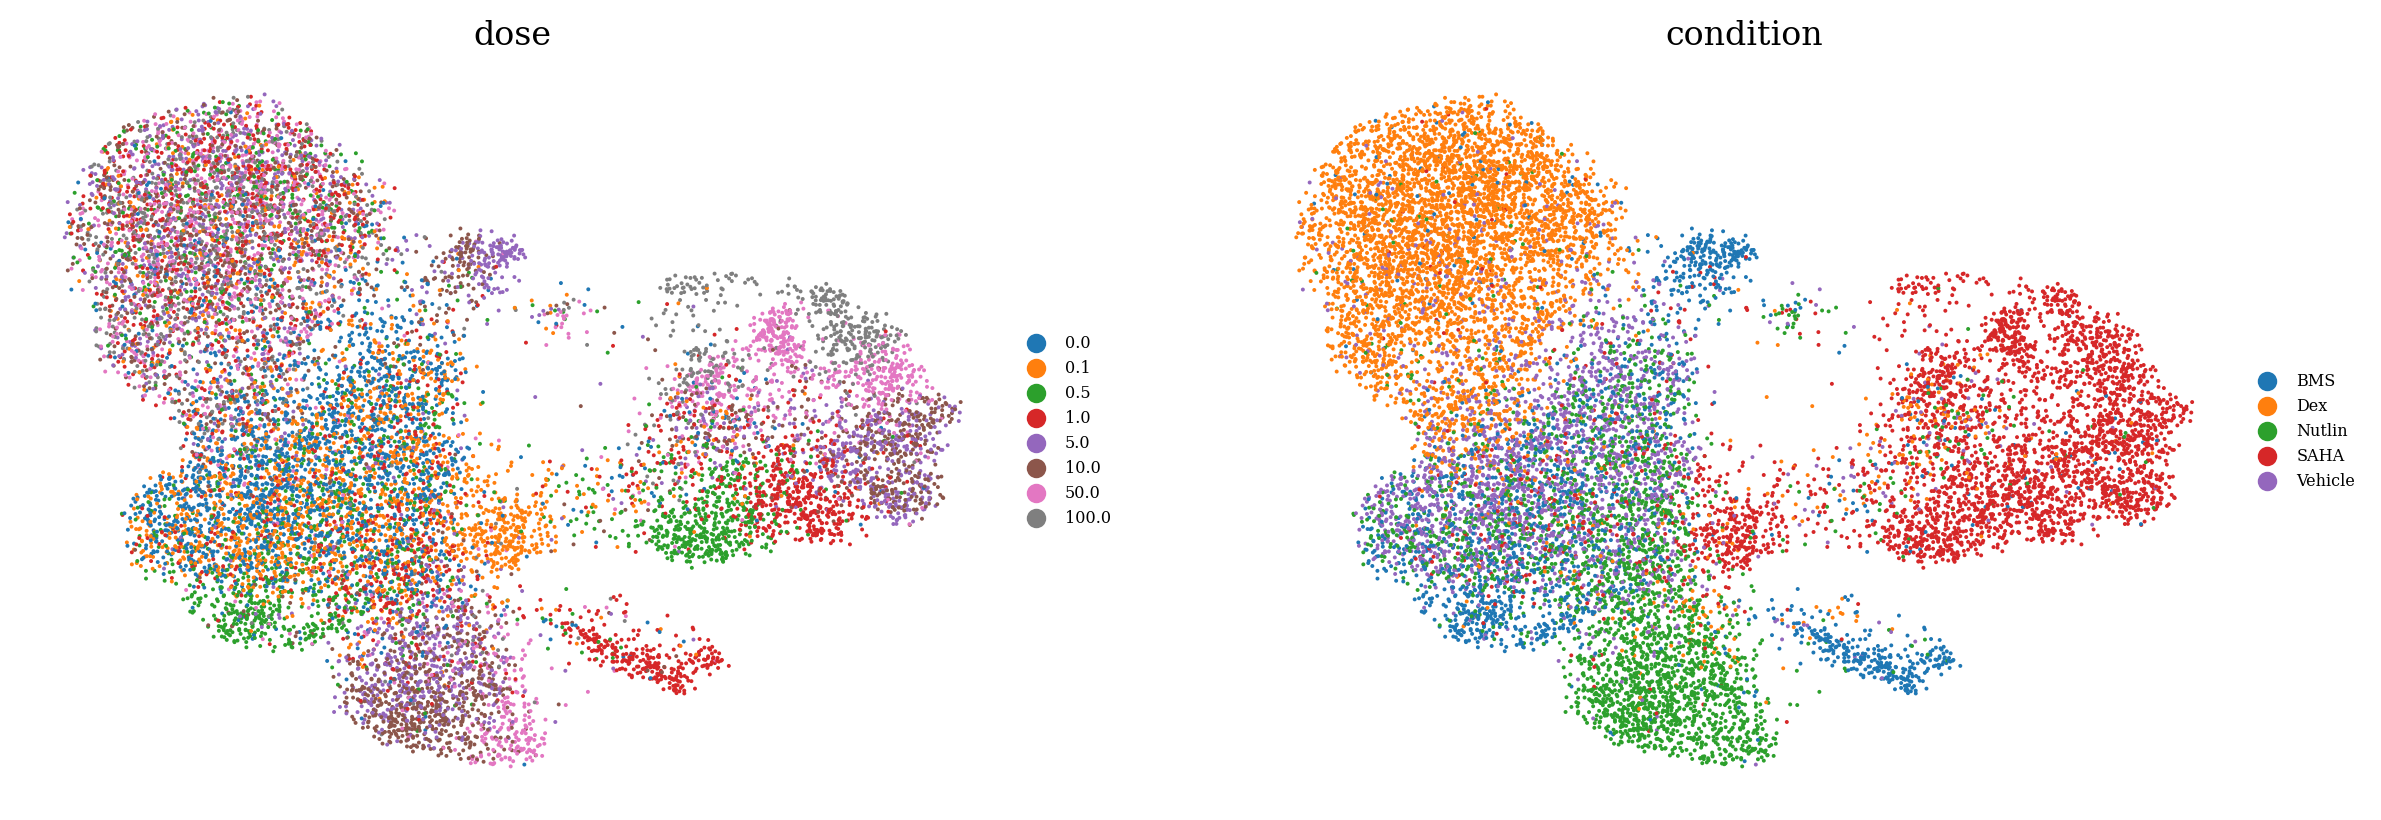

In [20]:
sc.pp.neighbors(latents["latent_after"])
sc.tl.umap(latents["latent_after"])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latents["latent_after"], 
        color=["dose", "condition"], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

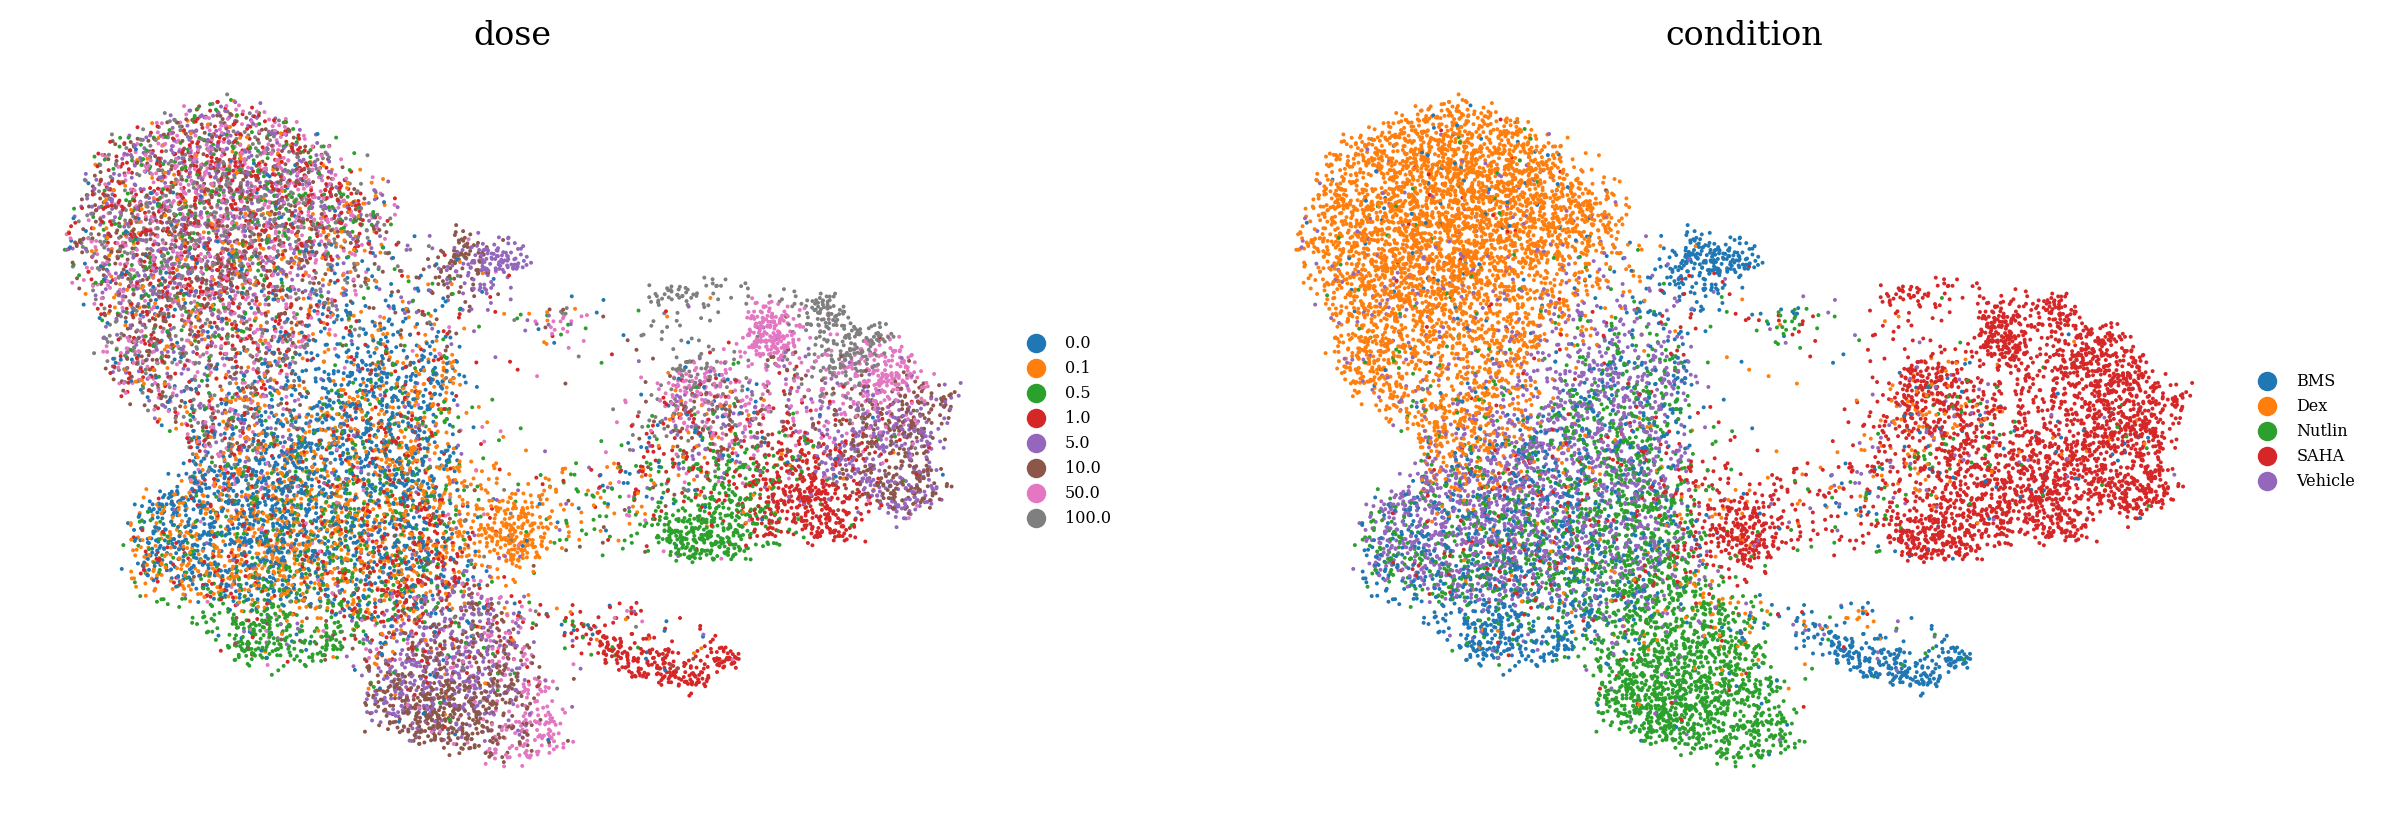

In [21]:
sc.pp.neighbors(latents["latent_basal"])
sc.tl.umap(latents["latent_basal"])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latents["latent_basal"], 
        color=["dose", "condition"], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

In [22]:
model.predict()

  0%|          | 0/463 [00:00<?, ?it/s]

  0%|          | 1/463 [00:00<01:17,  5.97it/s]

  6%|▌         | 26/463 [00:00<00:03, 117.01it/s]

 11%|█         | 51/463 [00:00<00:02, 168.40it/s]

 16%|█▋        | 76/463 [00:00<00:01, 194.95it/s]

 22%|██▏       | 100/463 [00:00<00:01, 210.06it/s]

 27%|██▋       | 125/463 [00:00<00:01, 220.05it/s]

 32%|███▏      | 150/463 [00:00<00:01, 226.62it/s]

 38%|███▊      | 175/463 [00:00<00:01, 231.05it/s]

 43%|████▎     | 200/463 [00:00<00:01, 234.02it/s]

 49%|████▊     | 225/463 [00:01<00:01, 236.19it/s]

 54%|█████▍    | 249/463 [00:01<00:00, 236.62it/s]

 59%|█████▉    | 274/463 [00:01<00:00, 238.18it/s]

 65%|██████▍   | 299/463 [00:01<00:00, 239.17it/s]

 70%|██████▉   | 324/463 [00:01<00:00, 239.85it/s]

 75%|███████▌  | 349/463 [00:01<00:00, 240.44it/s]

 81%|████████  | 374/463 [00:01<00:00, 240.69it/s]

 86%|████████▌ | 399/463 [00:01<00:00, 240.74it/s]

 92%|█████████▏| 424/463 [00:01<00:00, 240.53it/s]

 97%|█████████▋| 449/463 [00:02<00:00, 240.24it/s]

100%|██████████| 463/463 [00:02<00:00, 221.47it/s]

In [23]:
pred_adata = adata[model.test_indices].copy()
true = pred_adata.X.A
pred = pred_adata.obsm["CPA_pred"]

In [24]:
batch_size = 32

r2s = []
start_ind = 0
for end_ind in range(batch_size, len(true), batch_size):
    t = true[start_ind:end_ind]
    p = pred[start_ind:end_ind]
    r2 = sklearn.metrics.r2_score(y_true=t.mean(axis=0), y_pred=p.mean(axis=0))
    r2s.append(r2)
    start_ind = end_ind
np.mean(r2s)

0.9917171878144894

In [25]:
dir_path_latent = os.path.join(
    "/home/icb/kemal.inecik/lustre_workspace/tardis_data/_temporary/latent",
    f"sciplex_cpa_ood-seed-{ood_seed}_size-{num_ood}.h5ad"
)
adata.write_h5ad(dir_path_latent)